In [101]:
import accelerate
import datetime
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import statistics
import sys
import textblob
import torch
import wordcloud

from collections import Counter
from langchain.embeddings import HuggingFaceEmbeddings
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig, AutoTokenizer, BertModel, BertTokenizer, DistilBertModel, DistilBertTokenizer, TrainingArguments, Trainer
from wordcloud import WordCloud

In [13]:
print(sys.executable)

c:\Users\Lenovo\anaconda3\envs\ENV\python.exe


In [52]:
df = pd.read_csv('C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets\\ready_dataset.csv')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\3998311460.py:1: DtypeWarning: Columns (7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets\\ready_dataset.csv')


In [72]:
df_5 = pd.read_csv("C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets\\df_5.csv")
df_5

following  followers  updates  news_type  num_hashtags  num_mentions  \
0            3993       4690     1371          0             0             0   
1            3993       4691     1376          0             0             0   
2            3993       4690     1372          0             1             0   
3            3993       4690     1372          0             1             0   
4            3993       4692     1375          0             0             0   
...           ...        ...      ...        ...           ...           ...   
343651       1664       1485     1573          0             0             0   
343652       1664       1485     1572          0             3             0   
343653       1664       1485     1580          0             1             0   
343654       1664       1485     1577          0             2             0   
343655       1664       1485     1579          0             0             0   

        num_question_marks  num_exclamation_marks  num_first_person_pronouns  \
0                        0                      0                          0   
1                        0                      0                          0   
2                        0                      1                          4   
3                        0                      0                          4   
4                        0                      0                          6   
...                    ...                    ...                        ...   
343651                   1                      0                          2   
343652                   0                      0                          2   
343653                   0                      0                          1   
343654                   0                      1                          2   
343655                   0                      0                          1   

        num_second_person_pronouns  num_third_person_pronouns  sentiment_vader  
0                                1                          1           0.0000  
1                                0                          0           0.5859  
2                                4                          0          -0.6486  
3                                0                          2           0.0000  
4                                1                          1           0.3400  
...                            ...                        ...              ...  
343651                           0                          1           0.4588  
343652                           2                          1           0.8834  
343653                           3                          5           0.1027  
343654                           1                          0           0.7579  
343655                           2                          4          -0.2732  

[343656 rows x 12 columns]

In [15]:
df

external_author_id           author  \
0              9.060000e+17           10_GOP   
1              9.060000e+17           10_GOP   
2              9.060000e+17           10_GOP   
3              9.060000e+17           10_GOP   
4              9.060000e+17           10_GOP   
...                     ...              ...   
1732802        1.673957e+09  _SOLOMONALBERT_   
1732803        1.673957e+09  _SOLOMONALBERT_   
1732804        1.673957e+09  _SOLOMONALBERT_   
1732805        1.673957e+09  _SOLOMONALBERT_   
1732806        1.673957e+09  _SOLOMONALBERT_   

                                                   content     publish_date  \
0        "We have a sitting Democrat US Senator on tria...  10/1/2017 19:58   
1        Marshawn Lynch arrives to game in anti-Trump s...  10/1/2017 22:43   
2        Daughter of fallen Navy Sailor delivers powerf...  10/1/2017 22:50   
3        JUST IN: President Trump dedicates Presidents ...  10/1/2017 23:52   
4        19,000 RESPECTING our National Anthem! #StandF...   10/1/2017 2:13   
...                                                    ...              ...   
1732802  These police are train killers. I don’t shed a...   8/9/2015 16:15   
1732803  #BUT - @FloydMayweather Retires From #Boxing  ...   9/14/2015 8:07   
1732804  No guns allowed to all people. Especially #bla...   9/19/2015 8:23   
1732805  Support the #petition that banns providing #bl...   9/19/2015 8:23   
1732806  Criminals kill people with legally bought guns...   9/19/2015 8:23   

         following  followers  updates post_type  retweet account_category  \
0             1052       9636      253       NaN        0       RightTroll   
1             1054       9637      254       NaN        0       RightTroll   
2             1054       9637      255   RETWEET        1       RightTroll   
3             1062       9642      256       NaN        0       RightTroll   
4             1050       9645      246   RETWEET        1       RightTroll   
...            ...        ...      ...       ...      ...              ...   
1732802        102         72      354   RETWEET        1        LeftTroll   
1732803        100         74      363   RETWEET        1        LeftTroll   
1732804        100         72      369   RETWEET        1        LeftTroll   
1732805        100         72      375   RETWEET        1        LeftTroll   
1732806        100         72      373   RETWEET        1        LeftTroll   

        news_type  num_hashtags  num_mentions  num_question_marks  \
0            fake             0             1                   0   
1            fake             0             0                   0   
2            fake             1             0                   0   
3            fake             0             0                   0   
4            fake             1             0                   0   
...           ...           ...           ...                 ...   
1732802      fake             2             0                   0   
1732803      fake             4             1                   0   
1732804      fake             2             0                   0   
1732805      fake             3             0                   0   
1732806      fake             1             0                   0   

         num_exclamation_marks  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            1   
...                        ...   
1732802                      0   
1732803                      0   
1732804                      0   
1732805                      0   
1732806                      0   

                                             content_lower  \
0        "we have a sitting democrat us senator on tria...   
1        marshawn lynch arrives to game in anti-trump s...   
2        daughter of fallen navy sailor delivers powerf...   
3        just in: president trump dedicates presidents ...  

In [53]:
df.drop("external_author_id", axis=1, inplace=True)

In [17]:
print(df.head)

<bound method NDFrame.head of                   author                                            content  \
0                 10_GOP  "We have a sitting Democrat US Senator on tria...   
1                 10_GOP  Marshawn Lynch arrives to game in anti-Trump s...   
2                 10_GOP  Daughter of fallen Navy Sailor delivers powerf...   
3                 10_GOP  JUST IN: President Trump dedicates Presidents ...   
4                 10_GOP  19,000 RESPECTING our National Anthem! #StandF...   
...                  ...                                                ...   
1732802  _SOLOMONALBERT_  These police are train killers. I don’t shed a...   
1732803  _SOLOMONALBERT_  #BUT - @FloydMayweather Retires From #Boxing  ...   
1732804  _SOLOMONALBERT_  No guns allowed to all people. Especially #bla...   
1732805  _SOLOMONALBERT_  Support the #petition that banns providing #bl...   
1732806  _SOLOMONALBERT_  Criminals kill people with legally bought guns...   

            publish_d

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732807 entries, 0 to 1732806
Data columns (total 19 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   author                      object
 1   content                     object
 2   publish_date                object
 3   following                   int64 
 4   followers                   int64 
 5   updates                     int64 
 6   post_type                   object
 7   retweet                     int64 
 8   account_category            object
 9   news_type                   object
 10  num_hashtags                int64 
 11  num_mentions                int64 
 12  num_question_marks          int64 
 13  num_exclamation_marks       int64 
 14  content_lower               object
 15  num_first_person_pronouns   int64 
 16  num_second_person_pronouns  int64 
 17  num_third_person_pronouns   int64 
 18  num_chars                   int64 
dtypes: int64(12), object(7)
memory usage: 251.

In [54]:
# a set of English stop words
stop_words = set(stopwords.words('english'))

In [55]:
new_stop_words = pd.DataFrame(["https", "http", "t.co", "amp", "rt", "wed", "tcot", "pjnet", "gt", "al", "ft"], columns=["word"])

stop_words.update(new_stop_words["word"])

In [56]:
def clean_text(text):
    # Removing URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Removing numbers and special characters
    text = re.sub(r'\W+|_', ' ', text)
    text = re.sub(r'\d+', '', text)
    # Tokenizing the text to get list of words
    text = word_tokenize(text)
    # Removing stop words
    text = ' '.join([word for word in text if word not in stop_words])
    return text


In [57]:
%%timeit
# the function to each tweet in 'content_lower' column
df['content_lower'] = df['content_lower'].apply(clean_text)

3min 43s ± 23.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
df_fake = df[df['news_type'] == 'fake']
df_real = df[df['news_type'] == 'true']

# new column 'word_count' 
df_fake['word_count'] = df_fake['content_lower'].apply(lambda x: len(x.split()))
df_real['word_count'] = df_real['content_lower'].apply(lambda x: len(x.split()))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\1115871275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake['word_count'] = df_fake['content_lower'].apply(lambda x: len(x.split()))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\1115871275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real['word_count'] = df_real['content_lower'].apply(lambda x: len(x.split()))


In [59]:
# Calculating average number of words 
avg_fake = df_fake['word_count'].mean()
avg_real = df_real['word_count'].mean()

print('Average number of words in fake news:', avg_fake)
print('Average number of words in real news:', avg_real)

Average number of words in fake news: 8.630319666722754
Average number of words in real news: 7.971415650772423


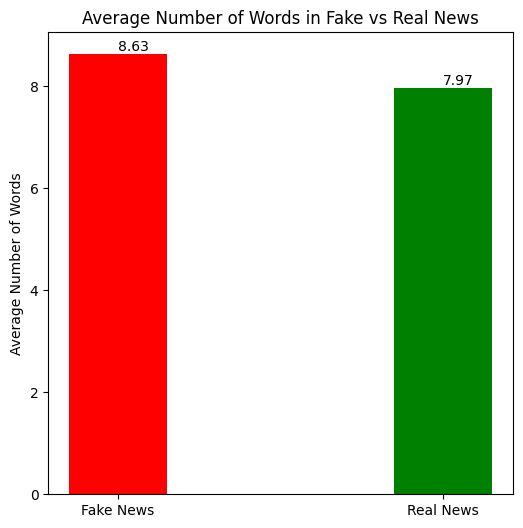

In [70]:
plt.figure(figsize=(6, 6))
bars = plt.bar(['Fake News', 'Real News'], [avg_fake, avg_real], color=['red', 'green'], width=0.3)

plt.ylabel('Average Number of Words')
plt.title('Average Number of Words in Fake vs Real News')

# Adding the average word counts
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom') # va: vertical alignment

plt.show()


In [28]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
sid = SentimentIntensityAnalyzer()

In [30]:
def get_vader_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores['compound']

In [31]:
%%timeit
# function for the 'content_lower' column
df['sentiment_vader'] = df['content_lower'].apply(get_vader_sentiment)

3min 42s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
df_sorted = df.sort_values('sentiment_vader')

print(df_sorted)


                  author                                            content  \
970499     LEROYLOVESUSA  1. Kill the bastard 2. Kill the bastard 3. Kil...   
899954      KANIJJACKSON  NRA is a terrorist organization. NRA is a terr...   
1161187    PAMBLMDANIELS  "Racism didn't cause slavery. Slavery caused r...   
44051       ALECMOOOOODY  "Racism didn't cause slavery. Slavery caused r...   
1066747        NEHEMIAHX  "Racism didn't cause slavery. Slavery caused r...   
...                  ...                                                ...   
439978   COVFEFENATIONUS  We win, we win, we win, we win, we win, we win...   
440003   COVFEFENATIONUS  '@KevinMatras @SenBobCorker We win, we win, we...   
439980   COVFEFENATIONUS  We win, we win, we win, we win, we win, we win...   
439968   COVFEFENATIONUS  We win, we win, we win, we win, we win, we win...   
439985   COVFEFENATIONUS  We win, we win, we win, we win, we win, we win...   

            publish_date  following  followers  upd

In [51]:
df

author  \
publish_date                           
2017-10-01 19:58:00           10_GOP   
2017-10-01 22:43:00           10_GOP   
2017-10-01 22:50:00           10_GOP   
2017-10-01 23:52:00           10_GOP   
2017-10-01 02:13:00           10_GOP   
...                              ...   
2015-08-09 16:15:00  _SOLOMONALBERT_   
2015-09-14 08:07:00  _SOLOMONALBERT_   
2015-09-19 08:23:00  _SOLOMONALBERT_   
2015-09-19 08:23:00  _SOLOMONALBERT_   
2015-09-19 08:23:00  _SOLOMONALBERT_   

                                                               content  \
publish_date                                                             
2017-10-01 19:58:00  "We have a sitting Democrat US Senator on tria...   
2017-10-01 22:43:00  Marshawn Lynch arrives to game in anti-Trump s...   
2017-10-01 22:50:00  Daughter of fallen Navy Sailor delivers powerf...   
2017-10-01 23:52:00  JUST IN: President Trump dedicates Presidents ...   
2017-10-01 02:13:00  19,000 RESPECTING our National Anthem! #StandF...   
...                                                                ...   
2015-08-09 16:15:00  These police are train killers. I don’t shed a...   
2015-09-14 08:07:00  #BUT - @FloydMayweather Retires From #Boxing  ...   
2015-09-19 08:23:00  No guns allowed to all people. Especially #bla...   
2015-09-19 08:23:00  Support the #petition that banns providing #bl...   
2015-09-19 08:23:00  Criminals kill people with legally bought guns...   

                     following  followers  updates post_type  retweet  \
publish_date                                                            
2017-10-01 19:58:00       1052       9636      253       NaN        0   
2017-10-01 22:43:00       1054       9637      254       NaN        0   
2017-10-01 22:50:00       1054       9637      255   RETWEET        1   
2017-10-01 23:52:00       1062       9642      256       NaN        0   
2017-10-01 02:13:00       1050       9645      246   RETWEET        1   
...                        ...        ...      ...       ...      ...   
2015-08-09 16:15:00        102         72      354   RETWEET        1   
2015-09-14 08:07:00        100         74      363   RETWEET        1   
2015-09-19 08:23:00        100         72      369   RETWEET        1   
2015-09-19 08:23:00        100         72      375   RETWEET        1   
2015-09-19 08:23:00        100         72      373   RETWEET        1   

                    account_category  news_type  num_hashtags  num_mentions  \
publish_date                                                                  
2017-10-01 19:58:00       RightTroll      False             0             1   
2017-10-01 22:43:00       RightTroll      False             0             0   
2017-10-01 22:50:00       RightTroll      False             1             0   
2017-10-01 23:52:00       RightTroll      False             0             0   
2017-10-01 02:13:00       RightTroll      False             1             0   
...                              ...        ...           ...           ...   
2015-08-09 16:15:00        LeftTroll      False             2             0   
2015-09-14 08:07:00        LeftTroll      False             4             1   
2015-09-19 08:23:00        LeftTroll      False             2             0   
2015-09-19 08:23:00        LeftTroll      False             3             0   
2015-09-19 08:23:00        LeftTroll      False             1             0   

                     num_question_marks  num_exclamation_marks  \
publish_date                                                     
2017-10-01 19:58:00                   0                      0   
2017-10-01 22:43:00                   0                      0   
2017-10-01 22:50:00                   0                      0   
2017-10-01 23:52:00                   0                      0   
2017-10-01 02:13:00                   0                      1   
...                                 ...                    ...   
2015-08-09 16:15:00                   0 

In [32]:
df_new = df.drop_duplicates(subset=['content_lower', 'author'])
df_new

author                                            content  \
0                 10_GOP  "We have a sitting Democrat US Senator on tria...   
1                 10_GOP  Marshawn Lynch arrives to game in anti-Trump s...   
2                 10_GOP  Daughter of fallen Navy Sailor delivers powerf...   
3                 10_GOP  JUST IN: President Trump dedicates Presidents ...   
4                 10_GOP  19,000 RESPECTING our National Anthem! #StandF...   
...                  ...                                                ...   
1732802  _SOLOMONALBERT_  These police are train killers. I don’t shed a...   
1732803  _SOLOMONALBERT_  #BUT - @FloydMayweather Retires From #Boxing  ...   
1732804  _SOLOMONALBERT_  No guns allowed to all people. Especially #bla...   
1732805  _SOLOMONALBERT_  Support the #petition that banns providing #bl...   
1732806  _SOLOMONALBERT_  Criminals kill people with legally bought guns...   

            publish_date  following  followers  updates post_type  retweet  \
0        10/1/2017 19:58       1052       9636      253       NaN        0   
1        10/1/2017 22:43       1054       9637      254       NaN        0   
2        10/1/2017 22:50       1054       9637      255   RETWEET        1   
3        10/1/2017 23:52       1062       9642      256       NaN        0   
4         10/1/2017 2:13       1050       9645      246   RETWEET        1   
...                  ...        ...        ...      ...       ...      ...   
1732802   8/9/2015 16:15        102         72      354   RETWEET        1   
1732803   9/14/2015 8:07        100         74      363   RETWEET        1   
1732804   9/19/2015 8:23        100         72      369   RETWEET        1   
1732805   9/19/2015 8:23        100         72      375   RETWEET        1   
1732806   9/19/2015 8:23        100         72      373   RETWEET        1   

        account_category news_type  num_hashtags  num_mentions  \
0             RightTroll      fake             0             1   
1             RightTroll      fake             0             0   
2             RightTroll      fake             1             0   
3             RightTroll      fake             0             0   
4             RightTroll      fake             1             0   
...                  ...       ...           ...           ...   
1732802        LeftTroll      fake             2             0   
1732803        LeftTroll      fake             4             1   
1732804        LeftTroll      fake             2             0   
1732805        LeftTroll      fake             3             0   
1732806        LeftTroll      fake             1             0   

         num_question_marks  num_exclamation_marks  \
0                         0                      0   
1                         0                      0   
2                         0                      0   
3                         0                      0   
4                         0                      1   
...                     ...                    ...   
1732802                   0                      0   
1732803                   0                      0   
1732804                   0                      0   
1732805                   0                      0   
1732806                   0                      0   

                                             content_lower  \
0        sitting democrat us senator trial corruption b...   
1        marshawn lynch arrives game anti trump shirt j...   
2        daughter fallen navy sailor delivers powerful ...   
3        president trump dedicates presidents cup golf ...   
4             respecting national anthem standforouranthem   
...                                                    ...   
1732802  police train killers shed tear hear police dea...   
1732803         floydmayweather retires boxing sport shock   
1732804  guns allowed people especially black especiall...   
1732805  support petition banns providing black hoods f...   
1732806 

In [33]:
df = df_new

In [49]:
print(df.columns.tolist())

['author', 'content', 'following', 'followers', 'updates', 'post_type', 'retweet', 'account_category', 'news_type', 'num_hashtags', 'num_mentions', 'num_question_marks', 'num_exclamation_marks', 'content_lower', 'num_first_person_pronouns', 'num_second_person_pronouns', 'num_third_person_pronouns', 'num_chars', 'sentiment_vader']


In [ ]:
['author', 'content', 'publish_date', 'following', 'followers', 'updates', 'post_type', 'retweet', 'account_category', 'news_type', 'num_hashtags', 'num_mentions', 'num_question_marks', 'num_exclamation_marks', 'content_lower', 'num_first_person_pronouns', 'num_second_person_pronouns', 'num_third_person_pronouns', 'num_chars', 'sentiment_vader'] okay those are my column names, I will ask You now to convert publish_date into readable time series data so it would be understandable. Then create a df_1 in which I will drop those columns, not usable for the analysis: content, post_type, account_category, the variable I want to predict is 

In [46]:
print(df['news_type'].unique())

[False  True]


In [37]:
df['news_type'] = df['news_type'].map({'true': True, 'fake': False, True: True})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30508\2447887425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news_type'] = df['news_type'].map({'true': True, 'fake': False, True: True})


In [38]:
df['publish_date'] = pd.to_datetime(df['publish_date'])


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30508\1449632554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['publish_date'] = pd.to_datetime(df['publish_date'])


In [39]:
earliest_date = df['publish_date'].min()
latest_date = df['publish_date'].max()

print("Earliest Date: ", earliest_date)
print("Latest Date: ", latest_date)


Earliest Date:  2012-02-06 20:24:00
Latest Date:  2018-05-30 20:58:00


In [52]:
df.reset_index(level=0, inplace=True)


In [53]:
df['publish_date']

0         2017-10-01 19:58:00
1         2017-10-01 22:43:00
2         2017-10-01 22:50:00
3         2017-10-01 23:52:00
4         2017-10-01 02:13:00
                  ...        
1637706   2015-08-09 16:15:00
1637707   2015-09-14 08:07:00
1637708   2015-09-19 08:23:00
1637709   2015-09-19 08:23:00
1637710   2015-09-19 08:23:00
Name: publish_date, Length: 1637711, dtype: datetime64[ns]

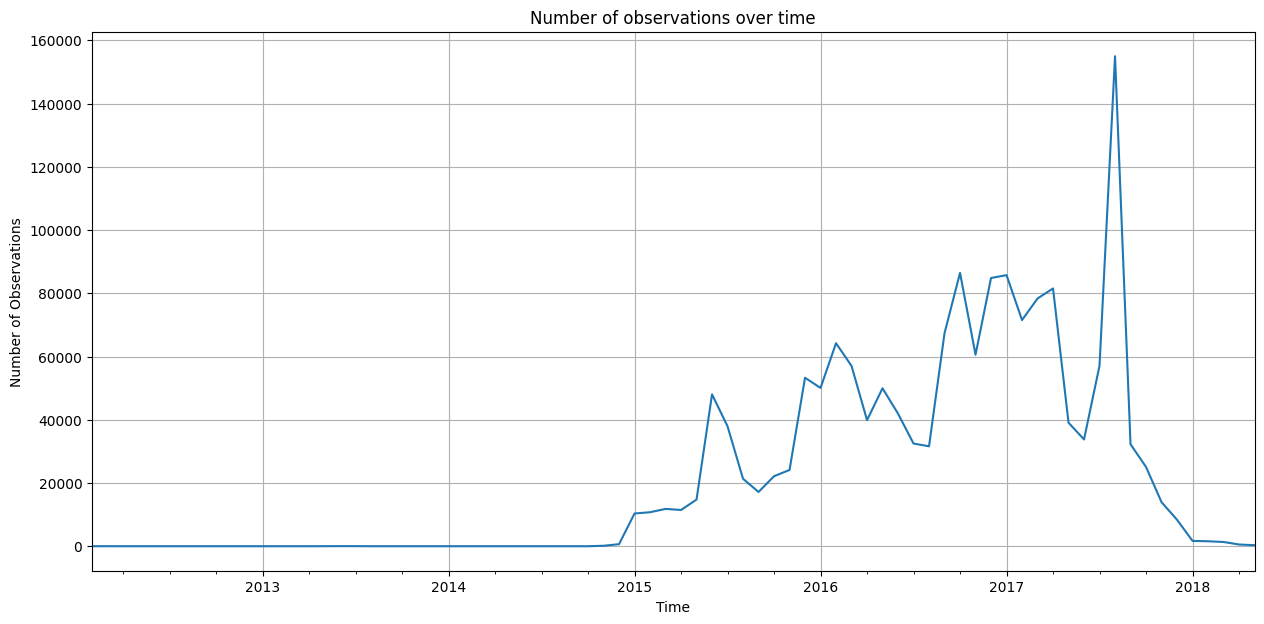

In [41]:
df.set_index('publish_date', inplace=True)

# Resample the data to represent the number of observations per month
resampled_df = df.resample('M').size()

# Plotting
plt.figure(figsize=(15, 7))
resampled_df.plot()
plt.title('Number of observations over time')
plt.xlabel('Time')
plt.ylabel('Number of Observations')
plt.grid(True)
plt.show()

In [48]:
print(df.columns)


Index(['author', 'content', 'following', 'followers', 'updates', 'post_type',
       'retweet', 'account_category', 'news_type', 'num_hashtags',
       'num_mentions', 'num_question_marks', 'num_exclamation_marks',
       'content_lower', 'num_first_person_pronouns',
       'num_second_person_pronouns', 'num_third_person_pronouns', 'num_chars',
       'sentiment_vader'],
      dtype='object')


In [54]:
filtered_df[lemmatized_text]


NameError: name 'filtered_df' is not defined

In [ ]:
# Map integers to boolean strings
df_1['news_type'] = df_1['news_type'].map({0: 'False', 1: 'True'})

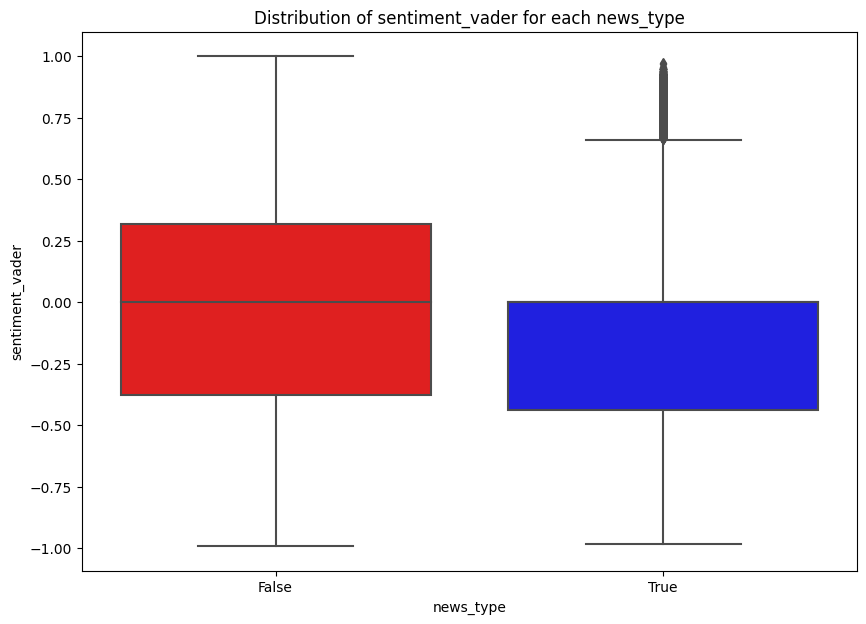

In [ ]:
# boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(x='news_type', y='sentiment_vader', data=df_1, palette={'False': 'red', 'True': 'blue'})
plt.title('Distribution of sentiment_vader for each news_type')
plt.show()

In [ ]:

# Map boolean strings back to integers
df_1['news_type'] = df_1['news_type'].map({'False': 0, 'True': 1})

In [56]:
df_3 = df[['content_lower']].copy()
df_3


content_lower
0        sitting democrat us senator trial corruption b...
1        marshawn lynch arrives game anti trump shirt j...
2        daughter fallen navy sailor delivers powerful ...
3        president trump dedicates presidents cup golf ...
4             respecting national anthem standforouranthem
...                                                    ...
1637706  police train killers shed tear hear police dea...
1637707         floydmayweather retires boxing sport shock
1637708  guns allowed people especially black especiall...
1637709  support petition banns providing black hoods f...
1637710  criminals kill people legally bought guns stop...

[1637711 rows x 1 columns]

In [57]:

# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply the lemmatizer to each word in each document of the corpus
df_3['lemmatized_text'] = df_3['content_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))


In [59]:
df_3 = df_3.drop('content_lower', axis=1)
df_3

lemmatized_text
0        sitting democrat u senator trial corruption ba...
1        marshawn lynch arrives game anti trump shirt j...
2        daughter fallen navy sailor delivers powerful ...
3        president trump dedicates president cup golf t...
4             respecting national anthem standforouranthem
...                                                    ...
1637706  police train killer shed tear hear police dead...
1637707         floydmayweather retires boxing sport shock
1637708  gun allowed people especially black especially...
1637709  support petition banns providing black hood fi...
1637710  criminal kill people legally bought gun stop n...

[1637711 rows x 1 columns]

In [61]:
df = df.merge(df_3, left_index=True, right_index=True)
df

publish_date           author  \
0       2017-10-01 19:58:00           10_GOP   
1       2017-10-01 22:43:00           10_GOP   
2       2017-10-01 22:50:00           10_GOP   
3       2017-10-01 23:52:00           10_GOP   
4       2017-10-01 02:13:00           10_GOP   
...                     ...              ...   
1637706 2015-08-09 16:15:00  _SOLOMONALBERT_   
1637707 2015-09-14 08:07:00  _SOLOMONALBERT_   
1637708 2015-09-19 08:23:00  _SOLOMONALBERT_   
1637709 2015-09-19 08:23:00  _SOLOMONALBERT_   
1637710 2015-09-19 08:23:00  _SOLOMONALBERT_   

                                                   content  following  \
0        "We have a sitting Democrat US Senator on tria...       1052   
1        Marshawn Lynch arrives to game in anti-Trump s...       1054   
2        Daughter of fallen Navy Sailor delivers powerf...       1054   
3        JUST IN: President Trump dedicates Presidents ...       1062   
4        19,000 RESPECTING our National Anthem! #StandF...       1050   
...                                                    ...        ...   
1637706  These police are train killers. I don’t shed a...        102   
1637707  #BUT - @FloydMayweather Retires From #Boxing  ...        100   
1637708  No guns allowed to all people. Especially #bla...        100   
1637709  Support the #petition that banns providing #bl...        100   
1637710  Criminals kill people with legally bought guns...        100   

         followers  updates post_type  retweet account_category  news_type  \
0             9636      253       NaN        0       RightTroll      False   
1             9637      254       NaN        0       RightTroll      False   
2             9637      255   RETWEET        1       RightTroll      False   
3             9642      256       NaN        0       RightTroll      False   
4             9645      246   RETWEET        1       RightTroll      False   
...            ...      ...       ...      ...              ...        ...   
1637706         72      354   RETWEET        1        LeftTroll      False   
1637707         74      363   RETWEET        1        LeftTroll      False   
1637708         72      369   RETWEET        1        LeftTroll      False   
1637709         72      375   RETWEET        1        LeftTroll      False   
1637710         72      373   RETWEET        1        LeftTroll      False   

         ...  num_mentions  num_question_marks  num_exclamation_marks  \
0        ...             1                   0                      0   
1        ...             0                   0                      0   
2        ...             0                   0                      0   
3        ...             0                   0                      0   
4        ...             0                   0                      1   
...      ...           ...                 ...                    ...   
1637706  ...             0                   0                      0   
1637707  ...             1                   0                      0   
1637708  ...             0                   0                      0   
1637709  ...             0                   0                      0   
1637710  ...             0                   0                      0   

                                             content_lower  \
0        sitting democrat us senator trial corruption b...   
1        marshawn lynch arrives game anti trump shirt j...   
2        daughter fallen navy sailor delivers powerful ...   
3        president trump dedicates presidents cup golf ...   
4             respecting national anthem standforouranthem   
...                                                    ...   
1637706  police train killers shed tear hear police dea...   
1637707         floydmayweather retires boxing sport shock   
1637708  guns allowed people especially black especiall...   
1637709  support petition banns providing black hoods f...   
1637710  criminals kill people legally bought guns stop...   

  

In [64]:
df.drop(columns=['author', 'content_lower', 'post_type'], axis=1)

publish_date  \
0       2017-10-01 19:58:00   
1       2017-10-01 22:43:00   
2       2017-10-01 22:50:00   
3       2017-10-01 23:52:00   
4       2017-10-01 02:13:00   
...                     ...   
1637706 2015-08-09 16:15:00   
1637707 2015-09-14 08:07:00   
1637708 2015-09-19 08:23:00   
1637709 2015-09-19 08:23:00   
1637710 2015-09-19 08:23:00   

                                                   content  following  \
0        "We have a sitting Democrat US Senator on tria...       1052   
1        Marshawn Lynch arrives to game in anti-Trump s...       1054   
2        Daughter of fallen Navy Sailor delivers powerf...       1054   
3        JUST IN: President Trump dedicates Presidents ...       1062   
4        19,000 RESPECTING our National Anthem! #StandF...       1050   
...                                                    ...        ...   
1637706  These police are train killers. I don’t shed a...        102   
1637707  #BUT - @FloydMayweather Retires From #Boxing  ...        100   
1637708  No guns allowed to all people. Especially #bla...        100   
1637709  Support the #petition that banns providing #bl...        100   
1637710  Criminals kill people with legally bought guns...        100   

         followers  updates  retweet account_category  news_type  \
0             9636      253        0       RightTroll      False   
1             9637      254        0       RightTroll      False   
2             9637      255        1       RightTroll      False   
3             9642      256        0       RightTroll      False   
4             9645      246        1       RightTroll      False   
...            ...      ...      ...              ...        ...   
1637706         72      354        1        LeftTroll      False   
1637707         74      363        1        LeftTroll      False   
1637708         72      369        1        LeftTroll      False   
1637709         72      375        1        LeftTroll      False   
1637710         72      373        1        LeftTroll      False   

         num_hashtags  num_mentions  num_question_marks  \
0                   0             1                   0   
1                   0             0                   0   
2                   1             0                   0   
3                   0             0                   0   
4                   1             0                   0   
...               ...           ...                 ...   
1637706             2             0                   0   
1637707             4             1                   0   
1637708             2             0                   0   
1637709             3             0                   0   
1637710             1             0                   0   

         num_exclamation_marks  num_first_person_pronouns  \
0                            0                          3   
1                            0                          2   
2                            0                          2   
3                            0                          4   
4                            1                          2   
...                        ...                        ...   
1637706                      0                          5   
1637707                      0                          1   
1637708                      0                          1   
1637709                      0                          0   
1637710                      0                          2   

         num_second_person_pronouns  num_third_person_pronouns  num_chars  \
0                                 4                          2        156   
1                                 3                          1        140   
2                                 4                          2        143   
3                                 5                          0        145   
4                                 3                          2         85   
...                             ...         

In [63]:
df_3

lemmatized_text
0        sitting democrat u senator trial corruption ba...
1        marshawn lynch arrives game anti trump shirt j...
2        daughter fallen navy sailor delivers powerful ...
3        president trump dedicates president cup golf t...
4             respecting national anthem standforouranthem
...                                                    ...
1637706  police train killer shed tear hear police dead...
1637707         floydmayweather retires boxing sport shock
1637708  gun allowed people especially black especially...
1637709  support petition banns providing black hood fi...
1637710  criminal kill people legally bought gun stop n...

[1637711 rows x 1 columns]

In [ ]:

correlation_matrix = df_3.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=False, cmap=plt.cm.Reds)
plt.show()


ValueError: could not convert string to float: '10_GOP'

In [65]:


start_date = '2016-08-08'
end_date = '2017-01-08'

mask = (df['publish_date'] >= start_date) & (df['publish_date'] <= end_date)
filtered_df = df.loc[mask]

In [69]:
filtered_df.drop(columns=['content_lower', 'post_type'], axis=1)

publish_date      author  \
745     2016-10-12 11:41:00    4MYSQUAD   
746     2016-10-12 11:41:00    4MYSQUAD   
747     2016-10-12 11:41:00    4MYSQUAD   
748     2016-10-12 11:42:00    4MYSQUAD   
749     2016-10-12 13:51:00    4MYSQUAD   
...                     ...         ...   
1637202 2016-09-30 12:18:00  _NICKLUNA_   
1637203 2016-09-30 12:18:00  _NICKLUNA_   
1637204 2016-09-30 12:21:00  _NICKLUNA_   
1637205 2016-09-30 12:21:00  _NICKLUNA_   
1637206 2016-09-30 07:32:00  _NICKLUNA_   

                                                   content  following  \
745      Colin Kaepernick to start this Sunday for the ...       3993   
746                            wow https://t.co/JCIP9bMcws       3993   
747      CRAZY! A 14 yr old child who can't pay a small...       3993   
748      Me when it's time to code-switch for an interv...       3993   
749      [RECORD SCRATCH] [FREEZE FRAME]  AMERICA: Yep,...       3993   
...                                                    ...        ...   
1637202  Ghazala Khan Gets Media Respect. Patricia Smit...       1268   
1637203  Can you be manipulated or prompted by Google.....       1268   
1637204  The New Middle East. Fantasy gives way to real...       1268   
1637205  MT @realFirearms: NO FREE MAN SHALL EVER BE DE...       1268   
1637206  "We the People" are the jury on November 8th. ...       1268   

         followers  updates  retweet account_category  news_type  \
745           4690     1371        1        LeftTroll      False   
746           4691     1376        0        LeftTroll      False   
747           4690     1372        1        LeftTroll      False   
748           4690     1372        1        LeftTroll      False   
749           4692     1375        1        LeftTroll      False   
...            ...      ...      ...              ...        ...   
1637202       1469     1848        1       RightTroll      False   
1637203       1469     1847        1       RightTroll      False   
1637204       1469     1850        1       RightTroll      False   
1637205       1469     1849        1       RightTroll      False   
1637206       1469     1846        1       RightTroll      False   

         num_hashtags  num_mentions  num_question_marks  \
745                 0             0                   0   
746                 0             0                   0   
747                 1             0                   0   
748                 1             0                   0   
749                 0             0                   0   
...               ...           ...                 ...   
1637202             1             0                   0   
1637203             2             0                   0   
1637204             0             0                   0   
1637205             2             1                   0   
1637206             2             0                   0   

         num_exclamation_marks  num_first_person_pronouns  \
745                          0                          0   
746                          0                          0   
747                          1                          4   
748                          0                          4   
749                          0                          6   
...                        ...                        ...   
1637202                      0                          2   
1637203                      0                          3   
1637204                      0                          1   
1637205                      0                          1   
1637206                      1                          3   

         num_second_person_pronouns  num_third_person_pronouns  num_chars  \
745                               1                          1        113   
746                               0                          0         27   
747                               4                          0        163   
748                               0                   

In [70]:
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

publish_date      author  \
0      2016-10-12 11:41:00    4MYSQUAD   
1      2016-10-12 11:41:00    4MYSQUAD   
2      2016-10-12 11:41:00    4MYSQUAD   
3      2016-10-12 11:42:00    4MYSQUAD   
4      2016-10-12 13:51:00    4MYSQUAD   
...                    ...         ...   
343905 2016-09-30 12:18:00  _NICKLUNA_   
343906 2016-09-30 12:18:00  _NICKLUNA_   
343907 2016-09-30 12:21:00  _NICKLUNA_   
343908 2016-09-30 12:21:00  _NICKLUNA_   
343909 2016-09-30 07:32:00  _NICKLUNA_   

                                                  content  following  \
0       Colin Kaepernick to start this Sunday for the ...       3993   
1                             wow https://t.co/JCIP9bMcws       3993   
2       CRAZY! A 14 yr old child who can't pay a small...       3993   
3       Me when it's time to code-switch for an interv...       3993   
4       [RECORD SCRATCH] [FREEZE FRAME]  AMERICA: Yep,...       3993   
...                                                   ...        ...   
343905  Ghazala Khan Gets Media Respect. Patricia Smit...       1268   
343906  Can you be manipulated or prompted by Google.....       1268   
343907  The New Middle East. Fantasy gives way to real...       1268   
343908  MT @realFirearms: NO FREE MAN SHALL EVER BE DE...       1268   
343909  "We the People" are the jury on November 8th. ...       1268   

        followers  updates post_type  retweet account_category  news_type  \
0            4690     1371   RETWEET        1        LeftTroll      False   
1            4691     1376       NaN        0        LeftTroll      False   
2            4690     1372   RETWEET        1        LeftTroll      False   
3            4690     1372   RETWEET        1        LeftTroll      False   
4            4692     1375   RETWEET        1        LeftTroll      False   
...           ...      ...       ...      ...              ...        ...   
343905       1469     1848   RETWEET        1       RightTroll      False   
343906       1469     1847   RETWEET        1       RightTroll      False   
343907       1469     1850   RETWEET        1       RightTroll      False   
343908       1469     1849   RETWEET        1       RightTroll      False   
343909       1469     1846   RETWEET        1       RightTroll      False   

        ...  num_mentions  num_question_marks  num_exclamation_marks  \
0       ...             0                   0                      0   
1       ...             0                   0                      0   
2       ...             0                   0                      1   
3       ...             0                   0                      0   
4       ...             0                   0                      0   
...     ...           ...                 ...                    ...   
343905  ...             0                   0                      0   
343906  ...             0                   0                      0   
343907  ...             0                   0                      0   
343908  ...             1                   0                      0   
343909  ...             0                   0                      1   

                                            content_lower  \
0         colin kaepernick start sunday san francisco ers   
1                                                     wow   
2       crazy yr old child pay small fine court end ad...   
3                    time code switch interview atlantafx   
4       record scratch freeze frame america yep probab...   
...                                                   ...   
343905  ghazala khan gets media respect patricia smith...   
343906  manipulated prompted google think think debate...   
343907  new middle east fantasy gives way reality nefa...   
343908  mt realfirearms free man shall ever debarred u...   
343909  people jury november th trump win end hillary ...   

       num_first_person_pronouns  num_second_person_pronouns  \
0                              0                         

In [72]:
df_3 = filtered_df[['lemmatized_text']].copy()
df_3

lemmatized_text
0          colin kaepernick start sunday san francisco er
1                                                     wow
2       crazy yr old child pay small fine court end ad...
3                    time code switch interview atlantafx
4       record scratch freeze frame america yep probab...
...                                                   ...
343905  ghazala khan get medium respect patricia smith...
343906  manipulated prompted google think think debate...
343907  new middle east fantasy give way reality nefar...
343908  mt realfirearms free man shall ever debarred u...
343909  people jury november th trump win end hillary ...

[343910 rows x 1 columns]

In [71]:
filtered_df.to_csv('ready_dataset_2.csv', index=False)

In [73]:
df_3.to_csv('lemmatized_data', index=False)

In [74]:
import time

In [78]:
embeddings = HuggingFaceEmbeddings()

In [82]:
df_4 = filtered_df.drop(columns=['lemmatized_text', 'author', 'content', 'post_type', 'content_lower'])

In [85]:
df_4 = df_4.drop(columns=['account_type'])

In [86]:
df_4['news_type'] = df_4['news_type'].astype(int)

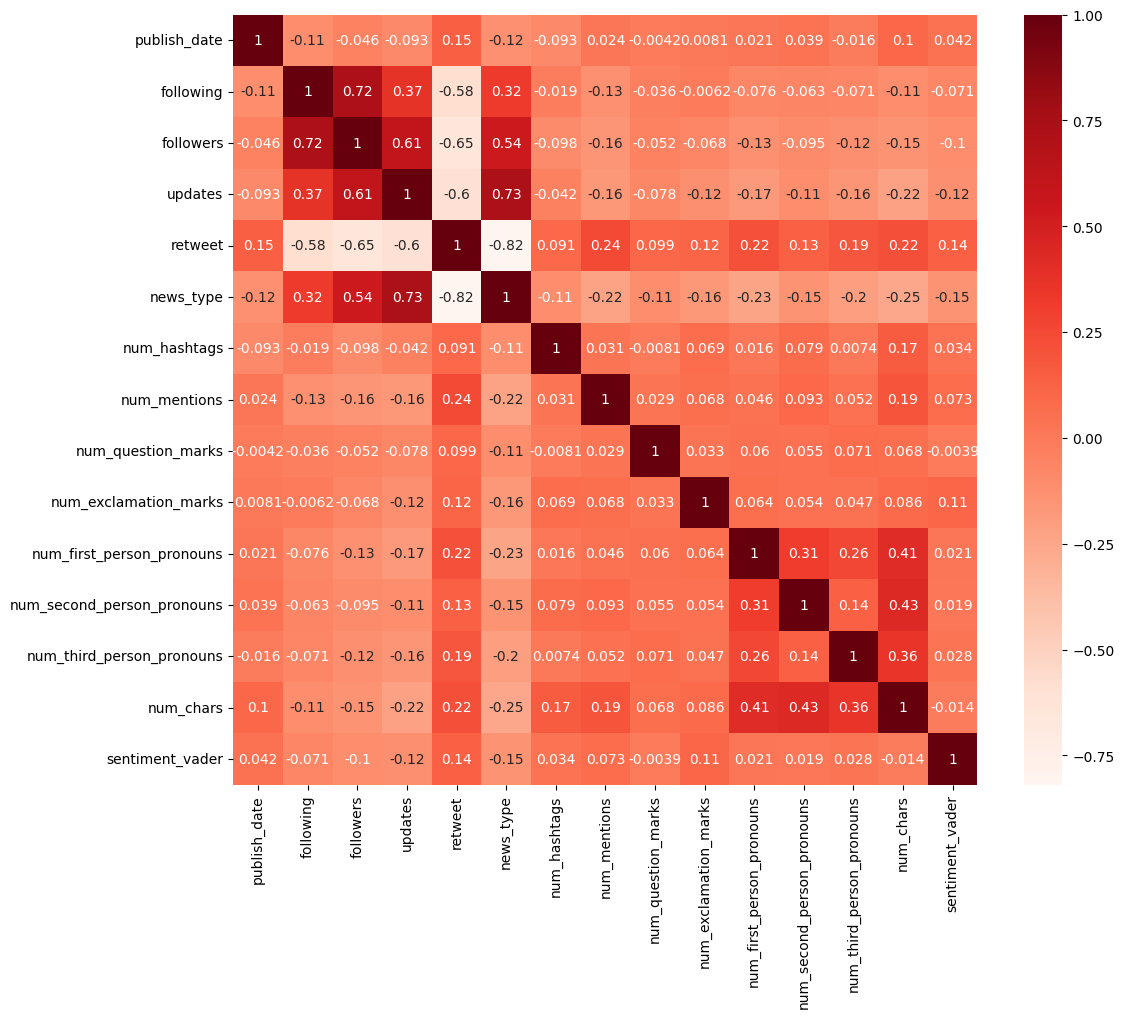

In [87]:
# Plot correlation matrix
plt.figure(figsize=(12,10))
cor = df_4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [88]:
df_4 = df_4.drop(columns=['retweet', 'num_chars'])

In [113]:
df_5 = df_5.drop(columns=['publish_date'])
df_5

following  followers  updates  news_type  num_hashtags  num_mentions  \
0            3993       4690     1371          0             0             0   
1            3993       4691     1376          0             0             0   
2            3993       4690     1372          0             1             0   
3            3993       4690     1372          0             1             0   
4            3993       4692     1375          0             0             0   
...           ...        ...      ...        ...           ...           ...   
343651       1664       1485     1573          0             0             0   
343652       1664       1485     1572          0             3             0   
343653       1664       1485     1580          0             1             0   
343654       1664       1485     1577          0             2             0   
343655       1664       1485     1579          0             0             0   

        num_question_marks  num_exclamation_marks  num_first_person_pronouns  \
0                        0                      0                          0   
1                        0                      0                          0   
2                        0                      1                          4   
3                        0                      0                          4   
4                        0                      0                          6   
...                    ...                    ...                        ...   
343651                   1                      0                          2   
343652                   0                      0                          2   
343653                   0                      0                          1   
343654                   0                      1                          2   
343655                   0                      0                          1   

        num_second_person_pronouns  num_third_person_pronouns  sentiment_vader  
0                                1                          1           0.0000  
1                                0                          0           0.5859  
2                                4                          0          -0.6486  
3                                0                          2           0.0000  
4                                1                          1           0.3400  
...                            ...                        ...              ...  
343651                           0                          1           0.4588  
343652                           2                          1           0.8834  
343653                           3                          5           0.1027  
343654                           1                          0           0.7579  
343655                           2                          4          -0.2732  

[343656 rows x 12 columns]

In [119]:
df_5.columns = df_5.columns.astype(str) # converting column names to strings

In [127]:
[type(column) for column in df_5.columns]

[str, str, str, str, str, str, str, str, str, str, str, str]

In [161]:
nan_counts = df_5.isna().sum()
print(nan_counts)
# no NaNs

following                     0
followers                     0
updates                       0
news_type                     0
num_hashtags                  0
num_mentions                  0
num_question_marks            0
num_exclamation_marks         0
num_first_person_pronouns     0
num_second_person_pronouns    0
num_third_person_pronouns     0
sentiment_vader               0
dtype: int64


In [73]:
df_5

following  followers  updates  news_type  num_hashtags  num_mentions  \
0            3993       4690     1371          0             0             0   
1            3993       4691     1376          0             0             0   
2            3993       4690     1372          0             1             0   
3            3993       4690     1372          0             1             0   
4            3993       4692     1375          0             0             0   
...           ...        ...      ...        ...           ...           ...   
343651       1664       1485     1573          0             0             0   
343652       1664       1485     1572          0             3             0   
343653       1664       1485     1580          0             1             0   
343654       1664       1485     1577          0             2             0   
343655       1664       1485     1579          0             0             0   

        num_question_marks  num_exclamation_marks  num_first_person_pronouns  \
0                        0                      0                          0   
1                        0                      0                          0   
2                        0                      1                          4   
3                        0                      0                          4   
4                        0                      0                          6   
...                    ...                    ...                        ...   
343651                   1                      0                          2   
343652                   0                      0                          2   
343653                   0                      0                          1   
343654                   0                      1                          2   
343655                   0                      0                          1   

        num_second_person_pronouns  num_third_person_pronouns  sentiment_vader  
0                                1                          1           0.0000  
1                                0                          0           0.5859  
2                                4                          0          -0.6486  
3                                0                          2           0.0000  
4                                1                          1           0.3400  
...                            ...                        ...              ...  
343651                           0                          1           0.4588  
343652                           2                          1           0.8834  
343653                           3                          5           0.1027  
343654                           1                          0           0.7579  
343655                           2                          4          -0.2732  

[343656 rows x 12 columns]

In [74]:
normal_features = df_5.iloc[:, [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]].values
target = df_5.iloc[:, 3].values

In [75]:
X_train, X_test, y_train, y_test = train_test_split(normal_features, target, test_size=0.3, random_state=42)

In [83]:
# defining the numerical columns 
num_columns = ['following', 'followers', 'updates', 'news_type', 'num_hashtags', 'num_mentions', 'num_question_marks', 'num_exclamation_marks', 'num_first_person_pronouns', 'num_second_person_pronouns', 'num_third_person_pronouns', 'sentiment_vader']

In [84]:
log_reg = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)


In [87]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [96]:
log_reg = LogisticRegression(max_iter=8000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=8000)

In [97]:
predictions = log_reg.predict(X_test)

In [98]:
accuracy = accuracy_score(y_test, predictions) # accuracy
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9191732058158821


In [99]:
conf_matrix = confusion_matrix(y_test, predictions)
print(f"Confusion Matrix: \n{conf_matrix}")


Confusion Matrix: 
[[72538  2422]
 [ 5911 22226]]


In [100]:
class_report = classification_report(y_test, predictions)
print(f"Classification Report: \n{class_report}")

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     74960
           1       0.90      0.79      0.84     28137

    accuracy                           0.92    103097
   macro avg       0.91      0.88      0.89    103097
weighted avg       0.92      0.92      0.92    103097



In [102]:
# SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
# training
sgd_clf.fit(X_train, y_train)

sgd_predictions = sgd_clf.predict(X_test)

In [104]:
#  accuracy
accuracy = accuracy_score(y_test, sgd_predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.881461148239037


In [105]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, sgd_predictions)
print(f"Confusion Matrix: \n{conf_matrix}")

Confusion Matrix: 
[[64163 10797]
 [ 1424 26713]]


In [106]:
# Report 
class_report = classification_report(y_test, sgd_predictions)
print(f"Classification Report: \n{class_report}")

Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     74960
           1       0.71      0.95      0.81     28137

    accuracy                           0.88    103097
   macro avg       0.85      0.90      0.86    103097
weighted avg       0.91      0.88      0.89    103097



In [95]:
for filename in os.listdir('C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets'):
    if filename.endswith('.npy'):
        embeddings = np.load(os.path.join('C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets', filename))
        print(f'Shape of embeddings in file {filename}: {embeddings.shape}')

Shape of embeddings in file embeddings_batch_0.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_1.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_10.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_100.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_101.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_102.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_103.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_104.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_105.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_106.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_107.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_108.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_109.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_11.npy: (1000, 768)
Shape of embeddings in file embeddings_batch_110.npy: (1000, 768)
Shape of embeddi

In [198]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')

c:\Users\Lenovo\anaconda3\envs\ENV\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [206]:
text = df_3['lemmatized_text'].tolist()
tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in text]

In [207]:
MAX_LEN = 512

# Padding
input_ids = pad_sequences(tokenized_texts, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [208]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [ ]:
optimizer = Adam(model.parameters(), lr=1e-5)


In [ ]:
torch.Size([16, 512, 768])

In [225]:
news_type = "news_type"


In [226]:
labels = df_5[news_type] 

In [230]:

embeddings = torch.randn(16, 512, 768)
reshaped_embeddings = embeddings.view(16, -1)
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
labels_tensor = torch.tensor(labels)


data = torch.cat((reshaped_embeddings, labels_tensor.unsqueeze(1)), dim=1)

In [ ]:
data = torch.cat((embeddings_tensor, labels_tensor.unsqueeze(1)), dim=1)

In [240]:
# Save df_5 as a CSV file
df_5.to_csv("df_5.csv", index=False)

# Save df_3 as a CSV file
df_3.to_csv("df_3.csv", index=False)

In [241]:

# Save data as a CSV file
save_path = "C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets\\data.pt"

# Save the embeddings using torch.save()
torch.save(data, save_path)

In [2]:
df_5 = pd.read_csv('C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets\\df_3.csv')

In [3]:
df_3 = pd.read_csv('C:\\Users\\Lenovo\\Twitter\\Russian_Troll_Tweets\\df_5.csv')

In [17]:
df_5

lemmatized_text
0          colin kaepernick start sunday san francisco er
1                                                     wow
2       crazy yr old child pay small fine court end ad...
3                    time code switch interview atlantafx
4       record scratch freeze frame america yep probab...
...                                                   ...
343905  ghazala khan get medium respect patricia smith...
343906  manipulated prompted google think think debate...
343907  new middle east fantasy give way reality nefar...
343908  mt realfirearms free man shall ever debarred u...
343909  people jury november th trump win end hillary ...

[343910 rows x 1 columns]

In [4]:
df = pd.concat([df_5, df_3['news_type']], axis=1)
df

lemmatized_text  news_type
0          colin kaepernick start sunday san francisco er        0.0
1                                                     wow        0.0
2       crazy yr old child pay small fine court end ad...        0.0
3                    time code switch interview atlantafx        0.0
4       record scratch freeze frame america yep probab...        0.0
...                                                   ...        ...
343905  ghazala khan get medium respect patricia smith...        NaN
343906  manipulated prompted google think think debate...        NaN
343907  new middle east fantasy give way reality nefar...        NaN
343908  mt realfirearms free man shall ever debarred u...        NaN
343909  people jury november th trump win end hillary ...        NaN

[343910 rows x 2 columns]

In [31]:
num_nan = df_5['news_type'].isna().sum()
print(f"There are {num_nan} NaN values in the 'lemmatized_text' column.")



There are 0 NaN values in the 'lemmatized_text' column.


In [30]:
num_nan = df_5['lemmatized_text'].isna().sum()
print(f"There are {num_nan} NaN values in the 'lemmatized_text' column.")

There are 0 NaN values in the 'lemmatized_text' column.


In [29]:
df_5 = df_5.dropna(subset=['lemmatized_text'])

In [32]:
print(df_5.columns)


Index(['lemmatized_text', 'news_type'], dtype='object')


In [33]:
# Load the ALBERT tokenizer.
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)

input_ids = []
attention_masks = []

# For every sentence...
for sent in df_5.lemmatized_text:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,
                        truncation=True, # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Ensure that the labels are integers and convert them to tensors.
labels = torch.tensor(df_5.news_type.values)

print('Original: ', df_5.lemmatized_text[0])
print('Token IDs:', input_ids[0])

c:\Users\Lenovo\anaconda3\envs\ENV\Lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  colin kaepernick start sunday san francisco er
Token IDs: tensor([   2, 6016, 1332,   62, 1432, 6113,  799, 2608,  523, 2086,   13,  106,
           3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [ ]:
!pip uninstall -y -r transformers accelerate
!pip install transformers==4.29.0
!pip install git+https://github.com/huggingface/accelerate

In [40]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [42]:

# Split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)

# masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

train_encodings = {'input_ids': train_inputs, 'attention_mask': train_masks}
validation_encodings = {'input_ids': validation_inputs, 'attention_mask': validation_masks}


In [45]:
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))

c:\Users\Lenovo\anaconda3\envs\ENV\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [46]:
train_labels, validation_labels = train_test_split(labels, random_state=42, test_size=0.1)

In [47]:
train_data = CustomDataset(train_encodings, train_labels)
validation_data = CustomDataset(validation_encodings, validation_labels)


In [49]:

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=15,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # transformer model with config
    args=training_args,                  # training arguments
    train_dataset=train_data,            # training 
    eval_dataset=validation_data         # evaluation 
)

trainer.train()





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                         

                                    



                                           


                                             
  0%|          | 0/18120 [16:33<?, ?it/s] 







{'loss': 0.6979, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [17:30<?, ?it/s] 







{'loss': 0.698, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [18:26<?, ?it/s] 







{'loss': 0.6464, 'learning_rate': 3e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [19:24<?, ?it/s] 







{'loss': 0.5984, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [20:22<?, ?it/s] 







{'loss': 0.5287, 'learning_rate': 5e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [21:18<?, ?it/s] 







{'loss': 0.5475, 'learning_rate': 6e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [22:16<?, ?it/s] 







{'loss': 0.5177, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [23:12<?, ?it/s] 







{'loss': 0.4462, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.0}
































                                         

                                    



                                           


                                             
  0%|          | 0/18120 [24:15<?, ?it/s] 







{'loss': 0.4956, 'learning_rate': 9e-06, 'epoch': 0.0}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [25:17<?, ?it/s] 







{'loss': 0.4403, 'learning_rate': 1e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [26:18<?, ?it/s] 







{'loss': 0.3994, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [27:21<?, ?it/s] 







{'loss': 0.4687, 'learning_rate': 1.2e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [28:24<?, ?it/s] 







{'loss': 0.3598, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [29:28<?, ?it/s] 







{'loss': 0.4108, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [30:31<?, ?it/s] 







{'loss': 0.3603, 'learning_rate': 1.5e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [31:34<?, ?it/s] 







{'loss': 0.3792, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [32:37<?, ?it/s] 







{'loss': 0.4734, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [33:40<?, ?it/s] 







{'loss': 0.3628, 'learning_rate': 1.8e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [34:44<?, ?it/s] 







{'loss': 0.3408, 'learning_rate': 1.9e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [35:48<?, ?it/s] 







{'loss': 0.4271, 'learning_rate': 2e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [36:51<?, ?it/s] 







{'loss': 0.3819, 'learning_rate': 2.1e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [37:54<?, ?it/s] 







{'loss': 0.3292, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [38:57<?, ?it/s] 







{'loss': 0.3782, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [40:01<?, ?it/s] 







{'loss': 0.3051, 'learning_rate': 2.4e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [41:04<?, ?it/s] 







{'loss': 0.4393, 'learning_rate': 2.5e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [42:07<?, ?it/s] 







{'loss': 0.358, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [43:10<?, ?it/s] 







{'loss': 0.3367, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [44:13<?, ?it/s] 







{'loss': 0.3425, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.01}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [45:18<?, ?it/s] 







{'loss': 0.3862, 'learning_rate': 2.9e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [46:21<?, ?it/s] 







{'loss': 0.3245, 'learning_rate': 3e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [47:25<?, ?it/s] 







{'loss': 0.2824, 'learning_rate': 3.1e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [48:28<?, ?it/s] 







{'loss': 0.2915, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [49:31<?, ?it/s] 







{'loss': 0.3274, 'learning_rate': 3.3e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [50:35<?, ?it/s] 







{'loss': 0.3826, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [51:38<?, ?it/s] 







{'loss': 0.3229, 'learning_rate': 3.5e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [52:41<?, ?it/s] 







{'loss': 0.242, 'learning_rate': 3.6e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [53:45<?, ?it/s] 







{'loss': 0.2108, 'learning_rate': 3.7e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [54:48<?, ?it/s] 







{'loss': 0.3237, 'learning_rate': 3.8e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [55:52<?, ?it/s] 







{'loss': 0.3441, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [56:55<?, ?it/s] 







{'loss': 0.4842, 'learning_rate': 4e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [57:58<?, ?it/s] 







{'loss': 0.2647, 'learning_rate': 4.1e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [59:01<?, ?it/s] 







{'loss': 0.3347, 'learning_rate': 4.2e-05, 'epoch': 0.02}
































                                         

                                    



                                            


                                             
  0%|          | 0/18120 [1:00:04<?, ?it/s]







{'loss': 0.3638, 'learning_rate': 4.3e-05, 'epoch': 0.02}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:01:08<?, ?it/s]







{'loss': 0.6216, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.02}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:02:12<?, ?it/s]







{'loss': 0.3405, 'learning_rate': 4.5e-05, 'epoch': 0.02}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:03:15<?, ?it/s]







{'loss': 0.4688, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.02}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:04:19<?, ?it/s]







{'loss': 0.3613, 'learning_rate': 4.7e-05, 'epoch': 0.02}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:05:22<?, ?it/s]







{'loss': 0.3994, 'learning_rate': 4.8e-05, 'epoch': 0.02}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:06:27<?, ?it/s] 







{'loss': 0.3454, 'learning_rate': 4.9e-05, 'epoch': 0.03}
































                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:07:31<?, ?it/s] 







{'loss': 0.3567, 'learning_rate': 5e-05, 'epoch': 0.03}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                           

                                    



                                            


                                             
  0%|          | 0/18120 [1:08:34<?, ?it/s] 







{'loss': 0.3088, 'learning_rate': 4.9998272406882734e-05, 'epoch': 0.03}
































                                           

                                      



                                            


                                             
  0%|          | 0/18120 [1:09:37<?, ?it/s] 







{'loss': 0.3564, 'learning_rate': 4.9996544813765466e-05, 'epoch': 0.03}
































                                           

                                      



                                            


                                             
  0%|          | 0/18120 [1:10:40<?, ?it/s] 







{'loss': 0.3069, 'learning_rate': 4.999481722064819e-05, 'epoch': 0.03}
































                                           

                                      



                                            


                                             
  0%|          | 0/18120 [1:11:44<?, ?it/s] 







{'loss': 0.4081, 'learning_rate': 4.999308962753092e-05, 'epoch': 0.03}
































                                           

                                      



                                            


                                               
  0%|          | 0/18120 [1:12:48<?, ?it/s] 







{'loss': 0.3443, 'learning_rate': 4.999136203441366e-05, 'epoch': 0.03}
































                                           

                                      



                                            


                                               
  0%|          | 0/18120 [1:13:53<?, ?it/s] 







{'loss': 0.3599, 'learning_rate': 4.998963444129639e-05, 'epoch': 0.03}
































                                           

                                      



                                            


                                               
  0%|          | 0/18120 [1:14:57<?, ?it/s] 







{'loss': 0.2571, 'learning_rate': 4.998790684817912e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:16:01<?, ?it/s] 







{'loss': 0.3674, 'learning_rate': 4.998617925506185e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:17:07<?, ?it/s] 







{'loss': 0.3248, 'learning_rate': 4.998445166194458e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:18:11<?, ?it/s] 







{'loss': 0.3202, 'learning_rate': 4.998272406882731e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:19:16<?, ?it/s] 







{'loss': 0.3106, 'learning_rate': 4.9980996475710045e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:20:21<?, ?it/s] 







{'loss': 0.2969, 'learning_rate': 4.997926888259277e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:21:25<?, ?it/s] 







{'loss': 0.3857, 'learning_rate': 4.99775412894755e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:22:30<?, ?it/s] 







{'loss': 0.3823, 'learning_rate': 4.997581369635824e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:23:35<?, ?it/s] 







{'loss': 0.3967, 'learning_rate': 4.997408610324097e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:24:39<?, ?it/s] 







{'loss': 0.2852, 'learning_rate': 4.9972358510123696e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:25:44<?, ?it/s] 







{'loss': 0.2904, 'learning_rate': 4.997063091700643e-05, 'epoch': 0.03}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:26:48<?, ?it/s] 







{'loss': 0.3102, 'learning_rate': 4.996890332388916e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:27:53<?, ?it/s] 







{'loss': 0.3196, 'learning_rate': 4.996717573077189e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:28:57<?, ?it/s] 







{'loss': 0.2839, 'learning_rate': 4.996544813765462e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:30:02<?, ?it/s] 







{'loss': 0.4203, 'learning_rate': 4.996372054453735e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:31:06<?, ?it/s] 







{'loss': 0.3603, 'learning_rate': 4.996199295142009e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:32:11<?, ?it/s] 







{'loss': 0.4202, 'learning_rate': 4.996026535830282e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:33:17<?, ?it/s] 







{'loss': 0.3907, 'learning_rate': 4.995853776518555e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:34:22<?, ?it/s] 







{'loss': 0.2172, 'learning_rate': 4.9956810172068275e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:35:27<?, ?it/s] 







{'loss': 0.4105, 'learning_rate': 4.995508257895101e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:36:26<?, ?it/s] 







{'loss': 0.3757, 'learning_rate': 4.995335498583374e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:37:25<?, ?it/s] 







{'loss': 0.4681, 'learning_rate': 4.995162739271647e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:38:24<?, ?it/s] 







{'loss': 0.4217, 'learning_rate': 4.99498997995992e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:39:21<?, ?it/s] 







{'loss': 0.2807, 'learning_rate': 4.994817220648193e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:40:19<?, ?it/s] 







{'loss': 0.2626, 'learning_rate': 4.9946444613364665e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:41:16<?, ?it/s] 







{'loss': 0.3193, 'learning_rate': 4.99447170202474e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:42:14<?, ?it/s] 







{'loss': 0.2534, 'learning_rate': 4.994298942713013e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:43:13<?, ?it/s] 







{'loss': 0.38, 'learning_rate': 4.9941261834012854e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:44:12<?, ?it/s] 







{'loss': 0.4191, 'learning_rate': 4.9939534240895586e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:45:10<?, ?it/s] 







{'loss': 0.2933, 'learning_rate': 4.993780664777832e-05, 'epoch': 0.04}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:46:08<?, ?it/s] 







{'loss': 0.3076, 'learning_rate': 4.993607905466105e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:47:06<?, ?it/s] 







{'loss': 0.3835, 'learning_rate': 4.9934351461543774e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:48:04<?, ?it/s] 







{'loss': 0.3718, 'learning_rate': 4.9932623868426506e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:49:03<?, ?it/s] 







{'loss': 0.354, 'learning_rate': 4.9930896275309244e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:50:01<?, ?it/s] 







{'loss': 0.3334, 'learning_rate': 4.9929168682191976e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:50:59<?, ?it/s] 







{'loss': 0.2922, 'learning_rate': 4.992744108907471e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:51:58<?, ?it/s] 







{'loss': 0.3418, 'learning_rate': 4.992571349595743e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:52:56<?, ?it/s] 







{'loss': 0.3573, 'learning_rate': 4.9923985902840164e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:53:56<?, ?it/s] 







{'loss': 0.2529, 'learning_rate': 4.9922258309722896e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:54:54<?, ?it/s] 







{'loss': 0.3965, 'learning_rate': 4.992053071660563e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:55:51<?, ?it/s] 







{'loss': 0.2928, 'learning_rate': 4.991880312348835e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:56:41<?, ?it/s] 







{'loss': 0.5552, 'learning_rate': 4.991707553037109e-05, 'epoch': 0.05}
































                                           

                                      



                                              


                                               
  0%|          | 0/18120 [1:57:31<?, ?it/s] 







{'loss': 0.5322, 'learning_rate': 4.991534793725382e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [1:58:20<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.519, 'learning_rate': 4.9913620344136555e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [1:59:10<?, ?it/s] 







{'loss': 0.5013, 'learning_rate': 4.9911892751019286e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:00:00<?, ?it/s] 







{'loss': 0.6497, 'learning_rate': 4.991016515790201e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:00:49<?, ?it/s] 







{'loss': 0.5558, 'learning_rate': 4.990843756478474e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:01:39<?, ?it/s] 







{'loss': 0.5227, 'learning_rate': 4.9906709971667475e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:02:28<?, ?it/s] 







{'loss': 0.4294, 'learning_rate': 4.9904982378550207e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:03:18<?, ?it/s] 







{'loss': 0.4003, 'learning_rate': 4.990325478543293e-05, 'epoch': 0.05}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:04:08<?, ?it/s] 







{'loss': 0.3446, 'learning_rate': 4.990152719231567e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:04:58<?, ?it/s] 







{'loss': 0.3571, 'learning_rate': 4.98997995991984e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:05:48<?, ?it/s] 







{'loss': 0.3322, 'learning_rate': 4.9898072006081133e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:06:37<?, ?it/s] 







{'loss': 0.2861, 'learning_rate': 4.9896344412963865e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:07:27<?, ?it/s] 







{'loss': 0.4276, 'learning_rate': 4.989461681984659e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:08:16<?, ?it/s] 







{'loss': 0.4492, 'learning_rate': 4.989288922672932e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:09:07<?, ?it/s] 







{'loss': 0.3439, 'learning_rate': 4.9891161633612054e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:09:56<?, ?it/s] 







{'loss': 0.4003, 'learning_rate': 4.9889434040494785e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:10:46<?, ?it/s] 







{'loss': 0.5892, 'learning_rate': 4.988770644737751e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:11:36<?, ?it/s] 







{'loss': 0.3362, 'learning_rate': 4.988597885426025e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:12:26<?, ?it/s] 







{'loss': 0.4093, 'learning_rate': 4.988425126114298e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:13:16<?, ?it/s] 







{'loss': 0.5194, 'learning_rate': 4.988252366802571e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:14:06<?, ?it/s] 







{'loss': 0.5097, 'learning_rate': 4.9880796074908444e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:14:57<?, ?it/s] 







{'loss': 0.4448, 'learning_rate': 4.987906848179117e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:15:47<?, ?it/s] 







{'loss': 0.4937, 'learning_rate': 4.98773408886739e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:16:37<?, ?it/s] 







{'loss': 0.2696, 'learning_rate': 4.987561329555663e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:17:27<?, ?it/s] 







{'loss': 0.3605, 'learning_rate': 4.9873885702439364e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:18:16<?, ?it/s] 







{'loss': 0.6178, 'learning_rate': 4.9872158109322096e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:19:05<?, ?it/s] 







{'loss': 0.3335, 'learning_rate': 4.987043051620483e-05, 'epoch': 0.06}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:19:55<?, ?it/s] 







{'loss': 0.3178, 'learning_rate': 4.986870292308756e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:20:45<?, ?it/s] 







{'loss': 0.4059, 'learning_rate': 4.986697532997029e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:21:34<?, ?it/s] 







{'loss': 0.3316, 'learning_rate': 4.986524773685302e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:22:24<?, ?it/s] 







{'loss': 0.4486, 'learning_rate': 4.986352014373575e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:23:13<?, ?it/s] 







{'loss': 0.4479, 'learning_rate': 4.986179255061848e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:24:03<?, ?it/s] 







{'loss': 0.291, 'learning_rate': 4.986006495750121e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:24:54<?, ?it/s] 







{'loss': 0.3619, 'learning_rate': 4.985833736438394e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:25:43<?, ?it/s] 







{'loss': 0.2864, 'learning_rate': 4.9856609771266674e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:26:33<?, ?it/s] 







{'loss': 0.406, 'learning_rate': 4.9854882178149406e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:27:23<?, ?it/s] 







{'loss': 0.3263, 'learning_rate': 4.985315458503214e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:28:12<?, ?it/s] 







{'loss': 0.4239, 'learning_rate': 4.985142699191487e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:29:02<?, ?it/s] 







{'loss': 0.3001, 'learning_rate': 4.98496993987976e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:29:53<?, ?it/s] 







{'loss': 0.2697, 'learning_rate': 4.9847971805680326e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:30:43<?, ?it/s] 







{'loss': 0.2993, 'learning_rate': 4.984624421256306e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:31:33<?, ?it/s] 







{'loss': 0.2974, 'learning_rate': 4.984451661944579e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:32:23<?, ?it/s] 







{'loss': 0.3378, 'learning_rate': 4.984278902632852e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:33:13<?, ?it/s] 







{'loss': 0.3626, 'learning_rate': 4.984106143321125e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:34:03<?, ?it/s] 







{'loss': 0.2764, 'learning_rate': 4.9839333840093985e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:34:53<?, ?it/s] 







{'loss': 0.2932, 'learning_rate': 4.9837606246976717e-05, 'epoch': 0.07}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:35:44<?, ?it/s] 







{'loss': 0.2385, 'learning_rate': 4.983587865385945e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:36:33<?, ?it/s] 







{'loss': 0.3067, 'learning_rate': 4.983415106074218e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:37:23<?, ?it/s] 







{'loss': 0.2268, 'learning_rate': 4.9832423467624905e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:38:13<?, ?it/s] 







{'loss': 0.3004, 'learning_rate': 4.983069587450764e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:39:02<?, ?it/s] 







{'loss': 0.2992, 'learning_rate': 4.982896828139037e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:39:52<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3503, 'learning_rate': 4.98272406882731e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:40:42<?, ?it/s] 







{'loss': 0.2742, 'learning_rate': 4.982551309515583e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:41:32<?, ?it/s] 







{'loss': 0.2693, 'learning_rate': 4.9823785502038564e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:42:22<?, ?it/s] 







{'loss': 0.3747, 'learning_rate': 4.9822057908921295e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:43:12<?, ?it/s] 







{'loss': 0.3649, 'learning_rate': 4.982033031580403e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:44:02<?, ?it/s] 







{'loss': 0.411, 'learning_rate': 4.981860272268675e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:44:52<?, ?it/s] 







{'loss': 0.3329, 'learning_rate': 4.9816875129569484e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:45:43<?, ?it/s] 







{'loss': 0.4092, 'learning_rate': 4.9815147536452215e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:46:33<?, ?it/s] 







{'loss': 0.2492, 'learning_rate': 4.981341994333495e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:47:23<?, ?it/s] 







{'loss': 0.3734, 'learning_rate': 4.981169235021768e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:48:13<?, ?it/s] 







{'loss': 0.3732, 'learning_rate': 4.980996475710041e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:49:03<?, ?it/s] 







{'loss': 0.2914, 'learning_rate': 4.980823716398314e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:49:53<?, ?it/s] 







{'loss': 0.432, 'learning_rate': 4.9806509570865874e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:50:44<?, ?it/s] 







{'loss': 0.3219, 'learning_rate': 4.9804781977748606e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:51:34<?, ?it/s] 







{'loss': 0.2918, 'learning_rate': 4.980305438463133e-05, 'epoch': 0.08}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:52:24<?, ?it/s] 







{'loss': 0.4556, 'learning_rate': 4.980132679151406e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:53:14<?, ?it/s] 







{'loss': 0.3775, 'learning_rate': 4.9799599198396794e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:54:04<?, ?it/s] 







{'loss': 0.3177, 'learning_rate': 4.9797871605279526e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:54:54<?, ?it/s] 







{'loss': 0.3146, 'learning_rate': 4.979614401216226e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:55:45<?, ?it/s] 







{'loss': 0.2485, 'learning_rate': 4.979441641904499e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:56:35<?, ?it/s] 







{'loss': 0.3831, 'learning_rate': 4.979268882592772e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:57:25<?, ?it/s] 







{'loss': 0.3416, 'learning_rate': 4.979096123281045e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:58:15<?, ?it/s] 







{'loss': 0.2951, 'learning_rate': 4.9789233639693185e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:59:05<?, ?it/s] 







{'loss': 0.3591, 'learning_rate': 4.978750604657591e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [2:59:55<?, ?it/s] 







{'loss': 0.2806, 'learning_rate': 4.978577845345864e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:00:45<?, ?it/s] 







{'loss': 0.2741, 'learning_rate': 4.978405086034137e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:01:36<?, ?it/s] 







{'loss': 0.423, 'learning_rate': 4.9782323267224105e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:02:26<?, ?it/s] 







{'loss': 0.3672, 'learning_rate': 4.9780595674106836e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:03:16<?, ?it/s] 







{'loss': 0.351, 'learning_rate': 4.977886808098957e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:04:06<?, ?it/s] 







{'loss': 0.3081, 'learning_rate': 4.97771404878723e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:04:55<?, ?it/s] 







{'loss': 0.3032, 'learning_rate': 4.977541289475503e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:05:46<?, ?it/s] 







{'loss': 0.3179, 'learning_rate': 4.977368530163776e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:06:37<?, ?it/s] 







{'loss': 0.3312, 'learning_rate': 4.977195770852049e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:07:27<?, ?it/s] 







{'loss': 0.2695, 'learning_rate': 4.977023011540322e-05, 'epoch': 0.09}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:08:16<?, ?it/s] 







{'loss': 0.364, 'learning_rate': 4.976850252228595e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:09:06<?, ?it/s] 







{'loss': 0.3441, 'learning_rate': 4.976677492916868e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:09:56<?, ?it/s] 







{'loss': 0.3721, 'learning_rate': 4.9765047336051415e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:10:47<?, ?it/s] 







{'loss': 0.2522, 'learning_rate': 4.976331974293415e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:11:38<?, ?it/s] 







{'loss': 0.32, 'learning_rate': 4.976159214981688e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:12:28<?, ?it/s] 







{'loss': 0.2775, 'learning_rate': 4.975986455669961e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:13:18<?, ?it/s] 







{'loss': 0.3676, 'learning_rate': 4.975813696358234e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:14:08<?, ?it/s] 







{'loss': 0.3318, 'learning_rate': 4.975640937046507e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:14:59<?, ?it/s] 







{'loss': 0.2928, 'learning_rate': 4.97546817773478e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:15:49<?, ?it/s] 







{'loss': 0.2804, 'learning_rate': 4.975295418423053e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:16:39<?, ?it/s] 







{'loss': 0.3062, 'learning_rate': 4.975122659111326e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:17:30<?, ?it/s] 







{'loss': 0.3024, 'learning_rate': 4.9749498997995994e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:18:20<?, ?it/s] 







{'loss': 0.2991, 'learning_rate': 4.9747771404878726e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:19:10<?, ?it/s] 







{'loss': 0.2958, 'learning_rate': 4.974604381176146e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:20:00<?, ?it/s] 







{'loss': 0.2338, 'learning_rate': 4.974431621864419e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:20:51<?, ?it/s] 







{'loss': 0.3331, 'learning_rate': 4.974258862552692e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:21:41<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.235, 'learning_rate': 4.9740861032409646e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:22:32<?, ?it/s] 







{'loss': 0.1805, 'learning_rate': 4.973913343929238e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:23:23<?, ?it/s] 







{'loss': 0.313, 'learning_rate': 4.973740584617511e-05, 'epoch': 0.1}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:24:13<?, ?it/s] 







{'loss': 0.2371, 'learning_rate': 4.973567825305784e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:25:03<?, ?it/s] 







{'loss': 0.2485, 'learning_rate': 4.973395065994057e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:25:54<?, ?it/s] 







{'loss': 0.3871, 'learning_rate': 4.9732223066823304e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:26:44<?, ?it/s] 







{'loss': 0.3924, 'learning_rate': 4.9730495473706036e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:27:35<?, ?it/s] 







{'loss': 0.411, 'learning_rate': 4.972876788058877e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:28:26<?, ?it/s] 







{'loss': 0.3601, 'learning_rate': 4.97270402874715e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:29:16<?, ?it/s] 







{'loss': 0.2577, 'learning_rate': 4.9725312694354224e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:30:07<?, ?it/s] 







{'loss': 0.3499, 'learning_rate': 4.9723585101236956e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:30:57<?, ?it/s] 







{'loss': 0.339, 'learning_rate': 4.972185750811969e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:31:48<?, ?it/s] 







{'loss': 0.2767, 'learning_rate': 4.972012991500242e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:32:40<?, ?it/s] 







{'loss': 0.3217, 'learning_rate': 4.971840232188516e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:33:30<?, ?it/s] 







{'loss': 0.3009, 'learning_rate': 4.971667472876788e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:34:20<?, ?it/s] 







{'loss': 0.2488, 'learning_rate': 4.9714947135650615e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:35:11<?, ?it/s] 







{'loss': 0.2753, 'learning_rate': 4.9713219542533346e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:36:01<?, ?it/s] 







{'loss': 0.3208, 'learning_rate': 4.971149194941608e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:36:52<?, ?it/s] 







{'loss': 0.2479, 'learning_rate': 4.97097643562988e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:37:43<?, ?it/s] 







{'loss': 0.3091, 'learning_rate': 4.9708036763181535e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:38:33<?, ?it/s] 







{'loss': 0.3123, 'learning_rate': 4.9706309170064267e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:39:24<?, ?it/s] 







{'loss': 0.2224, 'learning_rate': 4.9704581576947e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:40:14<?, ?it/s] 







{'loss': 0.3993, 'learning_rate': 4.970285398382974e-05, 'epoch': 0.11}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:41:04<?, ?it/s] 







{'loss': 0.387, 'learning_rate': 4.970112639071246e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:41:55<?, ?it/s] 







{'loss': 0.245, 'learning_rate': 4.9699398797595193e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:42:46<?, ?it/s] 







{'loss': 0.3137, 'learning_rate': 4.9697671204477925e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:43:37<?, ?it/s] 







{'loss': 0.3285, 'learning_rate': 4.969594361136066e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:44:28<?, ?it/s] 







{'loss': 0.3839, 'learning_rate': 4.969421601824338e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:45:18<?, ?it/s] 







{'loss': 0.3975, 'learning_rate': 4.9692488425126114e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:46:09<?, ?it/s] 







{'loss': 0.3601, 'learning_rate': 4.9690760832008845e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:46:59<?, ?it/s] 







{'loss': 0.3049, 'learning_rate': 4.968903323889158e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:47:50<?, ?it/s] 







{'loss': 0.4385, 'learning_rate': 4.968730564577431e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:48:41<?, ?it/s] 







{'loss': 0.372, 'learning_rate': 4.968557805265704e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:49:32<?, ?it/s] 







{'loss': 0.2015, 'learning_rate': 4.968385045953977e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:50:23<?, ?it/s] 







{'loss': 0.3328, 'learning_rate': 4.9682122866422504e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:51:13<?, ?it/s] 







{'loss': 0.451, 'learning_rate': 4.9680395273305236e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:52:04<?, ?it/s] 







{'loss': 0.2945, 'learning_rate': 4.967866768018796e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:52:55<?, ?it/s] 







{'loss': 0.3541, 'learning_rate': 4.967694008707069e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:53:47<?, ?it/s] 







{'loss': 0.3411, 'learning_rate': 4.9675212493953424e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:54:38<?, ?it/s] 







{'loss': 0.275, 'learning_rate': 4.967348490083616e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:55:29<?, ?it/s] 







{'loss': 0.3088, 'learning_rate': 4.967175730771889e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:56:19<?, ?it/s] 







{'loss': 0.2492, 'learning_rate': 4.967002971460162e-05, 'epoch': 0.12}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:57:10<?, ?it/s] 







{'loss': 0.3016, 'learning_rate': 4.966830212148435e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:58:01<?, ?it/s] 







{'loss': 0.157, 'learning_rate': 4.966657452836708e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:58:53<?, ?it/s] 







{'loss': 0.368, 'learning_rate': 4.9664846935249814e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [3:59:44<?, ?it/s] 







{'loss': 0.4088, 'learning_rate': 4.966311934213254e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:00:35<?, ?it/s] 







{'loss': 0.2504, 'learning_rate': 4.966139174901527e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:01:26<?, ?it/s] 







{'loss': 0.212, 'learning_rate': 4.9659664155898e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:02:17<?, ?it/s] 







{'loss': 0.3692, 'learning_rate': 4.965793656278074e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:03:07<?, ?it/s] 







{'loss': 0.2854, 'learning_rate': 4.9656208969663466e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:03:59<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3194, 'learning_rate': 4.96544813765462e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:04:49<?, ?it/s] 







{'loss': 0.2748, 'learning_rate': 4.965275378342893e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:05:38<?, ?it/s] 







{'loss': 0.4126, 'learning_rate': 4.965102619031166e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:06:27<?, ?it/s] 







{'loss': 0.3716, 'learning_rate': 4.964929859719439e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:07:16<?, ?it/s] 







{'loss': 0.3471, 'learning_rate': 4.964757100407712e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:08:05<?, ?it/s] 







{'loss': 0.2337, 'learning_rate': 4.964584341095985e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:08:55<?, ?it/s] 







{'loss': 0.2538, 'learning_rate': 4.964411581784258e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:09:43<?, ?it/s] 







{'loss': 0.3154, 'learning_rate': 4.964238822472532e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:10:33<?, ?it/s] 







{'loss': 0.306, 'learning_rate': 4.9640660631608045e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:11:22<?, ?it/s] 







{'loss': 0.3249, 'learning_rate': 4.963893303849078e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:12:11<?, ?it/s] 







{'loss': 0.3441, 'learning_rate': 4.963720544537351e-05, 'epoch': 0.13}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:13:00<?, ?it/s] 







{'loss': 0.345, 'learning_rate': 4.963547785225624e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:13:49<?, ?it/s] 







{'loss': 0.2461, 'learning_rate': 4.963375025913897e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:14:37<?, ?it/s] 







{'loss': 0.3244, 'learning_rate': 4.96320226660217e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:15:25<?, ?it/s] 







{'loss': 0.2509, 'learning_rate': 4.963029507290443e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:16:13<?, ?it/s] 







{'loss': 0.3643, 'learning_rate': 4.962856747978716e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:17:02<?, ?it/s] 







{'loss': 0.3763, 'learning_rate': 4.96268398866699e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:17:51<?, ?it/s] 







{'loss': 0.3358, 'learning_rate': 4.9625112293552624e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:18:41<?, ?it/s] 







{'loss': 0.3246, 'learning_rate': 4.9623384700435355e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:19:31<?, ?it/s] 







{'loss': 0.351, 'learning_rate': 4.962165710731809e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:20:20<?, ?it/s] 







{'loss': 0.3538, 'learning_rate': 4.961992951420082e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:21:09<?, ?it/s] 







{'loss': 0.214, 'learning_rate': 4.961820192108355e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:21:58<?, ?it/s] 







{'loss': 0.293, 'learning_rate': 4.9616474327966275e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:22:47<?, ?it/s] 







{'loss': 0.2077, 'learning_rate': 4.961474673484901e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:23:36<?, ?it/s] 







{'loss': 0.2714, 'learning_rate': 4.9613019141731746e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:24:26<?, ?it/s] 







{'loss': 0.2004, 'learning_rate': 4.961129154861448e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:25:15<?, ?it/s] 







{'loss': 0.2098, 'learning_rate': 4.96095639554972e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:26:03<?, ?it/s] 







{'loss': 0.3527, 'learning_rate': 4.9607836362379934e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:26:52<?, ?it/s] 







{'loss': 0.2689, 'learning_rate': 4.9606108769262666e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:27:41<?, ?it/s] 







{'loss': 0.4127, 'learning_rate': 4.96043811761454e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:28:30<?, ?it/s] 







{'loss': 0.3117, 'learning_rate': 4.960265358302813e-05, 'epoch': 0.14}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:29:19<?, ?it/s] 







{'loss': 0.3034, 'learning_rate': 4.9600925989910854e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:30:07<?, ?it/s] 







{'loss': 0.3762, 'learning_rate': 4.9599198396793586e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:30:57<?, ?it/s] 







{'loss': 0.3152, 'learning_rate': 4.9597470803676324e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:31:45<?, ?it/s] 







{'loss': 0.2455, 'learning_rate': 4.9595743210559056e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:32:34<?, ?it/s] 







{'loss': 0.2381, 'learning_rate': 4.959401561744178e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:33:23<?, ?it/s] 







{'loss': 0.2535, 'learning_rate': 4.959228802432451e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:34:12<?, ?it/s] 







{'loss': 0.4164, 'learning_rate': 4.9590560431207245e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:35:02<?, ?it/s] 







{'loss': 0.2661, 'learning_rate': 4.9588832838089976e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:35:52<?, ?it/s] 







{'loss': 0.2203, 'learning_rate': 4.958710524497271e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:36:41<?, ?it/s] 







{'loss': 0.5417, 'learning_rate': 4.958537765185543e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:37:29<?, ?it/s] 







{'loss': 0.4849, 'learning_rate': 4.9583650058738165e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:38:19<?, ?it/s] 







{'loss': 0.346, 'learning_rate': 4.95819224656209e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:39:07<?, ?it/s] 







{'loss': 0.2631, 'learning_rate': 4.9580194872503635e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:39:56<?, ?it/s] 







{'loss': 0.24, 'learning_rate': 4.957846727938636e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:40:45<?, ?it/s] 







{'loss': 0.2791, 'learning_rate': 4.957673968626909e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:41:34<?, ?it/s] 







{'loss': 0.2977, 'learning_rate': 4.957501209315182e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:42:23<?, ?it/s] 







{'loss': 0.3268, 'learning_rate': 4.9573284500034555e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:43:11<?, ?it/s] 







{'loss': 0.2634, 'learning_rate': 4.957155690691728e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:44:01<?, ?it/s] 







{'loss': 0.3555, 'learning_rate': 4.956982931380001e-05, 'epoch': 0.15}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:44:50<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2787, 'learning_rate': 4.956810172068275e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:45:39<?, ?it/s] 







{'loss': 0.2769, 'learning_rate': 4.956637412756548e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:46:29<?, ?it/s] 







{'loss': 0.3138, 'learning_rate': 4.9564646534448214e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:47:18<?, ?it/s] 







{'loss': 0.2913, 'learning_rate': 4.956291894133094e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:48:07<?, ?it/s] 







{'loss': 0.1902, 'learning_rate': 4.956119134821367e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:48:56<?, ?it/s] 







{'loss': 0.3225, 'learning_rate': 4.95594637550964e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:49:46<?, ?it/s] 







{'loss': 0.2374, 'learning_rate': 4.9557736161979134e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:50:35<?, ?it/s] 







{'loss': 0.2816, 'learning_rate': 4.955600856886186e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:51:25<?, ?it/s] 







{'loss': 0.3106, 'learning_rate': 4.955428097574459e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:52:14<?, ?it/s] 







{'loss': 0.2587, 'learning_rate': 4.955255338262733e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:53:04<?, ?it/s] 







{'loss': 0.3094, 'learning_rate': 4.955082578951006e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:53:53<?, ?it/s] 







{'loss': 0.2623, 'learning_rate': 4.954909819639279e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:54:42<?, ?it/s] 







{'loss': 0.2545, 'learning_rate': 4.954737060327552e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:55:32<?, ?it/s] 







{'loss': 0.2968, 'learning_rate': 4.954564301015825e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:56:21<?, ?it/s] 







{'loss': 0.2805, 'learning_rate': 4.954391541704098e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:57:11<?, ?it/s] 







{'loss': 0.4086, 'learning_rate': 4.954218782392371e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:58:01<?, ?it/s] 







{'loss': 0.305, 'learning_rate': 4.954046023080644e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:58:50<?, ?it/s] 







{'loss': 0.3782, 'learning_rate': 4.953873263768917e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [4:59:39<?, ?it/s] 







{'loss': 0.2984, 'learning_rate': 4.953700504457191e-05, 'epoch': 0.16}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:00:28<?, ?it/s] 







{'loss': 0.313, 'learning_rate': 4.953527745145464e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:01:19<?, ?it/s] 







{'loss': 0.4135, 'learning_rate': 4.953354985833737e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:02:08<?, ?it/s] 







{'loss': 0.2171, 'learning_rate': 4.9531822265220096e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:02:57<?, ?it/s] 







{'loss': 0.2863, 'learning_rate': 4.953009467210283e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:03:47<?, ?it/s] 







{'loss': 0.3137, 'learning_rate': 4.952836707898556e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:04:37<?, ?it/s] 







{'loss': 0.2856, 'learning_rate': 4.952663948586829e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:05:26<?, ?it/s] 







{'loss': 0.2914, 'learning_rate': 4.9524911892751016e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:06:16<?, ?it/s] 







{'loss': 0.2513, 'learning_rate': 4.9523184299633755e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:07:05<?, ?it/s] 







{'loss': 0.2252, 'learning_rate': 4.9521456706516486e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:07:55<?, ?it/s] 







{'loss': 0.3225, 'learning_rate': 4.951972911339922e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:08:44<?, ?it/s] 







{'loss': 0.2232, 'learning_rate': 4.951800152028195e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:09:33<?, ?it/s] 







{'loss': 0.3345, 'learning_rate': 4.9516273927164675e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:10:22<?, ?it/s] 







{'loss': 0.2939, 'learning_rate': 4.9514546334047406e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:11:12<?, ?it/s] 







{'loss': 0.2497, 'learning_rate': 4.951281874093014e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:12:02<?, ?it/s] 







{'loss': 0.285, 'learning_rate': 4.951109114781287e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:12:50<?, ?it/s] 







{'loss': 0.272, 'learning_rate': 4.9509363554695595e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:13:40<?, ?it/s] 







{'loss': 0.2662, 'learning_rate': 4.950763596157833e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:14:27<?, ?it/s] 







{'loss': 0.2994, 'learning_rate': 4.9505908368461065e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:15:16<?, ?it/s] 







{'loss': 0.2482, 'learning_rate': 4.95041807753438e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:16:05<?, ?it/s] 







{'loss': 0.3255, 'learning_rate': 4.950245318222653e-05, 'epoch': 0.17}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:16:54<?, ?it/s] 







{'loss': 0.3415, 'learning_rate': 4.9500725589109253e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:17:44<?, ?it/s] 







{'loss': 0.341, 'learning_rate': 4.9498997995991985e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:18:33<?, ?it/s] 







{'loss': 0.3947, 'learning_rate': 4.949727040287472e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:19:22<?, ?it/s] 







{'loss': 0.2794, 'learning_rate': 4.949554280975745e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:20:09<?, ?it/s] 







{'loss': 0.2733, 'learning_rate': 4.9493815216640174e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:20:59<?, ?it/s] 







{'loss': 0.2519, 'learning_rate': 4.949208762352291e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:21:50<?, ?it/s] 







{'loss': 0.1991, 'learning_rate': 4.9490360030405644e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:22:39<?, ?it/s] 







{'loss': 0.2651, 'learning_rate': 4.9488632437288376e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:23:28<?, ?it/s] 







{'loss': 0.3548, 'learning_rate': 4.948690484417111e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:24:18<?, ?it/s] 







{'loss': 0.4434, 'learning_rate': 4.948517725105383e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:25:07<?, ?it/s] 







{'loss': 0.2697, 'learning_rate': 4.9483449657936564e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:25:57<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3276, 'learning_rate': 4.9481722064819296e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:26:47<?, ?it/s] 







{'loss': 0.3724, 'learning_rate': 4.947999447170203e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:27:36<?, ?it/s] 







{'loss': 0.2041, 'learning_rate': 4.947826687858476e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:28:25<?, ?it/s] 







{'loss': 0.3276, 'learning_rate': 4.947653928546749e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:29:14<?, ?it/s] 







{'loss': 0.2599, 'learning_rate': 4.947481169235022e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:30:03<?, ?it/s] 







{'loss': 0.3068, 'learning_rate': 4.9473084099232954e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:30:52<?, ?it/s] 







{'loss': 0.2603, 'learning_rate': 4.9471356506115686e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:31:41<?, ?it/s] 







{'loss': 0.309, 'learning_rate': 4.946962891299841e-05, 'epoch': 0.18}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:32:31<?, ?it/s] 







{'loss': 0.2198, 'learning_rate': 4.946790131988114e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:33:20<?, ?it/s] 







{'loss': 0.2289, 'learning_rate': 4.9466173726763874e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:34:07<?, ?it/s] 







{'loss': 0.2651, 'learning_rate': 4.9464446133646606e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:34:55<?, ?it/s] 







{'loss': 0.2105, 'learning_rate': 4.946271854052934e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:35:43<?, ?it/s] 







{'loss': 0.2794, 'learning_rate': 4.946099094741207e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:36:31<?, ?it/s] 







{'loss': 0.2893, 'learning_rate': 4.94592633542948e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:37:19<?, ?it/s] 







{'loss': 0.3016, 'learning_rate': 4.945753576117753e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:38:07<?, ?it/s] 







{'loss': 0.1967, 'learning_rate': 4.945580816806026e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:38:55<?, ?it/s] 







{'loss': 0.2848, 'learning_rate': 4.945408057494299e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:39:42<?, ?it/s] 







{'loss': 0.4049, 'learning_rate': 4.945235298182572e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:40:30<?, ?it/s] 







{'loss': 0.3171, 'learning_rate': 4.945062538870845e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:41:18<?, ?it/s] 







{'loss': 0.2937, 'learning_rate': 4.9448897795591185e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:42:06<?, ?it/s] 







{'loss': 0.2347, 'learning_rate': 4.9447170202473917e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:42:54<?, ?it/s] 







{'loss': 0.2469, 'learning_rate': 4.944544260935665e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:43:43<?, ?it/s] 







{'loss': 0.3112, 'learning_rate': 4.944371501623938e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:44:32<?, ?it/s] 







{'loss': 0.4212, 'learning_rate': 4.944198742312211e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:45:22<?, ?it/s] 







{'loss': 0.3116, 'learning_rate': 4.944025983000484e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:46:10<?, ?it/s] 







{'loss': 0.2888, 'learning_rate': 4.943853223688757e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:46:58<?, ?it/s] 







{'loss': 0.2979, 'learning_rate': 4.94368046437703e-05, 'epoch': 0.19}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:47:47<?, ?it/s] 







{'loss': 0.3163, 'learning_rate': 4.943507705065303e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:48:36<?, ?it/s] 







{'loss': 0.3035, 'learning_rate': 4.9433349457535764e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:49:25<?, ?it/s] 







{'loss': 0.3009, 'learning_rate': 4.9431621864418495e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:50:15<?, ?it/s] 







{'loss': 0.3464, 'learning_rate': 4.942989427130123e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:51:05<?, ?it/s] 







{'loss': 0.3518, 'learning_rate': 4.942816667818396e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:51:54<?, ?it/s] 







{'loss': 0.2652, 'learning_rate': 4.942643908506669e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:52:44<?, ?it/s] 







{'loss': 0.2338, 'learning_rate': 4.9424711491949415e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:53:34<?, ?it/s] 







{'loss': 0.2888, 'learning_rate': 4.942298389883215e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:54:24<?, ?it/s] 







{'loss': 0.1943, 'learning_rate': 4.942125630571488e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:55:13<?, ?it/s] 







{'loss': 0.34, 'learning_rate': 4.941952871259761e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:56:04<?, ?it/s] 







{'loss': 0.2695, 'learning_rate': 4.941780111948034e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:56:53<?, ?it/s] 







{'loss': 0.2929, 'learning_rate': 4.9416073526363074e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:57:43<?, ?it/s] 







{'loss': 0.3234, 'learning_rate': 4.9414345933245806e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:58:32<?, ?it/s] 







{'loss': 0.1807, 'learning_rate': 4.941261834012854e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [5:59:20<?, ?it/s] 







{'loss': 0.2713, 'learning_rate': 4.941089074701127e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:00:08<?, ?it/s] 







{'loss': 0.2434, 'learning_rate': 4.9409163153893994e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:00:56<?, ?it/s] 







{'loss': 0.312, 'learning_rate': 4.9407435560776726e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:01:45<?, ?it/s] 







{'loss': 0.2672, 'learning_rate': 4.940570796765946e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:02:34<?, ?it/s] 







{'loss': 0.2972, 'learning_rate': 4.940398037454219e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:03:24<?, ?it/s] 







{'loss': 0.2836, 'learning_rate': 4.940225278142492e-05, 'epoch': 0.2}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:04:14<?, ?it/s] 







{'loss': 0.3819, 'learning_rate': 4.940052518830765e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:05:04<?, ?it/s] 







{'loss': 0.3147, 'learning_rate': 4.9398797595190384e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:05:53<?, ?it/s] 







{'loss': 0.2359, 'learning_rate': 4.9397070002073116e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:06:43<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.246, 'learning_rate': 4.939534240895585e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:07:32<?, ?it/s] 







{'loss': 0.3245, 'learning_rate': 4.939361481583857e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:08:22<?, ?it/s] 







{'loss': 0.341, 'learning_rate': 4.9391887222721305e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:09:11<?, ?it/s] 







{'loss': 0.3072, 'learning_rate': 4.9390159629604036e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:10:00<?, ?it/s] 







{'loss': 0.2662, 'learning_rate': 4.938843203648677e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:10:50<?, ?it/s] 







{'loss': 0.323, 'learning_rate': 4.93867044433695e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:11:39<?, ?it/s] 







{'loss': 0.258, 'learning_rate': 4.938497685025223e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:12:28<?, ?it/s] 







{'loss': 0.2468, 'learning_rate': 4.938324925713496e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:13:19<?, ?it/s] 







{'loss': 0.3122, 'learning_rate': 4.9381521664017695e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:14:08<?, ?it/s] 







{'loss': 0.452, 'learning_rate': 4.937979407090043e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:14:58<?, ?it/s] 







{'loss': 0.3641, 'learning_rate': 4.937806647778315e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:15:47<?, ?it/s] 







{'loss': 0.2361, 'learning_rate': 4.937633888466588e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:16:37<?, ?it/s] 







{'loss': 0.2789, 'learning_rate': 4.9374611291548615e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:17:26<?, ?it/s] 







{'loss': 0.1895, 'learning_rate': 4.937288369843135e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:18:16<?, ?it/s] 







{'loss': 0.3154, 'learning_rate': 4.937115610531408e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:19:06<?, ?it/s] 







{'loss': 0.327, 'learning_rate': 4.936942851219681e-05, 'epoch': 0.21}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:19:56<?, ?it/s] 







{'loss': 0.2654, 'learning_rate': 4.936770091907954e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:20:45<?, ?it/s] 







{'loss': 0.1612, 'learning_rate': 4.9365973325962274e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:21:33<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.9364245732845005e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:22:21<?, ?it/s] 







{'loss': 0.2245, 'learning_rate': 4.936251813972773e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:23:09<?, ?it/s] 







{'loss': 0.2681, 'learning_rate': 4.936079054661046e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:23:59<?, ?it/s] 







{'loss': 0.4238, 'learning_rate': 4.9359062953493194e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:24:48<?, ?it/s] 







{'loss': 0.2832, 'learning_rate': 4.9357335360375926e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:25:38<?, ?it/s] 







{'loss': 0.2992, 'learning_rate': 4.935560776725866e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:26:27<?, ?it/s] 







{'loss': 0.2883, 'learning_rate': 4.935388017414139e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:27:17<?, ?it/s] 







{'loss': 0.249, 'learning_rate': 4.935215258102412e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:28:06<?, ?it/s] 







{'loss': 0.3522, 'learning_rate': 4.935042498790685e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:28:56<?, ?it/s] 







{'loss': 0.4569, 'learning_rate': 4.9348697394789584e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:29:46<?, ?it/s] 







{'loss': 0.4552, 'learning_rate': 4.934696980167231e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:30:35<?, ?it/s] 







{'loss': 0.2938, 'learning_rate': 4.934524220855504e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:31:25<?, ?it/s] 







{'loss': 0.2451, 'learning_rate': 4.934351461543777e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:32:14<?, ?it/s] 







{'loss': 0.3353, 'learning_rate': 4.9341787022320504e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:33:04<?, ?it/s] 







{'loss': 0.1636, 'learning_rate': 4.9340059429203236e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:33:54<?, ?it/s] 







{'loss': 0.2812, 'learning_rate': 4.933833183608597e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:34:44<?, ?it/s] 







{'loss': 0.2574, 'learning_rate': 4.93366042429687e-05, 'epoch': 0.22}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:35:33<?, ?it/s] 







{'loss': 0.2631, 'learning_rate': 4.933487664985143e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:36:23<?, ?it/s] 







{'loss': 0.3283, 'learning_rate': 4.933314905673416e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:37:12<?, ?it/s] 







{'loss': 0.3432, 'learning_rate': 4.933142146361689e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:38:01<?, ?it/s] 







{'loss': 0.2819, 'learning_rate': 4.932969387049962e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:38:50<?, ?it/s] 







{'loss': 0.3751, 'learning_rate': 4.932796627738235e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:39:39<?, ?it/s] 







{'loss': 0.2707, 'learning_rate': 4.932623868426508e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:40:28<?, ?it/s] 







{'loss': 0.1684, 'learning_rate': 4.9324511091147815e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:41:17<?, ?it/s] 







{'loss': 0.3508, 'learning_rate': 4.9322783498030546e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:42:07<?, ?it/s] 







{'loss': 0.3256, 'learning_rate': 4.932105590491328e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:42:56<?, ?it/s] 







{'loss': 0.2617, 'learning_rate': 4.931932831179601e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:43:45<?, ?it/s] 







{'loss': 0.2787, 'learning_rate': 4.931760071867874e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:44:36<?, ?it/s] 







{'loss': 0.2473, 'learning_rate': 4.9315873125561467e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:45:25<?, ?it/s] 







{'loss': 0.2479, 'learning_rate': 4.93141455324442e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:46:15<?, ?it/s] 







{'loss': 0.245, 'learning_rate': 4.931241793932693e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:47:04<?, ?it/s] 







{'loss': 0.3108, 'learning_rate': 4.931069034620966e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:47:53<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2915, 'learning_rate': 4.9308962753092393e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:48:43<?, ?it/s] 







{'loss': 0.2405, 'learning_rate': 4.9307235159975125e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:49:33<?, ?it/s] 







{'loss': 0.247, 'learning_rate': 4.930550756685786e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:50:23<?, ?it/s] 







{'loss': 0.4352, 'learning_rate': 4.930377997374059e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:51:12<?, ?it/s] 







{'loss': 0.3183, 'learning_rate': 4.930205238062332e-05, 'epoch': 0.23}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:52:02<?, ?it/s] 







{'loss': 0.232, 'learning_rate': 4.9300324787506045e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:52:52<?, ?it/s] 







{'loss': 0.4101, 'learning_rate': 4.929859719438878e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:53:41<?, ?it/s] 







{'loss': 0.4045, 'learning_rate': 4.929686960127151e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:54:29<?, ?it/s] 







{'loss': 0.3496, 'learning_rate': 4.929514200815424e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:55:18<?, ?it/s] 







{'loss': 0.2889, 'learning_rate': 4.929341441503697e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:56:05<?, ?it/s] 







{'loss': 0.4622, 'learning_rate': 4.9291686821919704e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:56:54<?, ?it/s] 







{'loss': 0.2848, 'learning_rate': 4.9289959228802436e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:57:42<?, ?it/s] 







{'loss': 0.239, 'learning_rate': 4.928823163568517e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:58:29<?, ?it/s] 







{'loss': 0.4706, 'learning_rate': 4.92865040425679e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [6:59:18<?, ?it/s] 







{'loss': 0.3225, 'learning_rate': 4.9284776449450624e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:00:06<?, ?it/s] 







{'loss': 0.2206, 'learning_rate': 4.9283048856333356e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:00:54<?, ?it/s] 







{'loss': 0.464, 'learning_rate': 4.928132126321609e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:01:42<?, ?it/s] 







{'loss': 0.3611, 'learning_rate': 4.9279593670098826e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:02:31<?, ?it/s] 







{'loss': 0.3496, 'learning_rate': 4.927786607698155e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:03:21<?, ?it/s] 







{'loss': 0.3818, 'learning_rate': 4.927613848386428e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:04:11<?, ?it/s] 







{'loss': 0.2502, 'learning_rate': 4.9274410890747014e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:05:00<?, ?it/s] 







{'loss': 0.335, 'learning_rate': 4.9272683297629746e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:05:50<?, ?it/s] 







{'loss': 0.3626, 'learning_rate': 4.927095570451248e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:06:40<?, ?it/s] 







{'loss': 0.315, 'learning_rate': 4.92692281113952e-05, 'epoch': 0.24}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:07:30<?, ?it/s] 







{'loss': 0.3179, 'learning_rate': 4.9267500518277934e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:08:23<?, ?it/s] 







{'loss': 0.2784, 'learning_rate': 4.9265772925160666e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:09:18<?, ?it/s] 







{'loss': 0.3477, 'learning_rate': 4.9264045332043405e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:10:13<?, ?it/s] 







{'loss': 0.4016, 'learning_rate': 4.926231773892613e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:11:09<?, ?it/s] 







{'loss': 0.5267, 'learning_rate': 4.926059014580886e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:12:04<?, ?it/s] 







{'loss': 0.4354, 'learning_rate': 4.925886255269159e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:12:59<?, ?it/s] 







{'loss': 0.3315, 'learning_rate': 4.9257134959574325e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:13:55<?, ?it/s] 







{'loss': 0.2411, 'learning_rate': 4.9255407366457057e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:14:50<?, ?it/s] 







{'loss': 0.3276, 'learning_rate': 4.925367977333978e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:15:46<?, ?it/s] 







{'loss': 0.4119, 'learning_rate': 4.925195218022251e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:16:42<?, ?it/s] 







{'loss': 0.3715, 'learning_rate': 4.9250224587105245e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:17:37<?, ?it/s] 







{'loss': 0.6497, 'learning_rate': 4.9248496993987983e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:18:32<?, ?it/s] 







{'loss': 0.3653, 'learning_rate': 4.924676940087071e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:19:27<?, ?it/s] 







{'loss': 0.3308, 'learning_rate': 4.924504180775344e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:20:22<?, ?it/s] 







{'loss': 0.2416, 'learning_rate': 4.924331421463617e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:21:19<?, ?it/s] 







{'loss': 0.3778, 'learning_rate': 4.9241586621518904e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:22:14<?, ?it/s] 







{'loss': 0.3359, 'learning_rate': 4.9239859028401635e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:23:09<?, ?it/s] 







{'loss': 0.2557, 'learning_rate': 4.923813143528436e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:24:04<?, ?it/s] 







{'loss': 0.3408, 'learning_rate': 4.923640384216709e-05, 'epoch': 0.25}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:24:59<?, ?it/s] 







{'loss': 0.2937, 'learning_rate': 4.9234676249049824e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:25:54<?, ?it/s] 







{'loss': 0.3183, 'learning_rate': 4.923294865593256e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:26:50<?, ?it/s] 







{'loss': 0.2984, 'learning_rate': 4.923122106281529e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:27:45<?, ?it/s] 







{'loss': 0.4061, 'learning_rate': 4.922949346969802e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:28:40<?, ?it/s] 







{'loss': 0.2283, 'learning_rate': 4.922776587658075e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:29:35<?, ?it/s] 







{'loss': 0.306, 'learning_rate': 4.922603828346348e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:30:30<?, ?it/s] 







{'loss': 0.3049, 'learning_rate': 4.9224310690346214e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:31:26<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3271, 'learning_rate': 4.922258309722894e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:32:22<?, ?it/s] 







{'loss': 0.4205, 'learning_rate': 4.922085550411167e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:33:18<?, ?it/s] 







{'loss': 0.4423, 'learning_rate': 4.921912791099441e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:34:13<?, ?it/s] 







{'loss': 0.4212, 'learning_rate': 4.921740031787714e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:35:08<?, ?it/s] 







{'loss': 0.4013, 'learning_rate': 4.9215672724759866e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:36:03<?, ?it/s] 







{'loss': 0.503, 'learning_rate': 4.92139451316426e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:37:00<?, ?it/s] 







{'loss': 0.4258, 'learning_rate': 4.921221753852533e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:37:55<?, ?it/s] 







{'loss': 0.3945, 'learning_rate': 4.921048994540806e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:38:50<?, ?it/s] 







{'loss': 0.4414, 'learning_rate': 4.9208762352290786e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:39:45<?, ?it/s] 







{'loss': 0.43, 'learning_rate': 4.920703475917352e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:40:40<?, ?it/s] 







{'loss': 0.4345, 'learning_rate': 4.920530716605625e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:41:36<?, ?it/s] 







{'loss': 0.4309, 'learning_rate': 4.920357957293899e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:42:31<?, ?it/s] 







{'loss': 0.3826, 'learning_rate': 4.920185197982172e-05, 'epoch': 0.26}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:43:27<?, ?it/s] 







{'loss': 0.4491, 'learning_rate': 4.9200124386704445e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:44:21<?, ?it/s] 







{'loss': 0.4419, 'learning_rate': 4.9198396793587176e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:45:16<?, ?it/s] 







{'loss': 0.4399, 'learning_rate': 4.919666920046991e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:46:11<?, ?it/s] 







{'loss': 0.5, 'learning_rate': 4.919494160735264e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:47:07<?, ?it/s] 







{'loss': 0.4619, 'learning_rate': 4.9193214014235365e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:48:03<?, ?it/s] 







{'loss': 0.3501, 'learning_rate': 4.9191486421118096e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:48:57<?, ?it/s] 







{'loss': 0.3875, 'learning_rate': 4.918975882800083e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:49:52<?, ?it/s] 







{'loss': 0.3794, 'learning_rate': 4.9188031234883567e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:50:47<?, ?it/s] 







{'loss': 0.3505, 'learning_rate': 4.91863036417663e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:51:43<?, ?it/s] 







{'loss': 0.2558, 'learning_rate': 4.918457604864902e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:52:39<?, ?it/s] 







{'loss': 0.5394, 'learning_rate': 4.9182848455531755e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:53:33<?, ?it/s] 







{'loss': 0.4671, 'learning_rate': 4.918112086241449e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:54:22<?, ?it/s] 







{'loss': 0.5368, 'learning_rate': 4.917939326929722e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:55:12<?, ?it/s] 







{'loss': 0.4429, 'learning_rate': 4.917766567617994e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:56:01<?, ?it/s] 







{'loss': 0.4952, 'learning_rate': 4.9175938083062675e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:56:51<?, ?it/s] 







{'loss': 0.3961, 'learning_rate': 4.9174210489945414e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:57:41<?, ?it/s] 







{'loss': 0.4416, 'learning_rate': 4.9172482896828145e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:58:30<?, ?it/s] 







{'loss': 0.3334, 'learning_rate': 4.917075530371088e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [7:59:17<?, ?it/s] 







{'loss': 0.2993, 'learning_rate': 4.91690277105936e-05, 'epoch': 0.27}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:00:05<?, ?it/s] 







{'loss': 0.3282, 'learning_rate': 4.9167300117476334e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:00:53<?, ?it/s] 







{'loss': 0.3963, 'learning_rate': 4.9165572524359065e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:01:41<?, ?it/s] 







{'loss': 0.2954, 'learning_rate': 4.91638449312418e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:02:29<?, ?it/s] 







{'loss': 0.3317, 'learning_rate': 4.916211733812452e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:03:18<?, ?it/s] 







{'loss': 0.3121, 'learning_rate': 4.9160389745007254e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:04:05<?, ?it/s] 







{'loss': 0.4049, 'learning_rate': 4.915866215188999e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:04:52<?, ?it/s] 







{'loss': 0.3521, 'learning_rate': 4.9156934558772724e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:05:41<?, ?it/s] 







{'loss': 0.4188, 'learning_rate': 4.9155206965655456e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:06:30<?, ?it/s] 







{'loss': 0.404, 'learning_rate': 4.915347937253818e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:07:19<?, ?it/s] 







{'loss': 0.4966, 'learning_rate': 4.915175177942091e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:08:09<?, ?it/s] 







{'loss': 0.5039, 'learning_rate': 4.9150024186303644e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:08:58<?, ?it/s] 







{'loss': 0.6298, 'learning_rate': 4.9148296593186376e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:09:47<?, ?it/s] 







{'loss': 0.5928, 'learning_rate': 4.91465690000691e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:10:36<?, ?it/s] 







{'loss': 0.6035, 'learning_rate': 4.914484140695183e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:11:25<?, ?it/s] 







{'loss': 0.583, 'learning_rate': 4.914311381383457e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:12:14<?, ?it/s] 







{'loss': 0.4834, 'learning_rate': 4.91413862207173e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:13:05<?, ?it/s] 







{'loss': 0.4608, 'learning_rate': 4.9139658627600035e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:13:54<?, ?it/s] 







{'loss': 0.4152, 'learning_rate': 4.913793103448276e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:14:44<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.5177, 'learning_rate': 4.913620344136549e-05, 'epoch': 0.28}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:15:34<?, ?it/s] 







{'loss': 0.475, 'learning_rate': 4.913447584824822e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:16:23<?, ?it/s] 







{'loss': 0.6067, 'learning_rate': 4.9132748255130955e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:17:12<?, ?it/s] 







{'loss': 0.5832, 'learning_rate': 4.913102066201368e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:18:03<?, ?it/s] 







{'loss': 0.4579, 'learning_rate': 4.912929306889642e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:18:52<?, ?it/s] 







{'loss': 0.3524, 'learning_rate': 4.912756547577915e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:19:40<?, ?it/s] 







{'loss': 0.3373, 'learning_rate': 4.912583788266188e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:20:30<?, ?it/s] 







{'loss': 0.336, 'learning_rate': 4.912411028954461e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:21:19<?, ?it/s] 







{'loss': 0.3723, 'learning_rate': 4.912238269642734e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:22:09<?, ?it/s] 







{'loss': 0.3631, 'learning_rate': 4.912065510331007e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:22:58<?, ?it/s] 







{'loss': 0.3333, 'learning_rate': 4.91189275101928e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:23:49<?, ?it/s] 







{'loss': 0.3699, 'learning_rate': 4.911719991707553e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:24:39<?, ?it/s] 







{'loss': 0.3578, 'learning_rate': 4.911547232395826e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:25:28<?, ?it/s] 







{'loss': 0.5316, 'learning_rate': 4.9113744730841e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:26:18<?, ?it/s] 







{'loss': 0.6604, 'learning_rate': 4.911201713772373e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:27:08<?, ?it/s] 







{'loss': 0.5583, 'learning_rate': 4.911028954460646e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:27:55<?, ?it/s] 







{'loss': 0.4935, 'learning_rate': 4.910856195148919e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:28:44<?, ?it/s] 







{'loss': 0.4413, 'learning_rate': 4.910683435837192e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:29:32<?, ?it/s] 







{'loss': 0.3619, 'learning_rate': 4.910510676525465e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:30:19<?, ?it/s] 







{'loss': 0.3455, 'learning_rate': 4.910337917213738e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:31:07<?, ?it/s] 







{'loss': 0.3866, 'learning_rate': 4.910165157902011e-05, 'epoch': 0.29}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:31:57<?, ?it/s] 







{'loss': 0.33, 'learning_rate': 4.909992398590284e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:32:46<?, ?it/s] 







{'loss': 0.3935, 'learning_rate': 4.9098196392785576e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:33:36<?, ?it/s] 







{'loss': 0.4107, 'learning_rate': 4.909646879966831e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:34:26<?, ?it/s] 







{'loss': 0.4776, 'learning_rate': 4.909474120655104e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:35:15<?, ?it/s] 







{'loss': 0.3428, 'learning_rate': 4.9093013613433764e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:36:05<?, ?it/s] 







{'loss': 0.4179, 'learning_rate': 4.9091286020316496e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:36:54<?, ?it/s] 







{'loss': 0.3935, 'learning_rate': 4.908955842719923e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:37:44<?, ?it/s] 







{'loss': 0.441, 'learning_rate': 4.908783083408196e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:38:33<?, ?it/s] 







{'loss': 0.3695, 'learning_rate': 4.908610324096469e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:39:24<?, ?it/s] 







{'loss': 0.3936, 'learning_rate': 4.908437564784742e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:40:13<?, ?it/s] 







{'loss': 0.3949, 'learning_rate': 4.9082648054730154e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:41:02<?, ?it/s] 







{'loss': 0.3339, 'learning_rate': 4.9080920461612886e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:41:52<?, ?it/s] 







{'loss': 0.3977, 'learning_rate': 4.907919286849562e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:42:44<?, ?it/s] 







{'loss': 0.4034, 'learning_rate': 4.907746527537834e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:43:32<?, ?it/s] 







{'loss': 0.4318, 'learning_rate': 4.9075737682261074e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:44:20<?, ?it/s] 







{'loss': 0.4356, 'learning_rate': 4.9074010089143806e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:45:06<?, ?it/s] 







{'loss': 0.4455, 'learning_rate': 4.907228249602654e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:45:53<?, ?it/s] 







{'loss': 0.4685, 'learning_rate': 4.907055490290927e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:46:39<?, ?it/s] 







{'loss': 0.3799, 'learning_rate': 4.9068827309792e-05, 'epoch': 0.3}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:47:26<?, ?it/s] 







{'loss': 0.4367, 'learning_rate': 4.906709971667473e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:48:12<?, ?it/s] 







{'loss': 0.3503, 'learning_rate': 4.9065372123557465e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:48:59<?, ?it/s] 







{'loss': 0.3089, 'learning_rate': 4.9063644530440196e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:49:47<?, ?it/s] 







{'loss': 0.3734, 'learning_rate': 4.906191693732292e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:50:33<?, ?it/s] 







{'loss': 0.3057, 'learning_rate': 4.906018934420565e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:51:20<?, ?it/s] 







{'loss': 0.519, 'learning_rate': 4.9058461751088385e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:52:08<?, ?it/s] 







{'loss': 0.4115, 'learning_rate': 4.9056734157971117e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:52:54<?, ?it/s] 







{'loss': 0.4633, 'learning_rate': 4.905500656485385e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:53:41<?, ?it/s] 







{'loss': 0.4959, 'learning_rate': 4.905327897173658e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:54:29<?, ?it/s] 







{'loss': 0.4654, 'learning_rate': 4.905155137861931e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:55:16<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.5222, 'learning_rate': 4.9049823785502043e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:56:04<?, ?it/s] 







{'loss': 0.5255, 'learning_rate': 4.9048096192384775e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:56:51<?, ?it/s] 







{'loss': 0.3668, 'learning_rate': 4.90463685992675e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:57:37<?, ?it/s] 







{'loss': 0.4526, 'learning_rate': 4.904464100615023e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:58:25<?, ?it/s] 







{'loss': 0.3752, 'learning_rate': 4.9042913413032964e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [8:59:15<?, ?it/s] 







{'loss': 0.3701, 'learning_rate': 4.9041185819915695e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:00:05<?, ?it/s] 







{'loss': 0.3061, 'learning_rate': 4.903945822679843e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:00:54<?, ?it/s] 







{'loss': 0.3021, 'learning_rate': 4.903773063368116e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:01:44<?, ?it/s] 







{'loss': 0.2684, 'learning_rate': 4.903600304056389e-05, 'epoch': 0.31}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:02:33<?, ?it/s] 







{'loss': 0.4188, 'learning_rate': 4.903427544744662e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:03:23<?, ?it/s] 







{'loss': 0.3135, 'learning_rate': 4.9032547854329354e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:04:12<?, ?it/s] 







{'loss': 0.3962, 'learning_rate': 4.903082026121208e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:05:02<?, ?it/s] 







{'loss': 0.2941, 'learning_rate': 4.902909266809481e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:05:51<?, ?it/s] 







{'loss': 0.2264, 'learning_rate': 4.902736507497754e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:06:40<?, ?it/s] 







{'loss': 0.3175, 'learning_rate': 4.9025637481860274e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:07:29<?, ?it/s] 







{'loss': 0.3138, 'learning_rate': 4.9023909888743006e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:08:19<?, ?it/s] 







{'loss': 0.3075, 'learning_rate': 4.902218229562574e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:09:08<?, ?it/s] 







{'loss': 0.3823, 'learning_rate': 4.902045470250847e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:09:58<?, ?it/s] 







{'loss': 0.3392, 'learning_rate': 4.90187271093912e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:10:48<?, ?it/s] 







{'loss': 0.3142, 'learning_rate': 4.901699951627393e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:11:37<?, ?it/s] 







{'loss': 0.2348, 'learning_rate': 4.901527192315666e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:12:26<?, ?it/s] 







{'loss': 0.3771, 'learning_rate': 4.901354433003939e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:13:16<?, ?it/s] 







{'loss': 0.3652, 'learning_rate': 4.901181673692212e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:14:06<?, ?it/s] 







{'loss': 0.4612, 'learning_rate': 4.901008914380485e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:14:55<?, ?it/s] 







{'loss': 0.428, 'learning_rate': 4.9008361550687584e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:15:45<?, ?it/s] 







{'loss': 0.3715, 'learning_rate': 4.9006633957570316e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:16:35<?, ?it/s] 







{'loss': 0.3313, 'learning_rate': 4.900490636445305e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:17:25<?, ?it/s] 







{'loss': 0.2307, 'learning_rate': 4.900317877133578e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:18:15<?, ?it/s] 







{'loss': 0.3297, 'learning_rate': 4.900145117821851e-05, 'epoch': 0.32}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:19:04<?, ?it/s] 







{'loss': 0.2279, 'learning_rate': 4.8999723585101236e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:19:54<?, ?it/s] 







{'loss': 0.2341, 'learning_rate': 4.899799599198397e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:20:45<?, ?it/s] 







{'loss': 0.2356, 'learning_rate': 4.89962683988667e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:21:35<?, ?it/s] 







{'loss': 0.2591, 'learning_rate': 4.899454080574943e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:22:25<?, ?it/s] 







{'loss': 0.3155, 'learning_rate': 4.899281321263216e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:23:15<?, ?it/s] 







{'loss': 0.2793, 'learning_rate': 4.8991085619514895e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:24:04<?, ?it/s] 







{'loss': 0.2778, 'learning_rate': 4.898935802639763e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:24:53<?, ?it/s] 







{'loss': 0.3369, 'learning_rate': 4.898763043328036e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:25:43<?, ?it/s] 







{'loss': 0.3175, 'learning_rate': 4.898590284016309e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:26:32<?, ?it/s] 







{'loss': 0.2632, 'learning_rate': 4.8984175247045815e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:27:21<?, ?it/s] 







{'loss': 0.3891, 'learning_rate': 4.898244765392855e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:28:11<?, ?it/s] 







{'loss': 0.2006, 'learning_rate': 4.898072006081128e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:29:00<?, ?it/s] 







{'loss': 0.2363, 'learning_rate': 4.897899246769401e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:29:50<?, ?it/s] 







{'loss': 0.3473, 'learning_rate': 4.897726487457674e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:30:41<?, ?it/s] 







{'loss': 0.2442, 'learning_rate': 4.8975537281459474e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:31:30<?, ?it/s] 







{'loss': 0.3035, 'learning_rate': 4.8973809688342205e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:32:20<?, ?it/s] 







{'loss': 0.2429, 'learning_rate': 4.897208209522494e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:33:10<?, ?it/s] 







{'loss': 0.3949, 'learning_rate': 4.897035450210767e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:34:00<?, ?it/s] 







{'loss': 0.3483, 'learning_rate': 4.8968626908990394e-05, 'epoch': 0.33}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:34:50<?, ?it/s] 







{'loss': 0.3669, 'learning_rate': 4.8966899315873125e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:35:40<?, ?it/s] 







{'loss': 0.3563, 'learning_rate': 4.896517172275586e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:36:31<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3052, 'learning_rate': 4.896344412963859e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:37:21<?, ?it/s] 







{'loss': 0.2787, 'learning_rate': 4.896171653652132e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:38:11<?, ?it/s] 







{'loss': 0.2156, 'learning_rate': 4.895998894340405e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:39:01<?, ?it/s] 







{'loss': 0.2264, 'learning_rate': 4.8958261350286784e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:39:51<?, ?it/s] 







{'loss': 0.4255, 'learning_rate': 4.8956533757169516e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:40:40<?, ?it/s] 







{'loss': 0.3256, 'learning_rate': 4.895480616405225e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:41:31<?, ?it/s] 







{'loss': 0.2674, 'learning_rate': 4.895307857093497e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:42:21<?, ?it/s] 







{'loss': 0.1954, 'learning_rate': 4.8951350977817704e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:43:12<?, ?it/s] 







{'loss': 0.311, 'learning_rate': 4.8949623384700436e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:44:02<?, ?it/s] 







{'loss': 0.2923, 'learning_rate': 4.894789579158317e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:44:52<?, ?it/s] 







{'loss': 0.3306, 'learning_rate': 4.89461681984659e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:45:41<?, ?it/s] 







{'loss': 0.3047, 'learning_rate': 4.894444060534863e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:46:31<?, ?it/s] 







{'loss': 0.2706, 'learning_rate': 4.894271301223136e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:47:20<?, ?it/s] 







{'loss': 0.2617, 'learning_rate': 4.8940985419114095e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:48:08<?, ?it/s] 







{'loss': 0.3803, 'learning_rate': 4.8939257825996826e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:48:57<?, ?it/s] 







{'loss': 0.2204, 'learning_rate': 4.893753023287955e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:49:46<?, ?it/s] 







{'loss': 0.2915, 'learning_rate': 4.893580263976228e-05, 'epoch': 0.34}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:50:34<?, ?it/s] 







{'loss': 0.2834, 'learning_rate': 4.8934075046645015e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:51:24<?, ?it/s] 







{'loss': 0.2834, 'learning_rate': 4.8932347453527746e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:52:13<?, ?it/s] 







{'loss': 0.1723, 'learning_rate': 4.893061986041048e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:53:02<?, ?it/s] 







{'loss': 0.32, 'learning_rate': 4.892889226729321e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:53:52<?, ?it/s] 







{'loss': 0.2869, 'learning_rate': 4.892716467417594e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:54:42<?, ?it/s] 







{'loss': 0.3224, 'learning_rate': 4.892543708105867e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:55:31<?, ?it/s] 







{'loss': 0.257, 'learning_rate': 4.8923709487941405e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:56:21<?, ?it/s] 







{'loss': 0.2419, 'learning_rate': 4.892198189482413e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:57:11<?, ?it/s] 







{'loss': 0.2541, 'learning_rate': 4.892025430170686e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:58:00<?, ?it/s] 







{'loss': 0.2045, 'learning_rate': 4.8918526708589593e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:58:50<?, ?it/s] 







{'loss': 0.2609, 'learning_rate': 4.8916799115472325e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [9:59:40<?, ?it/s] 







{'loss': 0.2272, 'learning_rate': 4.891507152235506e-05, 'epoch': 0.35}
































                                           

                                      



                                               


                                               
  0%|          | 0/18120 [10:00:29<?, ?it/s]







{'loss': 0.2629, 'learning_rate': 4.891334392923779e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:01:19<?, ?it/s]







{'loss': 0.2455, 'learning_rate': 4.891161633612052e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:02:10<?, ?it/s]







{'loss': 0.1746, 'learning_rate': 4.890988874300325e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:03:00<?, ?it/s]







{'loss': 0.2866, 'learning_rate': 4.8908161149885984e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:03:51<?, ?it/s]







{'loss': 0.4171, 'learning_rate': 4.890643355676871e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:04:41<?, ?it/s]







{'loss': 0.2328, 'learning_rate': 4.890470596365144e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:05:30<?, ?it/s]







{'loss': 0.3353, 'learning_rate': 4.890297837053417e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:06:20<?, ?it/s] 







{'loss': 0.2421, 'learning_rate': 4.8901250777416904e-05, 'epoch': 0.35}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:07:11<?, ?it/s] 







{'loss': 0.3793, 'learning_rate': 4.8899523184299636e-05, 'epoch': 0.36}
































                                            

                                      



                                               


                                               
  0%|          | 0/18120 [10:08:01<?, ?it/s] 







{'loss': 0.2219, 'learning_rate': 4.889779559118237e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                               
  0%|          | 0/18120 [10:08:51<?, ?it/s] 







{'loss': 0.3497, 'learning_rate': 4.88960679980651e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                               
  0%|          | 0/18120 [10:09:46<?, ?it/s] 







{'loss': 0.3875, 'learning_rate': 4.889434040494783e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                               
  0%|          | 0/18120 [10:10:41<?, ?it/s] 







{'loss': 0.1962, 'learning_rate': 4.889261281183056e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                               
  0%|          | 0/18120 [10:11:36<?, ?it/s] 







{'loss': 0.2774, 'learning_rate': 4.889088521871329e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                                
  0%|          | 0/18120 [10:12:33<?, ?it/s] 







{'loss': 0.2505, 'learning_rate': 4.888915762559602e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                                
  0%|          | 0/18120 [10:13:28<?, ?it/s] 







{'loss': 0.2529, 'learning_rate': 4.888743003247875e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                                
  0%|          | 0/18120 [10:14:24<?, ?it/s] 







{'loss': 0.1666, 'learning_rate': 4.888570243936148e-05, 'epoch': 0.36}
































                                            

                                       



                                               


                                                
  0%|          | 0/18120 [10:15:19<?, ?it/s] 







{'loss': 0.2442, 'learning_rate': 4.8883974846244214e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:16:15<?, ?it/s] 







{'loss': 0.2113, 'learning_rate': 4.8882247253126946e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:17:10<?, ?it/s] 







{'loss': 0.2352, 'learning_rate': 4.888051966000968e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:18:08<?, ?it/s] 







{'loss': 0.2457, 'learning_rate': 4.887879206689241e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:19:04<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2633, 'learning_rate': 4.887706447377514e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:20:00<?, ?it/s] 







{'loss': 0.4194, 'learning_rate': 4.8875336880657866e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:20:55<?, ?it/s] 







{'loss': 0.326, 'learning_rate': 4.88736092875406e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:21:51<?, ?it/s] 







{'loss': 0.2086, 'learning_rate': 4.887188169442333e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:22:48<?, ?it/s] 







{'loss': 0.2155, 'learning_rate': 4.887015410130607e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:23:43<?, ?it/s] 







{'loss': 0.2058, 'learning_rate': 4.886842650818879e-05, 'epoch': 0.36}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:24:38<?, ?it/s] 







{'loss': 0.2901, 'learning_rate': 4.8866698915071525e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:25:34<?, ?it/s] 







{'loss': 0.2701, 'learning_rate': 4.8864971321954256e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:26:29<?, ?it/s] 







{'loss': 0.2616, 'learning_rate': 4.886324372883699e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:27:25<?, ?it/s] 







{'loss': 0.2649, 'learning_rate': 4.886151613571971e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:28:22<?, ?it/s] 







{'loss': 0.1933, 'learning_rate': 4.8859788542602445e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:29:17<?, ?it/s] 







{'loss': 0.2762, 'learning_rate': 4.8858060949485177e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:30:12<?, ?it/s] 







{'loss': 0.2197, 'learning_rate': 4.885633335636791e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:31:08<?, ?it/s] 







{'loss': 0.2426, 'learning_rate': 4.885460576325065e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:32:04<?, ?it/s] 







{'loss': 0.3352, 'learning_rate': 4.885287817013337e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:33:00<?, ?it/s] 







{'loss': 0.2467, 'learning_rate': 4.8851150577016103e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:33:56<?, ?it/s] 







{'loss': 0.2334, 'learning_rate': 4.8849422983898835e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:34:51<?, ?it/s] 







{'loss': 0.18, 'learning_rate': 4.884769539078157e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:35:47<?, ?it/s] 







{'loss': 0.2319, 'learning_rate': 4.884596779766429e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:36:42<?, ?it/s] 







{'loss': 0.3029, 'learning_rate': 4.8844240204547024e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:37:38<?, ?it/s] 







{'loss': 0.2585, 'learning_rate': 4.8842512611429755e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:38:35<?, ?it/s] 







{'loss': 0.2598, 'learning_rate': 4.884078501831249e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:39:30<?, ?it/s] 







{'loss': 0.3283, 'learning_rate': 4.8839057425195226e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:40:25<?, ?it/s] 







{'loss': 0.2433, 'learning_rate': 4.883732983207795e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:41:21<?, ?it/s] 







{'loss': 0.2784, 'learning_rate': 4.883560223896068e-05, 'epoch': 0.37}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:42:16<?, ?it/s] 







{'loss': 0.2036, 'learning_rate': 4.8833874645843414e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:43:11<?, ?it/s] 







{'loss': 0.1833, 'learning_rate': 4.8832147052726146e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:44:08<?, ?it/s] 







{'loss': 0.2601, 'learning_rate': 4.883041945960887e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:45:03<?, ?it/s] 







{'loss': 0.2608, 'learning_rate': 4.88286918664916e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:45:59<?, ?it/s] 







{'loss': 0.2137, 'learning_rate': 4.8826964273374334e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:46:55<?, ?it/s] 







{'loss': 0.1955, 'learning_rate': 4.882523668025707e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:47:50<?, ?it/s] 







{'loss': 0.1699, 'learning_rate': 4.8823509087139804e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:48:47<?, ?it/s] 







{'loss': 0.1901, 'learning_rate': 4.882178149402253e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:49:42<?, ?it/s] 







{'loss': 0.2089, 'learning_rate': 4.882005390090526e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:50:38<?, ?it/s] 







{'loss': 0.322, 'learning_rate': 4.881832630778799e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:51:33<?, ?it/s] 







{'loss': 0.2604, 'learning_rate': 4.8816598714670724e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:52:29<?, ?it/s] 







{'loss': 0.2828, 'learning_rate': 4.881487112155345e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:53:24<?, ?it/s] 







{'loss': 0.1768, 'learning_rate': 4.881314352843618e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:54:21<?, ?it/s] 







{'loss': 0.2748, 'learning_rate': 4.881141593531891e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:55:13<?, ?it/s] 







{'loss': 0.1868, 'learning_rate': 4.880968834220165e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:56:03<?, ?it/s] 







{'loss': 0.3035, 'learning_rate': 4.880796074908438e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:56:53<?, ?it/s] 







{'loss': 0.1457, 'learning_rate': 4.880623315596711e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:57:42<?, ?it/s] 







{'loss': 0.2449, 'learning_rate': 4.880450556284984e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:58:32<?, ?it/s] 







{'loss': 0.2308, 'learning_rate': 4.880277796973257e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [10:59:23<?, ?it/s] 







{'loss': 0.2126, 'learning_rate': 4.88010503766153e-05, 'epoch': 0.38}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:00:13<?, ?it/s] 







{'loss': 0.1521, 'learning_rate': 4.879932278349803e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:01:03<?, ?it/s] 







{'loss': 0.2567, 'learning_rate': 4.879759519038076e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:01:53<?, ?it/s] 







{'loss': 0.2788, 'learning_rate': 4.879586759726349e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:02:43<?, ?it/s] 







{'loss': 0.294, 'learning_rate': 4.879414000414623e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:03:33<?, ?it/s] 







{'loss': 0.3016, 'learning_rate': 4.879241241102896e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:04:24<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1733, 'learning_rate': 4.879068481791169e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:05:15<?, ?it/s] 







{'loss': 0.2042, 'learning_rate': 4.878895722479442e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:06:05<?, ?it/s] 







{'loss': 0.2384, 'learning_rate': 4.878722963167715e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:06:55<?, ?it/s] 







{'loss': 0.2132, 'learning_rate': 4.878550203855988e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:07:46<?, ?it/s] 







{'loss': 0.1899, 'learning_rate': 4.878377444544261e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:08:36<?, ?it/s] 







{'loss': 0.3274, 'learning_rate': 4.878204685232534e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:09:26<?, ?it/s] 







{'loss': 0.2188, 'learning_rate': 4.878031925920808e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:10:16<?, ?it/s] 







{'loss': 0.1752, 'learning_rate': 4.877859166609081e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:11:06<?, ?it/s] 







{'loss': 0.3298, 'learning_rate': 4.877686407297354e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:11:56<?, ?it/s] 







{'loss': 0.2072, 'learning_rate': 4.8775136479856265e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:12:45<?, ?it/s] 







{'loss': 0.1795, 'learning_rate': 4.8773408886739e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:13:35<?, ?it/s] 







{'loss': 0.2134, 'learning_rate': 4.877168129362173e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:14:25<?, ?it/s] 







{'loss': 0.3378, 'learning_rate': 4.876995370050446e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:15:16<?, ?it/s] 







{'loss': 0.2866, 'learning_rate': 4.8768226107387186e-05, 'epoch': 0.39}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:16:06<?, ?it/s] 







{'loss': 0.2125, 'learning_rate': 4.876649851426992e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:16:56<?, ?it/s] 







{'loss': 0.3238, 'learning_rate': 4.8764770921152656e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:17:46<?, ?it/s] 







{'loss': 0.2635, 'learning_rate': 4.876304332803539e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:18:36<?, ?it/s] 







{'loss': 0.2154, 'learning_rate': 4.876131573491812e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:19:27<?, ?it/s] 







{'loss': 0.2513, 'learning_rate': 4.8759588141800844e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:20:18<?, ?it/s] 







{'loss': 0.1629, 'learning_rate': 4.8757860548683576e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:21:08<?, ?it/s] 







{'loss': 0.2344, 'learning_rate': 4.875613295556631e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:21:58<?, ?it/s] 







{'loss': 0.1668, 'learning_rate': 4.875440536244904e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:22:48<?, ?it/s] 







{'loss': 0.1789, 'learning_rate': 4.8752677769331764e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:23:38<?, ?it/s] 







{'loss': 0.2412, 'learning_rate': 4.8750950176214496e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:24:28<?, ?it/s] 







{'loss': 0.2889, 'learning_rate': 4.8749222583097234e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:25:19<?, ?it/s] 







{'loss': 0.1119, 'learning_rate': 4.8747494989979966e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:26:09<?, ?it/s] 







{'loss': 0.1906, 'learning_rate': 4.87457673968627e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:26:59<?, ?it/s] 







{'loss': 0.2597, 'learning_rate': 4.874403980374542e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:27:50<?, ?it/s] 







{'loss': 0.4274, 'learning_rate': 4.8742312210628155e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:28:40<?, ?it/s] 







{'loss': 0.2583, 'learning_rate': 4.8740584617510886e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:29:30<?, ?it/s] 







{'loss': 0.2113, 'learning_rate': 4.873885702439362e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:30:21<?, ?it/s] 







{'loss': 0.2539, 'learning_rate': 4.873712943127634e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:31:11<?, ?it/s] 







{'loss': 0.3039, 'learning_rate': 4.873540183815908e-05, 'epoch': 0.4}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:32:01<?, ?it/s] 







{'loss': 0.1938, 'learning_rate': 4.873367424504181e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:32:51<?, ?it/s] 







{'loss': 0.1984, 'learning_rate': 4.8731946651924545e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:33:41<?, ?it/s] 







{'loss': 0.1385, 'learning_rate': 4.873021905880727e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:34:31<?, ?it/s] 







{'loss': 0.3091, 'learning_rate': 4.872849146569e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:35:22<?, ?it/s] 







{'loss': 0.3078, 'learning_rate': 4.872676387257273e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:36:12<?, ?it/s] 







{'loss': 0.281, 'learning_rate': 4.8725036279455465e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:37:02<?, ?it/s] 







{'loss': 0.233, 'learning_rate': 4.87233086863382e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:37:52<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.872158109322092e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:38:42<?, ?it/s] 







{'loss': 0.234, 'learning_rate': 4.871985350010366e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:39:32<?, ?it/s] 







{'loss': 0.2877, 'learning_rate': 4.871812590698639e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:40:22<?, ?it/s] 







{'loss': 0.2108, 'learning_rate': 4.8716398313869124e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:41:12<?, ?it/s] 







{'loss': 0.1557, 'learning_rate': 4.871467072075185e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:42:03<?, ?it/s] 







{'loss': 0.1812, 'learning_rate': 4.871294312763458e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:42:53<?, ?it/s] 







{'loss': 0.1345, 'learning_rate': 4.871121553451731e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:43:44<?, ?it/s] 







{'loss': 0.2101, 'learning_rate': 4.8709487941400044e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:44:34<?, ?it/s] 







{'loss': 0.0972, 'learning_rate': 4.8707760348282776e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:45:24<?, ?it/s] 







{'loss': 0.4679, 'learning_rate': 4.87060327551655e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:46:15<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2686, 'learning_rate': 4.870430516204824e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:47:05<?, ?it/s] 







{'loss': 0.3173, 'learning_rate': 4.870257756893097e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:47:56<?, ?it/s] 







{'loss': 0.4046, 'learning_rate': 4.87008499758137e-05, 'epoch': 0.41}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:48:46<?, ?it/s] 







{'loss': 0.1639, 'learning_rate': 4.869912238269643e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:49:36<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.869739478957916e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:50:26<?, ?it/s] 







{'loss': 0.2835, 'learning_rate': 4.869566719646189e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:51:16<?, ?it/s] 







{'loss': 0.1785, 'learning_rate': 4.869393960334462e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:52:06<?, ?it/s] 







{'loss': 0.1926, 'learning_rate': 4.8692212010227354e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:52:55<?, ?it/s] 







{'loss': 0.2116, 'learning_rate': 4.8690484417110086e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:53:45<?, ?it/s] 







{'loss': 0.1707, 'learning_rate': 4.868875682399282e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:54:34<?, ?it/s] 







{'loss': 0.214, 'learning_rate': 4.868702923087555e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:55:25<?, ?it/s] 







{'loss': 0.2509, 'learning_rate': 4.868530163775828e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:56:16<?, ?it/s] 







{'loss': 0.2927, 'learning_rate': 4.8683574044641006e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:57:06<?, ?it/s] 







{'loss': 0.2717, 'learning_rate': 4.868184645152374e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:57:56<?, ?it/s] 







{'loss': 0.2458, 'learning_rate': 4.868011885840647e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:58:46<?, ?it/s] 







{'loss': 0.253, 'learning_rate': 4.86783912652892e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [11:59:36<?, ?it/s] 







{'loss': 0.2264, 'learning_rate': 4.867666367217193e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:00:26<?, ?it/s] 







{'loss': 0.2184, 'learning_rate': 4.8674936079054665e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:01:17<?, ?it/s] 







{'loss': 0.1737, 'learning_rate': 4.8673208485937396e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:02:07<?, ?it/s] 







{'loss': 0.1264, 'learning_rate': 4.867148089282013e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:02:58<?, ?it/s] 







{'loss': 0.4157, 'learning_rate': 4.866975329970286e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:03:48<?, ?it/s] 







{'loss': 0.1809, 'learning_rate': 4.8668025706585585e-05, 'epoch': 0.42}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:04:38<?, ?it/s] 







{'loss': 0.1545, 'learning_rate': 4.8666298113468317e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:05:28<?, ?it/s] 







{'loss': 0.283, 'learning_rate': 4.866457052035105e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:06:18<?, ?it/s] 







{'loss': 0.1884, 'learning_rate': 4.866284292723378e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:07:09<?, ?it/s] 







{'loss': 0.1963, 'learning_rate': 4.866111533411651e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:07:59<?, ?it/s] 







{'loss': 0.204, 'learning_rate': 4.8659387740999243e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:08:49<?, ?it/s] 







{'loss': 0.3031, 'learning_rate': 4.8657660147881975e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:09:38<?, ?it/s] 







{'loss': 0.1813, 'learning_rate': 4.865593255476471e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:10:28<?, ?it/s] 







{'loss': 0.3267, 'learning_rate': 4.865420496164744e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:11:18<?, ?it/s] 







{'loss': 0.2468, 'learning_rate': 4.8652477368530164e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:12:08<?, ?it/s] 







{'loss': 0.222, 'learning_rate': 4.8650749775412895e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:12:57<?, ?it/s] 







{'loss': 0.1786, 'learning_rate': 4.864902218229563e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:13:47<?, ?it/s] 







{'loss': 0.1422, 'learning_rate': 4.864729458917836e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:14:37<?, ?it/s] 







{'loss': 0.3237, 'learning_rate': 4.864556699606109e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:15:27<?, ?it/s] 







{'loss': 0.2301, 'learning_rate': 4.864383940294382e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:16:17<?, ?it/s] 







{'loss': 0.1893, 'learning_rate': 4.8642111809826554e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:17:08<?, ?it/s] 







{'loss': 0.2181, 'learning_rate': 4.8640384216709286e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:17:58<?, ?it/s] 







{'loss': 0.184, 'learning_rate': 4.863865662359202e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:18:48<?, ?it/s] 







{'loss': 0.1546, 'learning_rate': 4.863692903047474e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:19:38<?, ?it/s] 







{'loss': 0.2195, 'learning_rate': 4.8635201437357474e-05, 'epoch': 0.43}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:20:28<?, ?it/s] 







{'loss': 0.1773, 'learning_rate': 4.8633473844240206e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:21:17<?, ?it/s] 







{'loss': 0.245, 'learning_rate': 4.863174625112294e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:22:07<?, ?it/s] 







{'loss': 0.2582, 'learning_rate': 4.863001865800567e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:22:58<?, ?it/s] 







{'loss': 0.1831, 'learning_rate': 4.86282910648884e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:23:48<?, ?it/s] 







{'loss': 0.1723, 'learning_rate': 4.862656347177113e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:24:37<?, ?it/s] 







{'loss': 0.1984, 'learning_rate': 4.8624835878653864e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:25:27<?, ?it/s] 







{'loss': 0.1565, 'learning_rate': 4.8623108285536596e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:26:17<?, ?it/s] 







{'loss': 0.2114, 'learning_rate': 4.862138069241932e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:27:07<?, ?it/s] 







{'loss': 0.188, 'learning_rate': 4.861965309930205e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:27:57<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.318, 'learning_rate': 4.8617925506184784e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:28:47<?, ?it/s] 







{'loss': 0.2609, 'learning_rate': 4.8616197913067516e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:29:36<?, ?it/s] 







{'loss': 0.3812, 'learning_rate': 4.861447031995025e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:30:26<?, ?it/s] 







{'loss': 0.205, 'learning_rate': 4.861274272683298e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:31:15<?, ?it/s] 







{'loss': 0.2545, 'learning_rate': 4.861101513371571e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:32:05<?, ?it/s] 







{'loss': 0.1813, 'learning_rate': 4.860928754059844e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:32:56<?, ?it/s] 







{'loss': 0.2008, 'learning_rate': 4.8607559947481175e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:33:46<?, ?it/s] 







{'loss': 0.3721, 'learning_rate': 4.86058323543639e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:34:36<?, ?it/s] 







{'loss': 0.1813, 'learning_rate': 4.860410476124663e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:35:25<?, ?it/s] 







{'loss': 0.1691, 'learning_rate': 4.860237716812936e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:36:15<?, ?it/s] 







{'loss': 0.2617, 'learning_rate': 4.8600649575012095e-05, 'epoch': 0.44}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:37:05<?, ?it/s] 







{'loss': 0.2053, 'learning_rate': 4.859892198189483e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:37:56<?, ?it/s] 







{'loss': 0.2131, 'learning_rate': 4.859719438877756e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:38:46<?, ?it/s] 







{'loss': 0.2524, 'learning_rate': 4.859546679566029e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:39:35<?, ?it/s] 







{'loss': 0.2383, 'learning_rate': 4.859373920254302e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:40:25<?, ?it/s] 







{'loss': 0.1863, 'learning_rate': 4.8592011609425754e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:41:14<?, ?it/s] 







{'loss': 0.2893, 'learning_rate': 4.859028401630848e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:42:04<?, ?it/s] 







{'loss': 0.2566, 'learning_rate': 4.858855642319121e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:42:54<?, ?it/s] 







{'loss': 0.1769, 'learning_rate': 4.858682883007394e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:43:45<?, ?it/s] 







{'loss': 0.189, 'learning_rate': 4.8585101236956674e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:44:37<?, ?it/s] 







{'loss': 0.2341, 'learning_rate': 4.8583373643839405e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:45:27<?, ?it/s] 







{'loss': 0.2767, 'learning_rate': 4.858164605072214e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:46:17<?, ?it/s] 







{'loss': 0.1922, 'learning_rate': 4.857991845760487e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:47:07<?, ?it/s] 







{'loss': 0.2566, 'learning_rate': 4.85781908644876e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:47:57<?, ?it/s] 







{'loss': 0.2477, 'learning_rate': 4.857646327137033e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:48:48<?, ?it/s] 







{'loss': 0.1265, 'learning_rate': 4.857473567825306e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:49:38<?, ?it/s] 







{'loss': 0.3543, 'learning_rate': 4.857300808513579e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:50:28<?, ?it/s] 







{'loss': 0.2963, 'learning_rate': 4.857128049201852e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:51:18<?, ?it/s] 







{'loss': 0.2766, 'learning_rate': 4.856955289890125e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:52:08<?, ?it/s] 







{'loss': 0.2691, 'learning_rate': 4.8567825305783984e-05, 'epoch': 0.45}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:52:58<?, ?it/s] 







{'loss': 0.1857, 'learning_rate': 4.8566097712666716e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:53:49<?, ?it/s] 







{'loss': 0.2698, 'learning_rate': 4.856437011954945e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:54:39<?, ?it/s] 







{'loss': 0.2551, 'learning_rate': 4.856264252643218e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:55:29<?, ?it/s] 







{'loss': 0.3912, 'learning_rate': 4.856091493331491e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:56:19<?, ?it/s] 







{'loss': 0.2475, 'learning_rate': 4.8559187340197636e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:57:10<?, ?it/s] 







{'loss': 0.1286, 'learning_rate': 4.855745974708037e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:58:00<?, ?it/s] 







{'loss': 0.1874, 'learning_rate': 4.85557321539631e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:58:51<?, ?it/s] 







{'loss': 0.1703, 'learning_rate': 4.855400456084583e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [12:59:40<?, ?it/s] 







{'loss': 0.2095, 'learning_rate': 4.855227696772856e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:00:31<?, ?it/s] 







{'loss': 0.1941, 'learning_rate': 4.8550549374611295e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:01:20<?, ?it/s] 







{'loss': 0.1864, 'learning_rate': 4.8548821781494026e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:02:10<?, ?it/s] 







{'loss': 0.2514, 'learning_rate': 4.854709418837676e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:03:00<?, ?it/s] 







{'loss': 0.2819, 'learning_rate': 4.854536659525949e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:03:52<?, ?it/s] 







{'loss': 0.2984, 'learning_rate': 4.8543639002142215e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:04:42<?, ?it/s] 







{'loss': 0.2557, 'learning_rate': 4.8541911409024946e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:05:32<?, ?it/s] 







{'loss': 0.2665, 'learning_rate': 4.854018381590768e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:06:21<?, ?it/s] 







{'loss': 0.2535, 'learning_rate': 4.853845622279041e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:07:11<?, ?it/s] 







{'loss': 0.1168, 'learning_rate': 4.853672862967314e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:08:02<?, ?it/s] 







{'loss': 0.2411, 'learning_rate': 4.853500103655587e-05, 'epoch': 0.46}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:08:52<?, ?it/s] 







{'loss': 0.1876, 'learning_rate': 4.8533273443438605e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:09:42<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2841, 'learning_rate': 4.853154585032134e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:10:32<?, ?it/s] 







{'loss': 0.2647, 'learning_rate': 4.852981825720407e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:11:22<?, ?it/s] 







{'loss': 0.1903, 'learning_rate': 4.852809066408679e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:12:12<?, ?it/s] 







{'loss': 0.3067, 'learning_rate': 4.8526363070969525e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:13:02<?, ?it/s] 







{'loss': 0.2512, 'learning_rate': 4.852463547785226e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:13:52<?, ?it/s] 







{'loss': 0.1968, 'learning_rate': 4.852290788473499e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:14:43<?, ?it/s] 







{'loss': 0.2066, 'learning_rate': 4.852118029161772e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:15:32<?, ?it/s] 







{'loss': 0.2106, 'learning_rate': 4.851945269850045e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:16:21<?, ?it/s] 







{'loss': 0.209, 'learning_rate': 4.8517725105383184e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:17:10<?, ?it/s] 







{'loss': 0.2251, 'learning_rate': 4.8515997512265915e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:17:59<?, ?it/s] 







{'loss': 0.1752, 'learning_rate': 4.851426991914865e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:18:49<?, ?it/s] 







{'loss': 0.2962, 'learning_rate': 4.851254232603137e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:19:40<?, ?it/s] 







{'loss': 0.224, 'learning_rate': 4.8510814732914104e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:20:30<?, ?it/s] 







{'loss': 0.2378, 'learning_rate': 4.8509087139796836e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:21:20<?, ?it/s] 







{'loss': 0.2675, 'learning_rate': 4.850735954667957e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:22:10<?, ?it/s] 







{'loss': 0.2253, 'learning_rate': 4.85056319535623e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:23:01<?, ?it/s] 







{'loss': 0.272, 'learning_rate': 4.850390436044503e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:23:51<?, ?it/s] 







{'loss': 0.223, 'learning_rate': 4.850217676732776e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:24:42<?, ?it/s] 







{'loss': 0.2876, 'learning_rate': 4.8500449174210494e-05, 'epoch': 0.47}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:25:32<?, ?it/s] 







{'loss': 0.2108, 'learning_rate': 4.849872158109322e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:26:22<?, ?it/s] 







{'loss': 0.3603, 'learning_rate': 4.849699398797595e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:27:12<?, ?it/s] 







{'loss': 0.2083, 'learning_rate': 4.849526639485868e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:28:02<?, ?it/s] 







{'loss': 0.334, 'learning_rate': 4.8493538801741414e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:28:52<?, ?it/s] 







{'loss': 0.4814, 'learning_rate': 4.8491811208624146e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:29:43<?, ?it/s] 







{'loss': 0.3037, 'learning_rate': 4.849008361550688e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:30:33<?, ?it/s] 







{'loss': 0.2565, 'learning_rate': 4.848835602238961e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:31:23<?, ?it/s] 







{'loss': 0.1942, 'learning_rate': 4.848662842927234e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:32:13<?, ?it/s] 







{'loss': 0.2351, 'learning_rate': 4.848490083615507e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:33:03<?, ?it/s] 







{'loss': 0.3004, 'learning_rate': 4.84831732430378e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:33:53<?, ?it/s] 







{'loss': 0.286, 'learning_rate': 4.848144564992053e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:34:44<?, ?it/s] 







{'loss': 0.2001, 'learning_rate': 4.847971805680326e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:35:34<?, ?it/s] 







{'loss': 0.1898, 'learning_rate': 4.847799046368599e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:36:25<?, ?it/s] 







{'loss': 0.4214, 'learning_rate': 4.847626287056873e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:37:15<?, ?it/s] 







{'loss': 0.3083, 'learning_rate': 4.8474535277451456e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:38:05<?, ?it/s] 







{'loss': 0.1717, 'learning_rate': 4.847280768433419e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:38:55<?, ?it/s] 







{'loss': 0.1619, 'learning_rate': 4.847108009121692e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:39:45<?, ?it/s] 







{'loss': 0.2438, 'learning_rate': 4.846935249809965e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:40:35<?, ?it/s] 







{'loss': 0.2108, 'learning_rate': 4.8467624904982377e-05, 'epoch': 0.48}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:41:25<?, ?it/s] 







{'loss': 0.2895, 'learning_rate': 4.846589731186511e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:42:14<?, ?it/s] 







{'loss': 0.2799, 'learning_rate': 4.846416971874784e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:43:03<?, ?it/s] 







{'loss': 0.1357, 'learning_rate': 4.846244212563057e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:43:53<?, ?it/s] 







{'loss': 0.295, 'learning_rate': 4.846071453251331e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:44:43<?, ?it/s] 







{'loss': 0.1651, 'learning_rate': 4.8458986939396035e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:45:34<?, ?it/s] 







{'loss': 0.261, 'learning_rate': 4.845725934627877e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:46:24<?, ?it/s] 







{'loss': 0.2632, 'learning_rate': 4.84555317531615e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:47:14<?, ?it/s] 







{'loss': 0.1427, 'learning_rate': 4.845380416004423e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:48:04<?, ?it/s] 







{'loss': 0.2366, 'learning_rate': 4.8452076566926955e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:48:54<?, ?it/s] 







{'loss': 0.1344, 'learning_rate': 4.845034897380969e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:49:44<?, ?it/s] 







{'loss': 0.1937, 'learning_rate': 4.844862138069242e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:50:35<?, ?it/s] 







{'loss': 0.1322, 'learning_rate': 4.844689378757515e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:51:25<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1974, 'learning_rate': 4.844516619445789e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:52:15<?, ?it/s] 







{'loss': 0.1859, 'learning_rate': 4.8443438601340614e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:53:04<?, ?it/s] 







{'loss': 0.294, 'learning_rate': 4.8441711008223346e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:53:54<?, ?it/s] 







{'loss': 0.1457, 'learning_rate': 4.843998341510608e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:54:43<?, ?it/s] 







{'loss': 0.1861, 'learning_rate': 4.843825582198881e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:55:33<?, ?it/s] 







{'loss': 0.2803, 'learning_rate': 4.8436528228871534e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:56:23<?, ?it/s] 







{'loss': 0.1675, 'learning_rate': 4.8434800635754266e-05, 'epoch': 0.49}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:57:13<?, ?it/s] 







{'loss': 0.2196, 'learning_rate': 4.8433073042637e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:58:02<?, ?it/s] 







{'loss': 0.2246, 'learning_rate': 4.8431345449519736e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:58:52<?, ?it/s] 







{'loss': 0.1984, 'learning_rate': 4.842961785640247e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [13:59:41<?, ?it/s] 







{'loss': 0.2085, 'learning_rate': 4.842789026328519e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:00:31<?, ?it/s] 







{'loss': 0.2715, 'learning_rate': 4.8426162670167924e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:01:20<?, ?it/s] 







{'loss': 0.2431, 'learning_rate': 4.8424435077050656e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:02:09<?, ?it/s] 







{'loss': 0.1929, 'learning_rate': 4.842270748393339e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:02:58<?, ?it/s] 







{'loss': 0.1951, 'learning_rate': 4.842097989081611e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:03:48<?, ?it/s] 







{'loss': 0.169, 'learning_rate': 4.8419252297698844e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:04:38<?, ?it/s] 







{'loss': 0.2907, 'learning_rate': 4.8417524704581576e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:05:27<?, ?it/s] 







{'loss': 0.2664, 'learning_rate': 4.8415797111464315e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:06:18<?, ?it/s] 







{'loss': 0.2123, 'learning_rate': 4.8414069518347046e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:07:08<?, ?it/s] 







{'loss': 0.225, 'learning_rate': 4.841234192522977e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:07:58<?, ?it/s] 







{'loss': 0.1609, 'learning_rate': 4.84106143321125e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:08:47<?, ?it/s] 







{'loss': 0.344, 'learning_rate': 4.8408886738995235e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:09:37<?, ?it/s] 







{'loss': 0.1574, 'learning_rate': 4.8407159145877967e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:10:26<?, ?it/s] 







{'loss': 0.2683, 'learning_rate': 4.840543155276069e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:11:17<?, ?it/s] 







{'loss': 0.2013, 'learning_rate': 4.840370395964342e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:12:06<?, ?it/s] 







{'loss': 0.1787, 'learning_rate': 4.8401976366526155e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:12:56<?, ?it/s] 







{'loss': 0.2362, 'learning_rate': 4.8400248773408893e-05, 'epoch': 0.5}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:13:46<?, ?it/s] 







{'loss': 0.2676, 'learning_rate': 4.8398521180291625e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:14:36<?, ?it/s] 







{'loss': 0.162, 'learning_rate': 4.839679358717435e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:15:26<?, ?it/s] 







{'loss': 0.2458, 'learning_rate': 4.839506599405708e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:16:17<?, ?it/s] 







{'loss': 0.2103, 'learning_rate': 4.8393338400939814e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:17:07<?, ?it/s] 







{'loss': 0.134, 'learning_rate': 4.8391610807822545e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:17:57<?, ?it/s] 







{'loss': 0.1758, 'learning_rate': 4.838988321470527e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:18:47<?, ?it/s] 







{'loss': 0.1419, 'learning_rate': 4.8388155621588e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:19:37<?, ?it/s] 







{'loss': 0.276, 'learning_rate': 4.838642802847074e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:20:26<?, ?it/s] 







{'loss': 0.107, 'learning_rate': 4.838470043535347e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:21:16<?, ?it/s] 







{'loss': 0.2303, 'learning_rate': 4.83829728422362e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:22:07<?, ?it/s] 







{'loss': 0.3098, 'learning_rate': 4.838124524911893e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:22:57<?, ?it/s] 







{'loss': 0.2285, 'learning_rate': 4.837951765600166e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:23:47<?, ?it/s] 







{'loss': 0.1404, 'learning_rate': 4.837779006288439e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:24:36<?, ?it/s] 







{'loss': 0.1458, 'learning_rate': 4.8376062469767124e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:25:26<?, ?it/s] 







{'loss': 0.1784, 'learning_rate': 4.837433487664985e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:26:16<?, ?it/s] 







{'loss': 0.2401, 'learning_rate': 4.837260728353258e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:27:06<?, ?it/s] 







{'loss': 0.288, 'learning_rate': 4.837087969041532e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:27:56<?, ?it/s] 







{'loss': 0.3319, 'learning_rate': 4.836915209729805e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:28:46<?, ?it/s] 







{'loss': 0.206, 'learning_rate': 4.8367424504180776e-05, 'epoch': 0.51}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:29:36<?, ?it/s] 







{'loss': 0.1629, 'learning_rate': 4.836569691106351e-05, 'epoch': 0.52}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:30:26<?, ?it/s] 







{'loss': 0.1526, 'learning_rate': 4.836396931794624e-05, 'epoch': 0.52}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:31:16<?, ?it/s] 







{'loss': 0.2701, 'learning_rate': 4.836224172482897e-05, 'epoch': 0.52}
































                                            

                                       



                                                


                                                
  0%|          | 0/18120 [14:32:06<?, ?it/s] 







{'loss': 0.3225, 'learning_rate': 4.83605141317117e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:32:56<?, ?it/s] 







{'loss': 0.2235, 'learning_rate': 4.835878653859443e-05, 'epoch': 0.52}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:33:46<?, ?it/s] 







{'loss': 0.1436, 'learning_rate': 4.835705894547716e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:34:36<?, ?it/s] 







{'loss': 0.0966, 'learning_rate': 4.83553313523599e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:35:26<?, ?it/s] 







{'loss': 0.2948, 'learning_rate': 4.835360375924263e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:36:16<?, ?it/s] 







{'loss': 0.196, 'learning_rate': 4.8351876166125355e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:37:06<?, ?it/s] 







{'loss': 0.2212, 'learning_rate': 4.8350148573008086e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:37:56<?, ?it/s] 







{'loss': 0.2259, 'learning_rate': 4.834842097989082e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:38:45<?, ?it/s] 







{'loss': 0.1883, 'learning_rate': 4.834669338677355e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:39:34<?, ?it/s] 







{'loss': 0.203, 'learning_rate': 4.834496579365628e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:40:22<?, ?it/s] 







{'loss': 0.1986, 'learning_rate': 4.8343238200539006e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:41:11<?, ?it/s] 







{'loss': 0.1773, 'learning_rate': 4.8341510607421745e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:42:00<?, ?it/s] 







{'loss': 0.2713, 'learning_rate': 4.833978301430448e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:42:50<?, ?it/s] 







{'loss': 0.2402, 'learning_rate': 4.833805542118721e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:43:39<?, ?it/s] 







{'loss': 0.182, 'learning_rate': 4.833632782806993e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:44:29<?, ?it/s] 







{'loss': 0.0981, 'learning_rate': 4.8334600234952665e-05, 'epoch': 0.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:45:19<?, ?it/s] 







{'loss': 0.1728, 'learning_rate': 4.83328726418354e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:46:09<?, ?it/s] 







{'loss': 0.2237, 'learning_rate': 4.833114504871813e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:46:59<?, ?it/s] 







{'loss': 0.1355, 'learning_rate': 4.832941745560086e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:47:49<?, ?it/s] 







{'loss': 0.2667, 'learning_rate': 4.8327689862483585e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:48:38<?, ?it/s] 







{'loss': 0.2782, 'learning_rate': 4.8325962269366324e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:49:28<?, ?it/s] 







{'loss': 0.1597, 'learning_rate': 4.8324234676249055e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:50:17<?, ?it/s] 







{'loss': 0.3036, 'learning_rate': 4.832250708313179e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:51:07<?, ?it/s] 







{'loss': 0.0921, 'learning_rate': 4.832077949001451e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:51:57<?, ?it/s] 







{'loss': 0.2054, 'learning_rate': 4.8319051896897244e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:52:48<?, ?it/s] 







{'loss': 0.1853, 'learning_rate': 4.8317324303779975e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:53:38<?, ?it/s] 







{'loss': 0.2642, 'learning_rate': 4.831559671066271e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:54:27<?, ?it/s] 







{'loss': 0.201, 'learning_rate': 4.831386911754544e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:55:17<?, ?it/s] 







{'loss': 0.2791, 'learning_rate': 4.8312141524428164e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:56:07<?, ?it/s] 







{'loss': 0.2618, 'learning_rate': 4.83104139313109e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:56:57<?, ?it/s] 







{'loss': 0.2416, 'learning_rate': 4.8308686338193634e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:57:47<?, ?it/s] 







{'loss': 0.2551, 'learning_rate': 4.8306958745076366e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:58:37<?, ?it/s] 







{'loss': 0.2394, 'learning_rate': 4.830523115195909e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [14:59:27<?, ?it/s] 







{'loss': 0.082, 'learning_rate': 4.830350355884182e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:00:18<?, ?it/s] 







{'loss': 0.2442, 'learning_rate': 4.8301775965724554e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:01:08<?, ?it/s] 







{'loss': 0.1839, 'learning_rate': 4.8300048372607286e-05, 'epoch': 0.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:01:58<?, ?it/s] 







{'loss': 0.1727, 'learning_rate': 4.829832077949002e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:02:48<?, ?it/s] 







{'loss': 0.1404, 'learning_rate': 4.829659318637275e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:03:39<?, ?it/s] 







{'loss': 0.1321, 'learning_rate': 4.829486559325548e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:04:29<?, ?it/s] 







{'loss': 0.3305, 'learning_rate': 4.829313800013821e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:05:19<?, ?it/s] 







{'loss': 0.228, 'learning_rate': 4.8291410407020945e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:06:08<?, ?it/s] 







{'loss': 0.2915, 'learning_rate': 4.828968281390367e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:06:58<?, ?it/s] 







{'loss': 0.2727, 'learning_rate': 4.82879552207864e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:07:48<?, ?it/s] 







{'loss': 0.1579, 'learning_rate': 4.828622762766913e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:08:39<?, ?it/s] 







{'loss': 0.0868, 'learning_rate': 4.8284500034551865e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:09:28<?, ?it/s] 







{'loss': 0.2851, 'learning_rate': 4.8282772441434596e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:10:18<?, ?it/s] 







{'loss': 0.265, 'learning_rate': 4.828104484831733e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:11:08<?, ?it/s] 







{'loss': 0.2766, 'learning_rate': 4.827931725520006e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:11:58<?, ?it/s] 







{'loss': 0.2005, 'learning_rate': 4.827758966208279e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:12:47<?, ?it/s] 







{'loss': 0.1927, 'learning_rate': 4.827586206896552e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:13:38<?, ?it/s] 







{'loss': 0.1928, 'learning_rate': 4.827413447584825e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:14:28<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2954, 'learning_rate': 4.827240688273098e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:15:19<?, ?it/s] 







{'loss': 0.1789, 'learning_rate': 4.827067928961371e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:16:08<?, ?it/s] 







{'loss': 0.2078, 'learning_rate': 4.8268951696496443e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:16:59<?, ?it/s] 







{'loss': 0.2344, 'learning_rate': 4.8267224103379175e-05, 'epoch': 0.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:17:49<?, ?it/s] 







{'loss': 0.1167, 'learning_rate': 4.826549651026191e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:18:39<?, ?it/s] 







{'loss': 0.1262, 'learning_rate': 4.826376891714464e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:19:29<?, ?it/s] 







{'loss': 0.278, 'learning_rate': 4.826204132402737e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:20:17<?, ?it/s] 







{'loss': 0.237, 'learning_rate': 4.82603137309101e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:21:06<?, ?it/s] 







{'loss': 0.2667, 'learning_rate': 4.825858613779283e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:21:55<?, ?it/s] 







{'loss': 0.2554, 'learning_rate': 4.825685854467556e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:22:44<?, ?it/s] 







{'loss': 0.1142, 'learning_rate': 4.825513095155829e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:23:33<?, ?it/s] 







{'loss': 0.2513, 'learning_rate': 4.825340335844102e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:24:23<?, ?it/s] 







{'loss': 0.1842, 'learning_rate': 4.8251675765323754e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:25:12<?, ?it/s] 







{'loss': 0.2211, 'learning_rate': 4.8249948172206486e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:26:01<?, ?it/s] 







{'loss': 0.1537, 'learning_rate': 4.824822057908922e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:26:50<?, ?it/s] 







{'loss': 0.1048, 'learning_rate': 4.824649298597195e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:27:39<?, ?it/s] 







{'loss': 0.0893, 'learning_rate': 4.824476539285468e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:28:29<?, ?it/s] 







{'loss': 0.1752, 'learning_rate': 4.8243037799737406e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:29:20<?, ?it/s] 







{'loss': 0.1777, 'learning_rate': 4.824131020662014e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:30:10<?, ?it/s] 







{'loss': 0.1464, 'learning_rate': 4.823958261350287e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:31:00<?, ?it/s] 







{'loss': 0.2414, 'learning_rate': 4.82378550203856e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:31:50<?, ?it/s] 







{'loss': 0.1188, 'learning_rate': 4.823612742726833e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:32:40<?, ?it/s] 







{'loss': 0.2295, 'learning_rate': 4.8234399834151064e-05, 'epoch': 0.55}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:33:30<?, ?it/s] 







{'loss': 0.1221, 'learning_rate': 4.8232672241033796e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:34:20<?, ?it/s] 







{'loss': 0.326, 'learning_rate': 4.823094464791653e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:35:11<?, ?it/s] 







{'loss': 0.3083, 'learning_rate': 4.822921705479926e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:36:00<?, ?it/s] 







{'loss': 0.2315, 'learning_rate': 4.8227489461681984e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:36:50<?, ?it/s] 







{'loss': 0.2256, 'learning_rate': 4.8225761868564716e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:37:40<?, ?it/s] 







{'loss': 0.191, 'learning_rate': 4.822403427544745e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:38:30<?, ?it/s] 







{'loss': 0.2165, 'learning_rate': 4.822230668233018e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:39:21<?, ?it/s] 







{'loss': 0.2093, 'learning_rate': 4.822057908921291e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:40:11<?, ?it/s] 







{'loss': 0.2367, 'learning_rate': 4.821885149609564e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:41:01<?, ?it/s] 







{'loss': 0.3287, 'learning_rate': 4.8217123902978375e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:41:51<?, ?it/s] 







{'loss': 0.2052, 'learning_rate': 4.8215396309861106e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:42:41<?, ?it/s] 







{'loss': 0.1811, 'learning_rate': 4.821366871674384e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:43:31<?, ?it/s] 







{'loss': 0.2522, 'learning_rate': 4.821194112362656e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:44:22<?, ?it/s] 







{'loss': 0.2103, 'learning_rate': 4.8210213530509295e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:45:13<?, ?it/s] 







{'loss': 0.1999, 'learning_rate': 4.8208485937392027e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:46:03<?, ?it/s] 







{'loss': 0.2352, 'learning_rate': 4.820675834427476e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:46:53<?, ?it/s] 







{'loss': 0.2016, 'learning_rate': 4.820503075115749e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:47:43<?, ?it/s] 







{'loss': 0.202, 'learning_rate': 4.820330315804022e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:48:34<?, ?it/s] 







{'loss': 0.1519, 'learning_rate': 4.8201575564922953e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:49:24<?, ?it/s] 







{'loss': 0.1712, 'learning_rate': 4.8199847971805685e-05, 'epoch': 0.56}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:50:15<?, ?it/s] 







{'loss': 0.1737, 'learning_rate': 4.819812037868842e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:51:05<?, ?it/s] 







{'loss': 0.1841, 'learning_rate': 4.819639278557114e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:51:55<?, ?it/s] 







{'loss': 0.1627, 'learning_rate': 4.8194665192453874e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:52:45<?, ?it/s] 







{'loss': 0.2686, 'learning_rate': 4.8192937599336605e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:53:36<?, ?it/s] 







{'loss': 0.1973, 'learning_rate': 4.819121000621934e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:54:26<?, ?it/s] 







{'loss': 0.1741, 'learning_rate': 4.818948241310207e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:55:17<?, ?it/s] 







{'loss': 0.2787, 'learning_rate': 4.81877548199848e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:56:06<?, ?it/s] 







{'loss': 0.1727, 'learning_rate': 4.818602722686753e-05, 'epoch': 0.57}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:56:56<?, ?it/s] 







{'loss': 0.3006, 'learning_rate': 4.8184299633750264e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:57:46<?, ?it/s] 







{'loss': 0.1509, 'learning_rate': 4.8182572040632996e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:58:36<?, ?it/s] 







{'loss': 0.2808, 'learning_rate': 4.818084444751572e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [15:59:33<?, ?it/s] 







{'loss': 0.2709, 'learning_rate': 4.817911685439845e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:00:31<?, ?it/s] 







{'loss': 0.1724, 'learning_rate': 4.8177389261281184e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:01:27<?, ?it/s] 







{'loss': 0.1777, 'learning_rate': 4.8175661668163916e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:02:23<?, ?it/s] 







{'loss': 0.1832, 'learning_rate': 4.817393407504665e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:03:19<?, ?it/s] 







{'loss': 0.2055, 'learning_rate': 4.817220648192938e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:04:14<?, ?it/s] 







{'loss': 0.1938, 'learning_rate': 4.817047888881211e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:05:10<?, ?it/s] 







{'loss': 0.1487, 'learning_rate': 4.816875129569484e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:06:07<?, ?it/s] 







{'loss': 0.2074, 'learning_rate': 4.8167023702577574e-05, 'epoch': 0.57}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:07:03<?, ?it/s] 







{'loss': 0.2343, 'learning_rate': 4.81652961094603e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:07:58<?, ?it/s] 







{'loss': 0.2278, 'learning_rate': 4.816356851634303e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:08:55<?, ?it/s] 







{'loss': 0.1707, 'learning_rate': 4.816184092322576e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:09:50<?, ?it/s] 







{'loss': 0.2255, 'learning_rate': 4.8160113330108495e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:10:47<?, ?it/s] 







{'loss': 0.1766, 'learning_rate': 4.8158385736991226e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:11:42<?, ?it/s] 







{'loss': 0.1411, 'learning_rate': 4.815665814387396e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:12:38<?, ?it/s] 







{'loss': 0.2219, 'learning_rate': 4.815493055075669e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:13:33<?, ?it/s] 







{'loss': 0.2344, 'learning_rate': 4.815320295763942e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:14:29<?, ?it/s] 







{'loss': 0.1719, 'learning_rate': 4.815147536452215e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:15:25<?, ?it/s] 







{'loss': 0.1612, 'learning_rate': 4.814974777140488e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:16:21<?, ?it/s] 







{'loss': 0.1782, 'learning_rate': 4.814802017828761e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:17:17<?, ?it/s] 







{'loss': 0.4264, 'learning_rate': 4.814629258517034e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:18:12<?, ?it/s] 







{'loss': 0.1888, 'learning_rate': 4.814456499205307e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:19:08<?, ?it/s] 







{'loss': 0.2611, 'learning_rate': 4.8142837398935805e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:20:03<?, ?it/s] 







{'loss': 0.1785, 'learning_rate': 4.814110980581854e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:21:00<?, ?it/s] 







{'loss': 0.1511, 'learning_rate': 4.813938221270127e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:21:56<?, ?it/s] 







{'loss': 0.1928, 'learning_rate': 4.8137654619584e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:22:51<?, ?it/s] 







{'loss': 0.3078, 'learning_rate': 4.8135927026466725e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:23:47<?, ?it/s] 







{'loss': 0.2083, 'learning_rate': 4.813419943334946e-05, 'epoch': 0.58}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:24:43<?, ?it/s] 







{'loss': 0.314, 'learning_rate': 4.813247184023219e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:25:38<?, ?it/s] 







{'loss': 0.1275, 'learning_rate': 4.813074424711492e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:26:35<?, ?it/s] 







{'loss': 0.1695, 'learning_rate': 4.812901665399765e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:27:31<?, ?it/s] 







{'loss': 0.1575, 'learning_rate': 4.8127289060880384e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:28:26<?, ?it/s] 







{'loss': 0.191, 'learning_rate': 4.8125561467763115e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:29:22<?, ?it/s] 







{'loss': 0.2812, 'learning_rate': 4.812383387464585e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:30:17<?, ?it/s] 







{'loss': 0.2127, 'learning_rate': 4.812210628152858e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:31:13<?, ?it/s] 







{'loss': 0.2494, 'learning_rate': 4.8120378688411304e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:32:09<?, ?it/s] 







{'loss': 0.2175, 'learning_rate': 4.8118651095294036e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:33:05<?, ?it/s] 







{'loss': 0.1968, 'learning_rate': 4.811692350217677e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:34:01<?, ?it/s] 







{'loss': 0.2284, 'learning_rate': 4.81151959090595e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:34:56<?, ?it/s] 







{'loss': 0.1808, 'learning_rate': 4.811346831594223e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:35:52<?, ?it/s] 







{'loss': 0.1297, 'learning_rate': 4.811174072282496e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:36:48<?, ?it/s] 







{'loss': 0.2012, 'learning_rate': 4.8110013129707694e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:37:44<?, ?it/s] 







{'loss': 0.3866, 'learning_rate': 4.8108285536590426e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:38:40<?, ?it/s] 







{'loss': 0.1359, 'learning_rate': 4.810655794347316e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:39:35<?, ?it/s] 







{'loss': 0.2516, 'learning_rate': 4.810483035035588e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:40:31<?, ?it/s] 







{'loss': 0.0999, 'learning_rate': 4.8103102757238614e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:41:26<?, ?it/s] 







{'loss': 0.2174, 'learning_rate': 4.8101375164121346e-05, 'epoch': 0.59}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:42:23<?, ?it/s] 







{'loss': 0.2643, 'learning_rate': 4.809964757100408e-05, 'epoch': 0.59}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:43:19<?, ?it/s] 







{'loss': 0.163, 'learning_rate': 4.809791997788681e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:44:12<?, ?it/s] 







{'loss': 0.1386, 'learning_rate': 4.809619238476954e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:45:06<?, ?it/s] 







{'loss': 0.2375, 'learning_rate': 4.809446479165227e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:45:57<?, ?it/s] 







{'loss': 0.231, 'learning_rate': 4.8092737198535005e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:46:47<?, ?it/s] 







{'loss': 0.1677, 'learning_rate': 4.8091009605417736e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:47:38<?, ?it/s] 







{'loss': 0.1659, 'learning_rate': 4.808928201230046e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:48:29<?, ?it/s] 







{'loss': 0.2564, 'learning_rate': 4.808755441918319e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:49:19<?, ?it/s] 







{'loss': 0.3132, 'learning_rate': 4.8085826826065925e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:50:09<?, ?it/s] 







{'loss': 0.1917, 'learning_rate': 4.8084099232948656e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:50:59<?, ?it/s] 







{'loss': 0.2872, 'learning_rate': 4.8082371639831395e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:51:49<?, ?it/s] 







{'loss': 0.141, 'learning_rate': 4.808064404671412e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:52:40<?, ?it/s] 







{'loss': 0.1792, 'learning_rate': 4.807891645359685e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:53:33<?, ?it/s] 







{'loss': 0.1823, 'learning_rate': 4.807718886047958e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:54:22<?, ?it/s] 







{'loss': 0.1819, 'learning_rate': 4.8075461267362315e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:55:11<?, ?it/s] 







{'loss': 0.1936, 'learning_rate': 4.807373367424504e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:56:01<?, ?it/s] 







{'loss': 0.1479, 'learning_rate': 4.807200608112777e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:56:50<?, ?it/s] 







{'loss': 0.1589, 'learning_rate': 4.8070278488010503e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:57:41<?, ?it/s] 







{'loss': 0.2095, 'learning_rate': 4.8068550894893235e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:58:31<?, ?it/s] 







{'loss': 0.2219, 'learning_rate': 4.8066823301775974e-05, 'epoch': 0.6}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [16:59:20<?, ?it/s] 







{'loss': 0.2047, 'learning_rate': 4.80650957086587e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:00:10<?, ?it/s] 







{'loss': 0.3415, 'learning_rate': 4.806336811554143e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:01:00<?, ?it/s] 







{'loss': 0.1789, 'learning_rate': 4.806164052242416e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:01:49<?, ?it/s] 







{'loss': 0.1791, 'learning_rate': 4.8059912929306894e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:02:40<?, ?it/s] 







{'loss': 0.2041, 'learning_rate': 4.805818533618962e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:03:31<?, ?it/s] 







{'loss': 0.2862, 'learning_rate': 4.805645774307235e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:04:20<?, ?it/s] 







{'loss': 0.3136, 'learning_rate': 4.805473014995508e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:05:10<?, ?it/s] 







{'loss': 0.1998, 'learning_rate': 4.8053002556837814e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:06:00<?, ?it/s] 







{'loss': 0.1844, 'learning_rate': 4.805127496372055e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:06:49<?, ?it/s] 







{'loss': 0.2161, 'learning_rate': 4.804954737060328e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:07:39<?, ?it/s] 







{'loss': 0.3472, 'learning_rate': 4.804781977748601e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:08:30<?, ?it/s] 







{'loss': 0.2717, 'learning_rate': 4.804609218436874e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:09:20<?, ?it/s] 







{'loss': 0.2169, 'learning_rate': 4.804436459125147e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:10:10<?, ?it/s] 







{'loss': 0.2443, 'learning_rate': 4.80426369981342e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:10:59<?, ?it/s] 







{'loss': 0.2606, 'learning_rate': 4.804090940501693e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:11:49<?, ?it/s] 







{'loss': 0.2508, 'learning_rate': 4.803918181189966e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:12:39<?, ?it/s] 







{'loss': 0.2503, 'learning_rate': 4.80374542187824e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:13:30<?, ?it/s] 







{'loss': 0.2259, 'learning_rate': 4.803572662566513e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:14:20<?, ?it/s] 







{'loss': 0.2291, 'learning_rate': 4.8033999032547856e-05, 'epoch': 0.61}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:15:10<?, ?it/s] 







{'loss': 0.2486, 'learning_rate': 4.803227143943059e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:15:59<?, ?it/s] 







{'loss': 0.266, 'learning_rate': 4.803054384631332e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:16:48<?, ?it/s] 







{'loss': 0.1798, 'learning_rate': 4.802881625319605e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:17:37<?, ?it/s] 







{'loss': 0.1676, 'learning_rate': 4.8027088660078776e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:18:29<?, ?it/s] 







{'loss': 0.2315, 'learning_rate': 4.802536106696151e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:19:19<?, ?it/s] 







{'loss': 0.1594, 'learning_rate': 4.802363347384424e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:20:09<?, ?it/s] 







{'loss': 0.1581, 'learning_rate': 4.802190588072698e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:21:00<?, ?it/s] 







{'loss': 0.2683, 'learning_rate': 4.80201782876097e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:21:49<?, ?it/s] 







{'loss': 0.2331, 'learning_rate': 4.8018450694492435e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:22:39<?, ?it/s] 







{'loss': 0.2354, 'learning_rate': 4.8016723101375167e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:23:29<?, ?it/s] 







{'loss': 0.2092, 'learning_rate': 4.80149955082579e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:24:18<?, ?it/s] 







{'loss': 0.2888, 'learning_rate': 4.801326791514063e-05, 'epoch': 0.62}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:25:07<?, ?it/s] 







{'loss': 0.2614, 'learning_rate': 4.8011540322023355e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:25:56<?, ?it/s] 







{'loss': 0.1691, 'learning_rate': 4.800981272890609e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:26:46<?, ?it/s] 







{'loss': 0.1806, 'learning_rate': 4.800808513578882e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:27:35<?, ?it/s] 







{'loss': 0.1588, 'learning_rate': 4.800635754267156e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:28:25<?, ?it/s] 







{'loss': 0.2503, 'learning_rate': 4.800462994955428e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:29:16<?, ?it/s] 







{'loss': 0.2087, 'learning_rate': 4.8002902356437014e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:30:05<?, ?it/s] 







{'loss': 0.1986, 'learning_rate': 4.8001174763319745e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:30:55<?, ?it/s] 







{'loss': 0.2547, 'learning_rate': 4.799944717020248e-05, 'epoch': 0.62}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:31:45<?, ?it/s] 







{'loss': 0.3359, 'learning_rate': 4.799771957708521e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:32:35<?, ?it/s] 







{'loss': 0.1439, 'learning_rate': 4.7995991983967934e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:33:25<?, ?it/s] 







{'loss': 0.3057, 'learning_rate': 4.7994264390850665e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:34:16<?, ?it/s] 







{'loss': 0.2156, 'learning_rate': 4.7992536797733404e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:35:06<?, ?it/s] 







{'loss': 0.1719, 'learning_rate': 4.7990809204616136e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:35:55<?, ?it/s] 







{'loss': 0.1269, 'learning_rate': 4.798908161149886e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:36:45<?, ?it/s] 







{'loss': 0.2339, 'learning_rate': 4.798735401838159e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:37:35<?, ?it/s] 







{'loss': 0.2603, 'learning_rate': 4.7985626425264324e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:38:25<?, ?it/s] 







{'loss': 0.235, 'learning_rate': 4.7983898832147056e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:39:16<?, ?it/s] 







{'loss': 0.1701, 'learning_rate': 4.798217123902979e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:40:05<?, ?it/s] 







{'loss': 0.3789, 'learning_rate': 4.798044364591251e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:40:55<?, ?it/s] 







{'loss': 0.1742, 'learning_rate': 4.7978716052795244e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:41:45<?, ?it/s] 







{'loss': 0.2725, 'learning_rate': 4.797698845967798e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:42:35<?, ?it/s] 







{'loss': 0.2372, 'learning_rate': 4.7975260866560714e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:43:25<?, ?it/s] 







{'loss': 0.2373, 'learning_rate': 4.797353327344344e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:44:16<?, ?it/s] 







{'loss': 0.2108, 'learning_rate': 4.797180568032617e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:45:06<?, ?it/s] 







{'loss': 0.1021, 'learning_rate': 4.79700780872089e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:45:55<?, ?it/s] 







{'loss': 0.3188, 'learning_rate': 4.7968350494091634e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:46:46<?, ?it/s] 







{'loss': 0.2928, 'learning_rate': 4.7966622900974366e-05, 'epoch': 0.63}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:47:36<?, ?it/s] 







{'loss': 0.1354, 'learning_rate': 4.796489530785709e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:48:25<?, ?it/s] 







{'loss': 0.2253, 'learning_rate': 4.796316771473982e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:49:16<?, ?it/s] 







{'loss': 0.1207, 'learning_rate': 4.796144012162256e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:50:06<?, ?it/s] 







{'loss': 0.2638, 'learning_rate': 4.795971252850529e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:50:56<?, ?it/s] 







{'loss': 0.1827, 'learning_rate': 4.795798493538802e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:51:46<?, ?it/s] 







{'loss': 0.0883, 'learning_rate': 4.795625734227075e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:52:36<?, ?it/s] 







{'loss': 0.2762, 'learning_rate': 4.795452974915348e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:53:26<?, ?it/s] 







{'loss': 0.1499, 'learning_rate': 4.795280215603621e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:54:16<?, ?it/s] 







{'loss': 0.1427, 'learning_rate': 4.7951074562918945e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:55:07<?, ?it/s] 







{'loss': 0.2326, 'learning_rate': 4.794934696980167e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:55:56<?, ?it/s] 







{'loss': 0.1883, 'learning_rate': 4.794761937668441e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:56:46<?, ?it/s] 







{'loss': 0.2822, 'learning_rate': 4.794589178356714e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:57:36<?, ?it/s] 







{'loss': 0.2968, 'learning_rate': 4.794416419044987e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:58:26<?, ?it/s] 







{'loss': 0.2103, 'learning_rate': 4.79424365973326e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [17:59:16<?, ?it/s] 







{'loss': 0.1635, 'learning_rate': 4.794070900421533e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:00:06<?, ?it/s] 







{'loss': 0.1181, 'learning_rate': 4.793898141109806e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:00:56<?, ?it/s] 







{'loss': 0.1971, 'learning_rate': 4.793725381798079e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:01:46<?, ?it/s] 







{'loss': 0.2214, 'learning_rate': 4.7935526224863524e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:02:36<?, ?it/s] 







{'loss': 0.1649, 'learning_rate': 4.793379863174625e-05, 'epoch': 0.64}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:03:27<?, ?it/s] 







{'loss': 0.2788, 'learning_rate': 4.793207103862899e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:04:17<?, ?it/s] 







{'loss': 0.2019, 'learning_rate': 4.793034344551172e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:05:08<?, ?it/s] 







{'loss': 0.2245, 'learning_rate': 4.792861585239445e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:05:58<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2357, 'learning_rate': 4.7926888259277175e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:06:49<?, ?it/s] 







{'loss': 0.2951, 'learning_rate': 4.792516066615991e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:07:39<?, ?it/s] 







{'loss': 0.1564, 'learning_rate': 4.792343307304264e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:08:30<?, ?it/s] 







{'loss': 0.2023, 'learning_rate': 4.792170547992537e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:09:20<?, ?it/s] 







{'loss': 0.2629, 'learning_rate': 4.79199778868081e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:10:11<?, ?it/s] 







{'loss': 0.1326, 'learning_rate': 4.791825029369083e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:11:01<?, ?it/s] 







{'loss': 0.2011, 'learning_rate': 4.7916522700573566e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:11:51<?, ?it/s] 







{'loss': 0.2184, 'learning_rate': 4.79147951074563e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:12:40<?, ?it/s] 







{'loss': 0.2529, 'learning_rate': 4.791306751433903e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:13:30<?, ?it/s] 







{'loss': 0.1649, 'learning_rate': 4.7911339921221754e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:14:19<?, ?it/s] 







{'loss': 0.1699, 'learning_rate': 4.7909612328104486e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:15:09<?, ?it/s] 







{'loss': 0.1949, 'learning_rate': 4.790788473498722e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:15:59<?, ?it/s] 







{'loss': 0.2027, 'learning_rate': 4.790615714186995e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:16:50<?, ?it/s] 







{'loss': 0.2516, 'learning_rate': 4.7904429548752674e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:17:40<?, ?it/s] 







{'loss': 0.2387, 'learning_rate': 4.790270195563541e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:18:30<?, ?it/s] 







{'loss': 0.1866, 'learning_rate': 4.7900974362518145e-05, 'epoch': 0.65}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:19:20<?, ?it/s] 







{'loss': 0.1511, 'learning_rate': 4.7899246769400876e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:20:10<?, ?it/s] 







{'loss': 0.3061, 'learning_rate': 4.789751917628361e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:21:00<?, ?it/s] 







{'loss': 0.1188, 'learning_rate': 4.789579158316633e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:21:50<?, ?it/s] 







{'loss': 0.2519, 'learning_rate': 4.7894063990049065e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:22:40<?, ?it/s] 







{'loss': 0.1999, 'learning_rate': 4.7892336396931796e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:23:31<?, ?it/s] 







{'loss': 0.2075, 'learning_rate': 4.789060880381453e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:24:21<?, ?it/s] 







{'loss': 0.2208, 'learning_rate': 4.788888121069725e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:25:11<?, ?it/s] 







{'loss': 0.1654, 'learning_rate': 4.788715361757999e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:26:02<?, ?it/s] 







{'loss': 0.1964, 'learning_rate': 4.788542602446272e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:26:52<?, ?it/s] 







{'loss': 0.1805, 'learning_rate': 4.7883698431345455e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:27:42<?, ?it/s] 







{'loss': 0.248, 'learning_rate': 4.788197083822819e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:28:32<?, ?it/s] 







{'loss': 0.1418, 'learning_rate': 4.788024324511091e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:29:22<?, ?it/s] 







{'loss': 0.0914, 'learning_rate': 4.7878515651993643e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:30:12<?, ?it/s] 







{'loss': 0.2461, 'learning_rate': 4.7876788058876375e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:31:02<?, ?it/s] 







{'loss': 0.2423, 'learning_rate': 4.787506046575911e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:31:52<?, ?it/s] 







{'loss': 0.1421, 'learning_rate': 4.787333287264183e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:32:42<?, ?it/s] 







{'loss': 0.3768, 'learning_rate': 4.787160527952457e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:33:32<?, ?it/s] 







{'loss': 0.1699, 'learning_rate': 4.78698776864073e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:34:22<?, ?it/s] 







{'loss': 0.0719, 'learning_rate': 4.7868150093290034e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:35:13<?, ?it/s] 







{'loss': 0.1997, 'learning_rate': 4.7866422500172765e-05, 'epoch': 0.66}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:36:04<?, ?it/s] 







{'loss': 0.2118, 'learning_rate': 4.786469490705549e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:36:54<?, ?it/s] 







{'loss': 0.1775, 'learning_rate': 4.786296731393822e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:37:45<?, ?it/s] 







{'loss': 0.1889, 'learning_rate': 4.7861239720820954e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:38:35<?, ?it/s] 







{'loss': 0.1412, 'learning_rate': 4.7859512127703686e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:39:26<?, ?it/s] 







{'loss': 0.1726, 'learning_rate': 4.785778453458642e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:40:15<?, ?it/s] 







{'loss': 0.233, 'learning_rate': 4.785605694146915e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:41:06<?, ?it/s] 







{'loss': 0.175, 'learning_rate': 4.785432934835188e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:41:56<?, ?it/s] 







{'loss': 0.1984, 'learning_rate': 4.785260175523461e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:42:45<?, ?it/s] 







{'loss': 0.2344, 'learning_rate': 4.7850874162117344e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:43:35<?, ?it/s] 







{'loss': 0.3743, 'learning_rate': 4.784914656900007e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:44:25<?, ?it/s] 







{'loss': 0.4479, 'learning_rate': 4.78474189758828e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:45:15<?, ?it/s] 







{'loss': 0.3302, 'learning_rate': 4.784569138276553e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:46:05<?, ?it/s] 







{'loss': 0.4507, 'learning_rate': 4.7843963789648264e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:46:56<?, ?it/s] 







{'loss': 0.5233, 'learning_rate': 4.7842236196530996e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:47:46<?, ?it/s] 







{'loss': 0.2759, 'learning_rate': 4.784050860341373e-05, 'epoch': 0.67}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:48:37<?, ?it/s] 







{'loss': 0.3594, 'learning_rate': 4.783878101029646e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:49:27<?, ?it/s] 







{'loss': 0.3187, 'learning_rate': 4.783705341717919e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:50:18<?, ?it/s] 







{'loss': 0.2271, 'learning_rate': 4.783532582406192e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:51:07<?, ?it/s] 







{'loss': 0.2983, 'learning_rate': 4.783359823094465e-05, 'epoch': 0.67}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:51:58<?, ?it/s] 







{'loss': 0.3408, 'learning_rate': 4.783187063782738e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:52:48<?, ?it/s] 







{'loss': 0.2718, 'learning_rate': 4.783014304471011e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:53:39<?, ?it/s] 







{'loss': 0.2129, 'learning_rate': 4.782841545159284e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:54:29<?, ?it/s] 







{'loss': 0.4284, 'learning_rate': 4.7826687858475575e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:55:18<?, ?it/s] 







{'loss': 0.2947, 'learning_rate': 4.7824960265358306e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:56:15<?, ?it/s] 







{'loss': 0.2027, 'learning_rate': 4.782323267224104e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:57:12<?, ?it/s] 







{'loss': 0.2978, 'learning_rate': 4.782150507912377e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:58:08<?, ?it/s] 







{'loss': 0.26, 'learning_rate': 4.78197774860065e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:59:03<?, ?it/s] 







{'loss': 0.2246, 'learning_rate': 4.7818049892889227e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [18:59:59<?, ?it/s] 







{'loss': 0.2975, 'learning_rate': 4.781632229977196e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:00:55<?, ?it/s] 







{'loss': 0.438, 'learning_rate': 4.781459470665469e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:01:51<?, ?it/s] 







{'loss': 0.5177, 'learning_rate': 4.781286711353742e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:02:48<?, ?it/s] 







{'loss': 0.4006, 'learning_rate': 4.7811139520420153e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:03:44<?, ?it/s] 







{'loss': 0.27, 'learning_rate': 4.7809411927302885e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:04:40<?, ?it/s] 







{'loss': 0.3444, 'learning_rate': 4.780768433418562e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:05:35<?, ?it/s] 







{'loss': 0.2211, 'learning_rate': 4.780595674106835e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:06:31<?, ?it/s] 







{'loss': 0.2655, 'learning_rate': 4.780422914795108e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:07:28<?, ?it/s] 







{'loss': 0.2636, 'learning_rate': 4.7802501554833805e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:08:24<?, ?it/s] 







{'loss': 0.2492, 'learning_rate': 4.780077396171654e-05, 'epoch': 0.68}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:09:20<?, ?it/s] 







{'loss': 0.3175, 'learning_rate': 4.779904636859927e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:10:15<?, ?it/s] 







{'loss': 0.2968, 'learning_rate': 4.7797318775482e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:11:11<?, ?it/s] 







{'loss': 0.259, 'learning_rate': 4.779559118236473e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:12:06<?, ?it/s] 







{'loss': 0.2328, 'learning_rate': 4.7793863589247464e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:13:03<?, ?it/s] 







{'loss': 0.2066, 'learning_rate': 4.7792135996130196e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:13:59<?, ?it/s] 







{'loss': 0.1668, 'learning_rate': 4.779040840301293e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:14:55<?, ?it/s] 







{'loss': 0.3303, 'learning_rate': 4.778868080989566e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:15:51<?, ?it/s] 







{'loss': 0.2585, 'learning_rate': 4.7786953216778384e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:16:47<?, ?it/s] 







{'loss': 0.3856, 'learning_rate': 4.7785225623661116e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:17:44<?, ?it/s] 







{'loss': 0.3409, 'learning_rate': 4.778349803054385e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:18:40<?, ?it/s] 







{'loss': 0.2319, 'learning_rate': 4.778177043742658e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:19:36<?, ?it/s] 







{'loss': 0.3284, 'learning_rate': 4.778004284430931e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:20:32<?, ?it/s] 







{'loss': 0.4233, 'learning_rate': 4.777831525119204e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:21:27<?, ?it/s] 







{'loss': 0.2248, 'learning_rate': 4.7776587658074774e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:22:23<?, ?it/s] 







{'loss': 0.1625, 'learning_rate': 4.7774860064957506e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:23:20<?, ?it/s] 







{'loss': 0.2677, 'learning_rate': 4.777313247184023e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:24:16<?, ?it/s] 







{'loss': 0.2101, 'learning_rate': 4.777140487872296e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:25:12<?, ?it/s] 







{'loss': 0.3405, 'learning_rate': 4.7769677285605695e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:26:07<?, ?it/s] 







{'loss': 0.2154, 'learning_rate': 4.7767949692488426e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:27:03<?, ?it/s] 







{'loss': 0.2038, 'learning_rate': 4.776622209937116e-05, 'epoch': 0.69}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:27:58<?, ?it/s] 







{'loss': 0.2315, 'learning_rate': 4.776449450625389e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:28:55<?, ?it/s] 







{'loss': 0.2981, 'learning_rate': 4.776276691313662e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:29:51<?, ?it/s] 







{'loss': 0.31, 'learning_rate': 4.776103932001935e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:30:47<?, ?it/s] 







{'loss': 0.2852, 'learning_rate': 4.7759311726902085e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:31:42<?, ?it/s] 







{'loss': 0.303, 'learning_rate': 4.775758413378481e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:32:38<?, ?it/s] 







{'loss': 0.2326, 'learning_rate': 4.775585654066754e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:33:35<?, ?it/s] 







{'loss': 0.2324, 'learning_rate': 4.775412894755027e-05, 'epoch': 0.7}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:34:31<?, ?it/s] 







{'loss': 0.2787, 'learning_rate': 4.7752401354433005e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:35:28<?, ?it/s] 







{'loss': 0.2578, 'learning_rate': 4.775067376131574e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:36:24<?, ?it/s] 







{'loss': 0.2184, 'learning_rate': 4.774894616819847e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:37:19<?, ?it/s] 







{'loss': 0.2374, 'learning_rate': 4.77472185750812e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:38:15<?, ?it/s] 







{'loss': 0.2563, 'learning_rate': 4.774549098196393e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:39:12<?, ?it/s] 







{'loss': 0.2747, 'learning_rate': 4.7743763388846664e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:40:07<?, ?it/s] 







{'loss': 0.2495, 'learning_rate': 4.774203579572939e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:41:03<?, ?it/s] 







{'loss': 0.349, 'learning_rate': 4.774030820261212e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:41:53<?, ?it/s] 







{'loss': 0.3995, 'learning_rate': 4.773858060949485e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:42:43<?, ?it/s] 







{'loss': 0.3178, 'learning_rate': 4.7736853016377584e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:43:33<?, ?it/s] 







{'loss': 0.2551, 'learning_rate': 4.7735125423260315e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:44:24<?, ?it/s] 







{'loss': 0.3013, 'learning_rate': 4.773339783014305e-05, 'epoch': 0.7}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:45:14<?, ?it/s] 







{'loss': 0.2624, 'learning_rate': 4.773167023702578e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:46:05<?, ?it/s] 







{'loss': 0.2181, 'learning_rate': 4.772994264390851e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:46:55<?, ?it/s] 







{'loss': 0.3375, 'learning_rate': 4.772821505079124e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:47:45<?, ?it/s] 







{'loss': 0.26, 'learning_rate': 4.772648745767397e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:48:35<?, ?it/s] 







{'loss': 0.2272, 'learning_rate': 4.77247598645567e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:49:26<?, ?it/s] 







{'loss': 0.1762, 'learning_rate': 4.772303227143943e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:50:16<?, ?it/s] 







{'loss': 0.143, 'learning_rate': 4.772130467832216e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:51:06<?, ?it/s] 







{'loss': 0.2041, 'learning_rate': 4.7719577085204894e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:51:56<?, ?it/s] 







{'loss': 0.3203, 'learning_rate': 4.7717849492087626e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:52:46<?, ?it/s] 







{'loss': 0.2965, 'learning_rate': 4.771612189897036e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:53:36<?, ?it/s] 







{'loss': 0.2662, 'learning_rate': 4.771439430585309e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:54:27<?, ?it/s] 







{'loss': 0.2919, 'learning_rate': 4.771266671273582e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:55:17<?, ?it/s] 







{'loss': 0.2832, 'learning_rate': 4.7710939119618546e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:56:07<?, ?it/s] 







{'loss': 0.1977, 'learning_rate': 4.770921152650128e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:56:58<?, ?it/s] 







{'loss': 0.203, 'learning_rate': 4.770748393338401e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:57:48<?, ?it/s] 







{'loss': 0.2864, 'learning_rate': 4.770575634026674e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:58:37<?, ?it/s] 







{'loss': 0.271, 'learning_rate': 4.770402874714947e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [19:59:28<?, ?it/s] 







{'loss': 0.2339, 'learning_rate': 4.7702301154032205e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:00:19<?, ?it/s] 







{'loss': 0.2837, 'learning_rate': 4.7700573560914936e-05, 'epoch': 0.71}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:01:09<?, ?it/s] 







{'loss': 0.3027, 'learning_rate': 4.769884596779767e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:01:59<?, ?it/s] 







{'loss': 0.2059, 'learning_rate': 4.76971183746804e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:02:49<?, ?it/s] 







{'loss': 0.3101, 'learning_rate': 4.7695390781563125e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:03:39<?, ?it/s] 







{'loss': 0.1861, 'learning_rate': 4.7693663188445856e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:04:30<?, ?it/s] 







{'loss': 0.1951, 'learning_rate': 4.769193559532859e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:05:20<?, ?it/s] 







{'loss': 0.4512, 'learning_rate': 4.769020800221132e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:06:10<?, ?it/s] 







{'loss': 0.2414, 'learning_rate': 4.768848040909406e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:07:00<?, ?it/s] 







{'loss': 0.1933, 'learning_rate': 4.768675281597678e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:07:50<?, ?it/s] 







{'loss': 0.207, 'learning_rate': 4.7685025222859515e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:08:40<?, ?it/s] 







{'loss': 0.3155, 'learning_rate': 4.768329762974225e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:09:31<?, ?it/s] 







{'loss': 0.2267, 'learning_rate': 4.768157003662498e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:10:22<?, ?it/s] 







{'loss': 0.3328, 'learning_rate': 4.7679842443507703e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:11:12<?, ?it/s] 







{'loss': 0.1319, 'learning_rate': 4.7678114850390435e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:12:02<?, ?it/s] 







{'loss': 0.2469, 'learning_rate': 4.767638725727317e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:12:52<?, ?it/s] 







{'loss': 0.1517, 'learning_rate': 4.76746596641559e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:13:42<?, ?it/s] 







{'loss': 0.2423, 'learning_rate': 4.767293207103864e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:14:32<?, ?it/s] 







{'loss': 0.2832, 'learning_rate': 4.767120447792136e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:15:23<?, ?it/s] 







{'loss': 0.2851, 'learning_rate': 4.7669476884804094e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:16:13<?, ?it/s] 







{'loss': 0.2856, 'learning_rate': 4.7667749291686825e-05, 'epoch': 0.72}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:17:04<?, ?it/s] 







{'loss': 0.2684, 'learning_rate': 4.766602169856956e-05, 'epoch': 0.72}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:17:54<?, ?it/s] 







{'loss': 0.3891, 'learning_rate': 4.766429410545228e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:18:44<?, ?it/s] 







{'loss': 0.2984, 'learning_rate': 4.7662566512335014e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:19:34<?, ?it/s] 







{'loss': 0.2802, 'learning_rate': 4.7660838919217746e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:20:25<?, ?it/s] 







{'loss': 0.2537, 'learning_rate': 4.765911132610048e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:21:15<?, ?it/s] 







{'loss': 0.2387, 'learning_rate': 4.765738373298321e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:22:05<?, ?it/s] 







{'loss': 0.3332, 'learning_rate': 4.765565613986594e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:22:55<?, ?it/s] 







{'loss': 0.2644, 'learning_rate': 4.765392854674867e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:23:46<?, ?it/s] 







{'loss': 0.2821, 'learning_rate': 4.7652200953631404e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:24:36<?, ?it/s] 







{'loss': 0.2068, 'learning_rate': 4.7650473360514136e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:25:27<?, ?it/s] 







{'loss': 0.1337, 'learning_rate': 4.764874576739686e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:26:17<?, ?it/s] 







{'loss': 0.2033, 'learning_rate': 4.764701817427959e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:27:06<?, ?it/s] 







{'loss': 0.1884, 'learning_rate': 4.7645290581162324e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:27:56<?, ?it/s] 







{'loss': 0.2981, 'learning_rate': 4.764356298804506e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:28:46<?, ?it/s] 







{'loss': 0.2253, 'learning_rate': 4.764183539492779e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:29:36<?, ?it/s] 







{'loss': 0.3302, 'learning_rate': 4.764010780181052e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:30:27<?, ?it/s] 







{'loss': 0.1913, 'learning_rate': 4.763838020869325e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:31:17<?, ?it/s] 







{'loss': 0.2453, 'learning_rate': 4.763665261557598e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:32:08<?, ?it/s] 







{'loss': 0.2916, 'learning_rate': 4.7634925022458715e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:32:58<?, ?it/s] 







{'loss': 0.2037, 'learning_rate': 4.763319742934144e-05, 'epoch': 0.73}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:33:48<?, ?it/s] 







{'loss': 0.2682, 'learning_rate': 4.763146983622417e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:34:38<?, ?it/s] 







{'loss': 0.2552, 'learning_rate': 4.76297422431069e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:35:29<?, ?it/s] 







{'loss': 0.2088, 'learning_rate': 4.762801464998964e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:36:20<?, ?it/s] 







{'loss': 0.2641, 'learning_rate': 4.7626287056872367e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:37:11<?, ?it/s] 







{'loss': 0.2967, 'learning_rate': 4.76245594637551e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:38:01<?, ?it/s] 







{'loss': 0.2179, 'learning_rate': 4.762283187063783e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:38:52<?, ?it/s] 







{'loss': 0.2041, 'learning_rate': 4.762110427752056e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:39:43<?, ?it/s] 







{'loss': 0.273, 'learning_rate': 4.7619376684403293e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:40:33<?, ?it/s] 







{'loss': 0.309, 'learning_rate': 4.761764909128602e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:41:25<?, ?it/s] 







{'loss': 0.2655, 'learning_rate': 4.761592149816875e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:42:15<?, ?it/s] 







{'loss': 0.0826, 'learning_rate': 4.761419390505148e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:43:06<?, ?it/s] 







{'loss': 0.3189, 'learning_rate': 4.761246631193422e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:43:56<?, ?it/s] 







{'loss': 0.2752, 'learning_rate': 4.7610738718816945e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:44:45<?, ?it/s] 







{'loss': 0.205, 'learning_rate': 4.760901112569968e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:45:34<?, ?it/s] 







{'loss': 0.2598, 'learning_rate': 4.760728353258241e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:46:26<?, ?it/s] 







{'loss': 0.2344, 'learning_rate': 4.760555593946514e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:47:16<?, ?it/s] 







{'loss': 0.2751, 'learning_rate': 4.760382834634787e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:48:06<?, ?it/s] 







{'loss': 0.3471, 'learning_rate': 4.76021007532306e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:48:57<?, ?it/s] 







{'loss': 0.2068, 'learning_rate': 4.760037316011333e-05, 'epoch': 0.74}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:49:47<?, ?it/s] 







{'loss': 0.1867, 'learning_rate': 4.759864556699607e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:50:38<?, ?it/s] 







{'loss': 0.1265, 'learning_rate': 4.75969179738788e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:51:29<?, ?it/s] 







{'loss': 0.2772, 'learning_rate': 4.7595190380761524e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:52:19<?, ?it/s] 







{'loss': 0.2827, 'learning_rate': 4.7593462787644256e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:53:10<?, ?it/s] 







{'loss': 0.3435, 'learning_rate': 4.759173519452699e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:54:01<?, ?it/s] 







{'loss': 0.1548, 'learning_rate': 4.759000760140972e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:54:52<?, ?it/s] 







{'loss': 0.2214, 'learning_rate': 4.758828000829245e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:55:42<?, ?it/s] 







{'loss': 0.249, 'learning_rate': 4.7586552415175176e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:56:33<?, ?it/s] 







{'loss': 0.2388, 'learning_rate': 4.758482482205791e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:57:24<?, ?it/s] 







{'loss': 0.3035, 'learning_rate': 4.7583097228940646e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:58:15<?, ?it/s] 







{'loss': 0.3194, 'learning_rate': 4.758136963582338e-05, 'epoch': 0.75}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:59:05<?, ?it/s] 







{'loss': 0.2488, 'learning_rate': 4.75796420427061e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [20:59:56<?, ?it/s] 







{'loss': 0.2665, 'learning_rate': 4.7577914449588834e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:00:46<?, ?it/s] 







{'loss': 0.2685, 'learning_rate': 4.7576186856471566e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:01:37<?, ?it/s] 







{'loss': 0.1747, 'learning_rate': 4.75744592633543e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:02:29<?, ?it/s] 







{'loss': 0.4284, 'learning_rate': 4.757273167023703e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:03:19<?, ?it/s] 







{'loss': 0.1838, 'learning_rate': 4.7571004077119755e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:04:10<?, ?it/s] 







{'loss': 0.2465, 'learning_rate': 4.7569276484002486e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:05:03<?, ?it/s] 







{'loss': 0.28, 'learning_rate': 4.7567548890885225e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:05:59<?, ?it/s] 







{'loss': 0.2046, 'learning_rate': 4.7565821297767956e-05, 'epoch': 0.75}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:06:55<?, ?it/s] 







{'loss': 0.2624, 'learning_rate': 4.756409370465068e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:07:51<?, ?it/s] 







{'loss': 0.2745, 'learning_rate': 4.756236611153341e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:08:47<?, ?it/s] 







{'loss': 0.3283, 'learning_rate': 4.7560638518416145e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:09:42<?, ?it/s] 







{'loss': 0.2828, 'learning_rate': 4.755891092529888e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:10:38<?, ?it/s] 







{'loss': 0.2928, 'learning_rate': 4.755718333218161e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:11:34<?, ?it/s] 







{'loss': 0.1782, 'learning_rate': 4.755545573906433e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:12:30<?, ?it/s] 







{'loss': 0.3062, 'learning_rate': 4.755372814594707e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:13:26<?, ?it/s] 







{'loss': 0.1481, 'learning_rate': 4.7552000552829804e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:14:22<?, ?it/s] 







{'loss': 0.2602, 'learning_rate': 4.7550272959712535e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:15:18<?, ?it/s] 







{'loss': 0.1895, 'learning_rate': 4.754854536659526e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:16:14<?, ?it/s] 







{'loss': 0.2884, 'learning_rate': 4.754681777347799e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:17:10<?, ?it/s] 







{'loss': 0.2183, 'learning_rate': 4.7545090180360724e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:18:06<?, ?it/s] 







{'loss': 0.3179, 'learning_rate': 4.7543362587243455e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:19:02<?, ?it/s] 







{'loss': 0.2175, 'learning_rate': 4.754163499412618e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:19:57<?, ?it/s] 







{'loss': 0.2134, 'learning_rate': 4.753990740100891e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:20:53<?, ?it/s] 







{'loss': 0.331, 'learning_rate': 4.753817980789165e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:21:48<?, ?it/s] 







{'loss': 0.2667, 'learning_rate': 4.753645221477438e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:22:45<?, ?it/s] 







{'loss': 0.1958, 'learning_rate': 4.7534724621657114e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:23:41<?, ?it/s] 







{'loss': 0.2256, 'learning_rate': 4.753299702853984e-05, 'epoch': 0.76}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:24:37<?, ?it/s] 







{'loss': 0.3814, 'learning_rate': 4.753126943542257e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:25:32<?, ?it/s] 







{'loss': 0.2877, 'learning_rate': 4.75295418423053e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:26:27<?, ?it/s] 







{'loss': 0.2712, 'learning_rate': 4.7527814249188034e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:27:23<?, ?it/s] 







{'loss': 0.2165, 'learning_rate': 4.752608665607076e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:28:20<?, ?it/s] 







{'loss': 0.2918, 'learning_rate': 4.752435906295349e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:29:15<?, ?it/s] 







{'loss': 0.2646, 'learning_rate': 4.752263146983623e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:30:11<?, ?it/s] 







{'loss': 0.3194, 'learning_rate': 4.752090387671896e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:31:06<?, ?it/s] 







{'loss': 0.1949, 'learning_rate': 4.751917628360169e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:32:02<?, ?it/s] 







{'loss': 0.3493, 'learning_rate': 4.751744869048442e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:32:59<?, ?it/s] 







{'loss': 0.1894, 'learning_rate': 4.751572109736715e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:33:55<?, ?it/s] 







{'loss': 0.2503, 'learning_rate': 4.751399350424988e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:34:50<?, ?it/s] 







{'loss': 0.2127, 'learning_rate': 4.751226591113261e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:35:46<?, ?it/s] 







{'loss': 0.2273, 'learning_rate': 4.751053831801534e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:36:41<?, ?it/s] 







{'loss': 0.1393, 'learning_rate': 4.7508810724898076e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:37:37<?, ?it/s] 







{'loss': 0.3084, 'learning_rate': 4.750708313178081e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:38:33<?, ?it/s] 







{'loss': 0.2561, 'learning_rate': 4.750535553866354e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:39:29<?, ?it/s] 







{'loss': 0.3667, 'learning_rate': 4.750362794554627e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:40:24<?, ?it/s] 







{'loss': 0.3015, 'learning_rate': 4.7501900352428996e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:41:20<?, ?it/s] 







{'loss': 0.3275, 'learning_rate': 4.750017275931173e-05, 'epoch': 0.77}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:42:15<?, ?it/s] 







{'loss': 0.3118, 'learning_rate': 4.749844516619446e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:43:10<?, ?it/s] 







{'loss': 0.3107, 'learning_rate': 4.749671757307719e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:44:08<?, ?it/s] 







{'loss': 0.2887, 'learning_rate': 4.7494989979959916e-05, 'epoch': 0.78}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:45:04<?, ?it/s] 







{'loss': 0.2783, 'learning_rate': 4.7493262386842655e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:45:59<?, ?it/s] 







{'loss': 0.2578, 'learning_rate': 4.749153479372539e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:46:55<?, ?it/s] 







{'loss': 0.2713, 'learning_rate': 4.748980720060812e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:47:50<?, ?it/s] 







{'loss': 0.3017, 'learning_rate': 4.748807960749085e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:48:47<?, ?it/s] 







{'loss': 0.3106, 'learning_rate': 4.7486352014373575e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:49:43<?, ?it/s] 







{'loss': 0.265, 'learning_rate': 4.748462442125631e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:50:33<?, ?it/s] 







{'loss': 0.3373, 'learning_rate': 4.748289682813904e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:51:24<?, ?it/s] 







{'loss': 0.2409, 'learning_rate': 4.748116923502177e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:52:14<?, ?it/s] 







{'loss': 0.2762, 'learning_rate': 4.7479441641904495e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:53:03<?, ?it/s] 







{'loss': 0.3448, 'learning_rate': 4.7477714048787234e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:53:54<?, ?it/s] 







{'loss': 0.3524, 'learning_rate': 4.7475986455669965e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:54:45<?, ?it/s] 







{'loss': 0.4024, 'learning_rate': 4.74742588625527e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:55:35<?, ?it/s] 







{'loss': 0.2435, 'learning_rate': 4.747253126943543e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:56:25<?, ?it/s] 







{'loss': 0.2931, 'learning_rate': 4.7470803676318154e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:57:15<?, ?it/s] 







{'loss': 0.3417, 'learning_rate': 4.7469076083200886e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:58:05<?, ?it/s] 







{'loss': 0.3121, 'learning_rate': 4.746734849008362e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:58:55<?, ?it/s] 







{'loss': 0.2543, 'learning_rate': 4.746562089696635e-05, 'epoch': 0.78}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [21:59:46<?, ?it/s] 







{'loss': 0.269, 'learning_rate': 4.746389330384908e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:00:36<?, ?it/s] 







{'loss': 0.2338, 'learning_rate': 4.746216571073181e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:01:26<?, ?it/s] 







{'loss': 0.2322, 'learning_rate': 4.7460438117614544e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:02:16<?, ?it/s] 







{'loss': 0.2649, 'learning_rate': 4.7458710524497276e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:03:06<?, ?it/s] 







{'loss': 0.2109, 'learning_rate': 4.745698293138001e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:03:56<?, ?it/s] 







{'loss': 0.2379, 'learning_rate': 4.745525533826273e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:04:47<?, ?it/s] 







{'loss': 0.3355, 'learning_rate': 4.7453527745145464e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:05:36<?, ?it/s] 







{'loss': 0.2857, 'learning_rate': 4.7451800152028196e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:06:25<?, ?it/s] 







{'loss': 0.2832, 'learning_rate': 4.745007255891093e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:07:15<?, ?it/s] 







{'loss': 0.2848, 'learning_rate': 4.744834496579366e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:08:04<?, ?it/s] 







{'loss': 0.2652, 'learning_rate': 4.744661737267639e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:08:54<?, ?it/s] 







{'loss': 0.2932, 'learning_rate': 4.744488977955912e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:09:45<?, ?it/s] 







{'loss': 0.3504, 'learning_rate': 4.7443162186441855e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:10:36<?, ?it/s] 







{'loss': 0.2023, 'learning_rate': 4.7441434593324586e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:11:26<?, ?it/s] 







{'loss': 0.3118, 'learning_rate': 4.743970700020731e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:12:16<?, ?it/s] 







{'loss': 0.2371, 'learning_rate': 4.743797940709004e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:13:06<?, ?it/s] 







{'loss': 0.3077, 'learning_rate': 4.7436251813972775e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:13:56<?, ?it/s] 







{'loss': 0.2488, 'learning_rate': 4.7434524220855506e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:14:48<?, ?it/s] 







{'loss': 0.2463, 'learning_rate': 4.743279662773824e-05, 'epoch': 0.79}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:15:38<?, ?it/s] 







{'loss': 0.2635, 'learning_rate': 4.743106903462097e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:16:28<?, ?it/s] 







{'loss': 0.2931, 'learning_rate': 4.74293414415037e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:17:18<?, ?it/s] 







{'loss': 0.2402, 'learning_rate': 4.742761384838643e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:18:08<?, ?it/s] 







{'loss': 0.3145, 'learning_rate': 4.742588625526916e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:18:59<?, ?it/s] 







{'loss': 0.3499, 'learning_rate': 4.742415866215189e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:19:49<?, ?it/s] 







{'loss': 0.201, 'learning_rate': 4.742243106903462e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:20:41<?, ?it/s] 







{'loss': 0.3389, 'learning_rate': 4.7420703475917353e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:21:32<?, ?it/s] 







{'loss': 0.1961, 'learning_rate': 4.7418975882800085e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:22:22<?, ?it/s] 







{'loss': 0.2894, 'learning_rate': 4.741724828968282e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:23:13<?, ?it/s] 







{'loss': 0.3288, 'learning_rate': 4.741552069656555e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:24:03<?, ?it/s] 







{'loss': 0.4503, 'learning_rate': 4.741379310344828e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:24:54<?, ?it/s] 







{'loss': 0.4029, 'learning_rate': 4.741206551033101e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:25:45<?, ?it/s] 







{'loss': 0.3303, 'learning_rate': 4.741033791721374e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:26:35<?, ?it/s] 







{'loss': 0.3192, 'learning_rate': 4.740861032409647e-05, 'epoch': 0.8}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:27:25<?, ?it/s] 







{'loss': 0.2848, 'learning_rate': 4.74068827309792e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:28:16<?, ?it/s] 







{'loss': 0.2838, 'learning_rate': 4.740515513786193e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:29:06<?, ?it/s] 







{'loss': 0.3579, 'learning_rate': 4.7403427544744664e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:29:56<?, ?it/s] 







{'loss': 0.3024, 'learning_rate': 4.7401699951627396e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:30:46<?, ?it/s] 







{'loss': 0.2356, 'learning_rate': 4.739997235851013e-05, 'epoch': 0.8}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:31:37<?, ?it/s] 







{'loss': 0.1907, 'learning_rate': 4.739824476539286e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:32:27<?, ?it/s] 







{'loss': 0.335, 'learning_rate': 4.739651717227559e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:33:17<?, ?it/s] 







{'loss': 0.3636, 'learning_rate': 4.7394789579158316e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:34:08<?, ?it/s] 







{'loss': 0.3159, 'learning_rate': 4.739306198604105e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:34:58<?, ?it/s] 







{'loss': 0.406, 'learning_rate': 4.739133439292378e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:35:49<?, ?it/s] 







{'loss': 0.3038, 'learning_rate': 4.738960679980651e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:36:40<?, ?it/s] 







{'loss': 0.3253, 'learning_rate': 4.738787920668924e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:37:30<?, ?it/s] 







{'loss': 0.3296, 'learning_rate': 4.7386151613571974e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:38:20<?, ?it/s] 







{'loss': 0.3593, 'learning_rate': 4.7384424020454706e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:39:10<?, ?it/s] 







{'loss': 0.2723, 'learning_rate': 4.738269642733744e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:40:00<?, ?it/s] 







{'loss': 0.2259, 'learning_rate': 4.738096883422017e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:40:51<?, ?it/s] 







{'loss': 0.3737, 'learning_rate': 4.7379241241102894e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:41:41<?, ?it/s] 







{'loss': 0.2666, 'learning_rate': 4.7377513647985626e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:42:32<?, ?it/s] 







{'loss': 0.3849, 'learning_rate': 4.737578605486836e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:43:22<?, ?it/s] 







{'loss': 0.2896, 'learning_rate': 4.737405846175109e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:44:12<?, ?it/s] 







{'loss': 0.3141, 'learning_rate': 4.737233086863382e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:45:03<?, ?it/s] 







{'loss': 0.2846, 'learning_rate': 4.737060327551655e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:45:53<?, ?it/s] 







{'loss': 0.2584, 'learning_rate': 4.7368875682399285e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:46:44<?, ?it/s] 







{'loss': 0.2617, 'learning_rate': 4.7367148089282017e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:47:33<?, ?it/s] 







{'loss': 0.2747, 'learning_rate': 4.736542049616475e-05, 'epoch': 0.81}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:48:24<?, ?it/s] 







{'loss': 0.2128, 'learning_rate': 4.736369290304747e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:49:14<?, ?it/s] 







{'loss': 0.275, 'learning_rate': 4.7361965309930205e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:50:03<?, ?it/s] 







{'loss': 0.3566, 'learning_rate': 4.736023771681294e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:50:54<?, ?it/s] 







{'loss': 0.2734, 'learning_rate': 4.735851012369567e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:51:45<?, ?it/s] 







{'loss': 0.3504, 'learning_rate': 4.73567825305784e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:52:35<?, ?it/s] 







{'loss': 0.3338, 'learning_rate': 4.735505493746113e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:53:26<?, ?it/s] 







{'loss': 0.314, 'learning_rate': 4.7353327344343864e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:54:16<?, ?it/s] 







{'loss': 0.2888, 'learning_rate': 4.7351599751226595e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:55:06<?, ?it/s] 







{'loss': 0.3236, 'learning_rate': 4.734987215810933e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:55:57<?, ?it/s] 







{'loss': 0.3188, 'learning_rate': 4.734814456499205e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:56:47<?, ?it/s] 







{'loss': 0.3801, 'learning_rate': 4.7346416971874784e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:57:37<?, ?it/s] 







{'loss': 0.3188, 'learning_rate': 4.7344689378757515e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:58:27<?, ?it/s] 







{'loss': 0.2648, 'learning_rate': 4.734296178564025e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [22:59:17<?, ?it/s] 







{'loss': 0.4031, 'learning_rate': 4.734123419252298e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:00:07<?, ?it/s] 







{'loss': 0.264, 'learning_rate': 4.733950659940571e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:00:57<?, ?it/s] 







{'loss': 0.2043, 'learning_rate': 4.733777900628844e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:01:47<?, ?it/s] 







{'loss': 0.2422, 'learning_rate': 4.7336051413171174e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:02:37<?, ?it/s] 







{'loss': 0.2557, 'learning_rate': 4.7334323820053906e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:03:29<?, ?it/s] 







{'loss': 0.2128, 'learning_rate': 4.733259622693663e-05, 'epoch': 0.82}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:04:20<?, ?it/s] 







{'loss': 0.3479, 'learning_rate': 4.733086863381936e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:05:10<?, ?it/s] 







{'loss': 0.2648, 'learning_rate': 4.7329141040702094e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:06:01<?, ?it/s] 







{'loss': 0.3708, 'learning_rate': 4.7327413447584826e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:06:52<?, ?it/s] 







{'loss': 0.2386, 'learning_rate': 4.732568585446756e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:07:42<?, ?it/s] 







{'loss': 0.3256, 'learning_rate': 4.732395826135029e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:08:33<?, ?it/s] 







{'loss': 0.3525, 'learning_rate': 4.732223066823302e-05, 'epoch': 0.83}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:09:23<?, ?it/s] 







{'loss': 0.3697, 'learning_rate': 4.732050307511575e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:10:12<?, ?it/s] 







{'loss': 0.3294, 'learning_rate': 4.7318775481998484e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:11:02<?, ?it/s] 







{'loss': 0.2624, 'learning_rate': 4.731704788888121e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:11:53<?, ?it/s] 







{'loss': 0.3914, 'learning_rate': 4.731532029576394e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:12:44<?, ?it/s] 







{'loss': 0.3511, 'learning_rate': 4.731359270264667e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:13:34<?, ?it/s] 







{'loss': 0.1878, 'learning_rate': 4.7311865109529405e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:14:24<?, ?it/s] 







{'loss': 0.3486, 'learning_rate': 4.7310137516412136e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:15:18<?, ?it/s] 







{'loss': 0.2755, 'learning_rate': 4.730840992329487e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:16:33<?, ?it/s] 







{'loss': 0.2941, 'learning_rate': 4.73066823301776e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:17:41<?, ?it/s] 







{'loss': 0.3312, 'learning_rate': 4.730495473706033e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:18:44<?, ?it/s] 







{'loss': 0.2519, 'learning_rate': 4.730322714394306e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:19:47<?, ?it/s] 







{'loss': 0.2284, 'learning_rate': 4.730149955082579e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:20:50<?, ?it/s] 







{'loss': 0.2195, 'learning_rate': 4.729977195770852e-05, 'epoch': 0.83}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:21:54<?, ?it/s] 







{'loss': 0.2884, 'learning_rate': 4.729804436459125e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:22:58<?, ?it/s] 







{'loss': 0.2703, 'learning_rate': 4.729631677147398e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:24:01<?, ?it/s] 







{'loss': 0.3481, 'learning_rate': 4.7294589178356715e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:25:04<?, ?it/s] 







{'loss': 0.3012, 'learning_rate': 4.729286158523945e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:26:07<?, ?it/s] 







{'loss': 0.3851, 'learning_rate': 4.729113399212218e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:27:10<?, ?it/s] 







{'loss': 0.4566, 'learning_rate': 4.728940639900491e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:28:15<?, ?it/s] 







{'loss': 0.4114, 'learning_rate': 4.728767880588764e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:29:17<?, ?it/s] 







{'loss': 0.298, 'learning_rate': 4.728595121277037e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:30:20<?, ?it/s] 







{'loss': 0.2953, 'learning_rate': 4.72842236196531e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:31:23<?, ?it/s] 







{'loss': 0.2845, 'learning_rate': 4.728249602653583e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:32:25<?, ?it/s] 







{'loss': 0.2349, 'learning_rate': 4.728076843341856e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:33:30<?, ?it/s] 







{'loss': 0.3083, 'learning_rate': 4.7279040840301294e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:34:33<?, ?it/s] 







{'loss': 0.3407, 'learning_rate': 4.7277313247184025e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:35:36<?, ?it/s] 







{'loss': 0.2343, 'learning_rate': 4.727558565406676e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:36:39<?, ?it/s] 







{'loss': 0.3015, 'learning_rate': 4.727385806094949e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:37:42<?, ?it/s] 







{'loss': 0.3034, 'learning_rate': 4.727213046783222e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:38:46<?, ?it/s] 







{'loss': 0.4422, 'learning_rate': 4.7270402874714946e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:39:49<?, ?it/s] 







{'loss': 0.2487, 'learning_rate': 4.726867528159768e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:40:52<?, ?it/s] 







{'loss': 0.254, 'learning_rate': 4.726694768848041e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:41:55<?, ?it/s] 







{'loss': 0.2821, 'learning_rate': 4.726522009536314e-05, 'epoch': 0.84}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:42:58<?, ?it/s] 







{'loss': 0.3874, 'learning_rate': 4.726349250224587e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:44:03<?, ?it/s] 







{'loss': 0.3302, 'learning_rate': 4.7261764909128604e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:45:06<?, ?it/s] 







{'loss': 0.3415, 'learning_rate': 4.7260037316011336e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:46:09<?, ?it/s] 







{'loss': 0.2635, 'learning_rate': 4.725830972289407e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:47:13<?, ?it/s] 







{'loss': 0.3016, 'learning_rate': 4.72565821297768e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:48:15<?, ?it/s] 







{'loss': 0.3573, 'learning_rate': 4.7254854536659524e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:49:19<?, ?it/s] 







{'loss': 0.2712, 'learning_rate': 4.7253126943542256e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:50:22<?, ?it/s] 







{'loss': 0.2818, 'learning_rate': 4.725139935042499e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:51:25<?, ?it/s] 







{'loss': 0.3419, 'learning_rate': 4.7249671757307726e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:52:28<?, ?it/s] 







{'loss': 0.1748, 'learning_rate': 4.724794416419045e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:53:31<?, ?it/s] 







{'loss': 0.1675, 'learning_rate': 4.724621657107318e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:54:35<?, ?it/s] 







{'loss': 0.2686, 'learning_rate': 4.7244488977955915e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:55:38<?, ?it/s] 







{'loss': 0.2882, 'learning_rate': 4.7242761384838646e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:56:41<?, ?it/s] 







{'loss': 0.2494, 'learning_rate': 4.724103379172138e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:57:45<?, ?it/s] 







{'loss': 0.2615, 'learning_rate': 4.72393061986041e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:58:48<?, ?it/s] 







{'loss': 0.4119, 'learning_rate': 4.7237578605486835e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [23:59:52<?, ?it/s] 







{'loss': 0.1509, 'learning_rate': 4.7235851012369567e-05, 'epoch': 0.85}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:00:55<?, ?it/s] 







{'loss': 0.341, 'learning_rate': 4.7234123419252305e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:01:59<?, ?it/s] 







{'loss': 0.2719, 'learning_rate': 4.723239582613503e-05, 'epoch': 0.85}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:02:56<?, ?it/s] 







{'loss': 0.2873, 'learning_rate': 4.723066823301776e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:03:54<?, ?it/s] 







{'loss': 0.3073, 'learning_rate': 4.7228940639900493e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:04:52<?, ?it/s] 







{'loss': 0.3342, 'learning_rate': 4.7227213046783225e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:05:50<?, ?it/s] 







{'loss': 0.2386, 'learning_rate': 4.722548545366596e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:06:47<?, ?it/s] 







{'loss': 0.4735, 'learning_rate': 4.722375786054868e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:07:44<?, ?it/s] 







{'loss': 0.2212, 'learning_rate': 4.7222030267431414e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:08:42<?, ?it/s] 







{'loss': 0.2866, 'learning_rate': 4.7220302674314145e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:09:40<?, ?it/s] 







{'loss': 0.3106, 'learning_rate': 4.7218575081196884e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:10:38<?, ?it/s] 







{'loss': 0.3025, 'learning_rate': 4.721684748807961e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:11:35<?, ?it/s] 







{'loss': 0.2686, 'learning_rate': 4.721511989496234e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:12:33<?, ?it/s] 







{'loss': 0.1846, 'learning_rate': 4.721339230184507e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:13:31<?, ?it/s] 







{'loss': 0.2718, 'learning_rate': 4.7211664708727804e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:14:29<?, ?it/s] 







{'loss': 0.1794, 'learning_rate': 4.7209937115610536e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:15:29<?, ?it/s] 







{'loss': 0.2102, 'learning_rate': 4.720820952249326e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:16:27<?, ?it/s] 







{'loss': 0.2076, 'learning_rate': 4.720648192937599e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:17:25<?, ?it/s] 







{'loss': 0.2977, 'learning_rate': 4.720475433625873e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:18:22<?, ?it/s] 







{'loss': 0.2927, 'learning_rate': 4.720302674314146e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:19:21<?, ?it/s] 







{'loss': 0.1625, 'learning_rate': 4.720129915002419e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:20:29<?, ?it/s] 







{'loss': 0.2668, 'learning_rate': 4.719957155690692e-05, 'epoch': 0.86}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:21:32<?, ?it/s] 







{'loss': 0.1845, 'learning_rate': 4.719784396378965e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:22:35<?, ?it/s] 







{'loss': 0.3094, 'learning_rate': 4.719611637067238e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:23:38<?, ?it/s] 







{'loss': 0.189, 'learning_rate': 4.7194388777555114e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:24:41<?, ?it/s] 







{'loss': 0.2688, 'learning_rate': 4.719266118443784e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:25:45<?, ?it/s] 







{'loss': 0.2222, 'learning_rate': 4.719093359132057e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:26:48<?, ?it/s] 







{'loss': 0.355, 'learning_rate': 4.718920599820331e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:27:51<?, ?it/s] 







{'loss': 0.2398, 'learning_rate': 4.718747840508604e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:28:54<?, ?it/s] 







{'loss': 0.5447, 'learning_rate': 4.7185750811968766e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:29:56<?, ?it/s] 







{'loss': 0.3599, 'learning_rate': 4.71840232188515e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:31:00<?, ?it/s] 







{'loss': 0.4014, 'learning_rate': 4.718229562573423e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:32:03<?, ?it/s] 







{'loss': 0.4285, 'learning_rate': 4.718056803261696e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:33:05<?, ?it/s] 







{'loss': 0.2257, 'learning_rate': 4.7178840439499686e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:34:09<?, ?it/s] 







{'loss': 0.2554, 'learning_rate': 4.717711284638242e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:35:12<?, ?it/s] 







{'loss': 0.3762, 'learning_rate': 4.717538525326515e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:36:16<?, ?it/s] 







{'loss': 0.3401, 'learning_rate': 4.717365766014789e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:37:19<?, ?it/s] 







{'loss': 0.3247, 'learning_rate': 4.717193006703062e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:38:22<?, ?it/s] 







{'loss': 0.2445, 'learning_rate': 4.7170202473913345e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:39:25<?, ?it/s] 







{'loss': 0.3771, 'learning_rate': 4.7168474880796077e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:40:28<?, ?it/s] 







{'loss': 0.2932, 'learning_rate': 4.716674728767881e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:41:32<?, ?it/s] 







{'loss': 0.2112, 'learning_rate': 4.716501969456154e-05, 'epoch': 0.87}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:42:35<?, ?it/s] 







{'loss': 0.3485, 'learning_rate': 4.7163292101444265e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:43:38<?, ?it/s] 







{'loss': 0.2271, 'learning_rate': 4.7161564508327e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:44:41<?, ?it/s] 







{'loss': 0.2663, 'learning_rate': 4.7159836915209735e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:45:44<?, ?it/s] 







{'loss': 0.2651, 'learning_rate': 4.715810932209247e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:46:48<?, ?it/s] 







{'loss': 0.2708, 'learning_rate': 4.71563817289752e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:47:51<?, ?it/s] 







{'loss': 0.3797, 'learning_rate': 4.7154654135857924e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:48:54<?, ?it/s] 







{'loss': 0.2297, 'learning_rate': 4.7152926542740655e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:49:57<?, ?it/s] 







{'loss': 0.3021, 'learning_rate': 4.715119894962339e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:51:00<?, ?it/s] 







{'loss': 0.2529, 'learning_rate': 4.714947135650612e-05, 'epoch': 0.88}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:52:05<?, ?it/s] 







{'loss': 0.3012, 'learning_rate': 4.7147743763388844e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:53:08<?, ?it/s] 







{'loss': 0.3268, 'learning_rate': 4.7146016170271575e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:54:11<?, ?it/s] 







{'loss': 0.2349, 'learning_rate': 4.7144288577154314e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:55:14<?, ?it/s] 







{'loss': 0.238, 'learning_rate': 4.7142560984037046e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:56:17<?, ?it/s] 







{'loss': 0.4235, 'learning_rate': 4.714083339091978e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:57:21<?, ?it/s] 







{'loss': 0.3181, 'learning_rate': 4.71391057978025e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:58:24<?, ?it/s] 







{'loss': 0.3561, 'learning_rate': 4.7137378204685234e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [24:59:26<?, ?it/s] 







{'loss': 0.2332, 'learning_rate': 4.7135650611567966e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:00:29<?, ?it/s] 







{'loss': 0.5642, 'learning_rate': 4.71339230184507e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:01:32<?, ?it/s] 







{'loss': 0.2538, 'learning_rate': 4.713219542533342e-05, 'epoch': 0.88}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:02:36<?, ?it/s] 







{'loss': 0.2418, 'learning_rate': 4.7130467832216154e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:03:39<?, ?it/s] 







{'loss': 0.4407, 'learning_rate': 4.712874023909889e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:04:43<?, ?it/s] 







{'loss': 0.5578, 'learning_rate': 4.7127012645981624e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:05:44<?, ?it/s] 







{'loss': 0.3197, 'learning_rate': 4.7125285052864356e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:06:42<?, ?it/s] 







{'loss': 0.2936, 'learning_rate': 4.712355745974708e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:07:40<?, ?it/s] 







{'loss': 0.3168, 'learning_rate': 4.712182986662981e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:08:37<?, ?it/s] 







{'loss': 0.257, 'learning_rate': 4.7120102273512545e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:09:33<?, ?it/s] 







{'loss': 0.2484, 'learning_rate': 4.7118374680395276e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:10:30<?, ?it/s] 







{'loss': 0.3449, 'learning_rate': 4.7116647087278e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:11:28<?, ?it/s] 







{'loss': 0.1895, 'learning_rate': 4.711491949416074e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:12:26<?, ?it/s] 







{'loss': 0.3459, 'learning_rate': 4.711319190104347e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:13:25<?, ?it/s] 







{'loss': 0.3308, 'learning_rate': 4.71114643079262e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:14:22<?, ?it/s] 







{'loss': 0.3014, 'learning_rate': 4.7109736714808935e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:15:20<?, ?it/s] 







{'loss': 0.2964, 'learning_rate': 4.710800912169166e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:16:18<?, ?it/s] 







{'loss': 0.2698, 'learning_rate': 4.710628152857439e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:17:14<?, ?it/s] 







{'loss': 0.2993, 'learning_rate': 4.710455393545712e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:18:12<?, ?it/s] 







{'loss': 0.533, 'learning_rate': 4.7102826342339855e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:19:08<?, ?it/s] 







{'loss': 0.3008, 'learning_rate': 4.710109874922258e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:20:06<?, ?it/s] 







{'loss': 0.272, 'learning_rate': 4.709937115610532e-05, 'epoch': 0.89}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:21:04<?, ?it/s] 







{'loss': 0.3878, 'learning_rate': 4.709764356298805e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:22:02<?, ?it/s] 







{'loss': 0.2024, 'learning_rate': 4.709591596987078e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:23:01<?, ?it/s] 







{'loss': 0.2643, 'learning_rate': 4.7094188376753514e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:23:59<?, ?it/s] 







{'loss': 0.3482, 'learning_rate': 4.709246078363624e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:24:57<?, ?it/s] 







{'loss': 0.4192, 'learning_rate': 4.709073319051897e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:25:56<?, ?it/s] 







{'loss': 0.3527, 'learning_rate': 4.70890055974017e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:26:54<?, ?it/s] 







{'loss': 0.4184, 'learning_rate': 4.7087278004284434e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:27:52<?, ?it/s] 







{'loss': 0.2827, 'learning_rate': 4.708555041116716e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:28:51<?, ?it/s] 







{'loss': 0.237, 'learning_rate': 4.70838228180499e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:29:49<?, ?it/s] 







{'loss': 0.2883, 'learning_rate': 4.708209522493263e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:30:50<?, ?it/s] 







{'loss': 0.2964, 'learning_rate': 4.708036763181536e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:31:51<?, ?it/s] 







{'loss': 0.2223, 'learning_rate': 4.707864003869809e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:32:52<?, ?it/s] 







{'loss': 0.3242, 'learning_rate': 4.707691244558082e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:33:53<?, ?it/s] 







{'loss': 0.2638, 'learning_rate': 4.707518485246355e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:34:51<?, ?it/s] 







{'loss': 0.3168, 'learning_rate': 4.707345725934628e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:35:48<?, ?it/s] 







{'loss': 0.2416, 'learning_rate': 4.707172966622901e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:36:45<?, ?it/s] 







{'loss': 0.332, 'learning_rate': 4.7070002073111744e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:37:43<?, ?it/s] 







{'loss': 0.211, 'learning_rate': 4.7068274479994476e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:38:42<?, ?it/s] 







{'loss': 0.2363, 'learning_rate': 4.706654688687721e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:39:40<?, ?it/s] 







{'loss': 0.2209, 'learning_rate': 4.706481929375994e-05, 'epoch': 0.9}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:40:38<?, ?it/s] 







{'loss': 0.3837, 'learning_rate': 4.7063091700642664e-05, 'epoch': 0.91}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:41:36<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.7061364107525396e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:42:33<?, ?it/s] 







{'loss': 0.3363, 'learning_rate': 4.705963651440813e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:43:31<?, ?it/s] 







{'loss': 0.2303, 'learning_rate': 4.705790892129086e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:44:30<?, ?it/s] 







{'loss': 0.2473, 'learning_rate': 4.705618132817359e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:45:28<?, ?it/s] 







{'loss': 0.2424, 'learning_rate': 4.705445373505632e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:46:26<?, ?it/s] 







{'loss': 0.2736, 'learning_rate': 4.7052726141939055e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:47:24<?, ?it/s] 







{'loss': 0.2677, 'learning_rate': 4.7050998548821786e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:48:22<?, ?it/s] 







{'loss': 0.2518, 'learning_rate': 4.704927095570452e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:49:21<?, ?it/s] 







{'loss': 0.2829, 'learning_rate': 4.704754336258724e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:50:19<?, ?it/s] 







{'loss': 0.2411, 'learning_rate': 4.7045815769469975e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:51:17<?, ?it/s] 







{'loss': 0.2566, 'learning_rate': 4.7044088176352706e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:52:15<?, ?it/s] 







{'loss': 0.2816, 'learning_rate': 4.704236058323544e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:53:13<?, ?it/s] 







{'loss': 0.4627, 'learning_rate': 4.704063299011817e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:54:11<?, ?it/s] 







{'loss': 0.3018, 'learning_rate': 4.70389053970009e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:55:10<?, ?it/s] 







{'loss': 0.3689, 'learning_rate': 4.703717780388363e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:56:07<?, ?it/s] 







{'loss': 0.1269, 'learning_rate': 4.7035450210766365e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:57:04<?, ?it/s] 







{'loss': 0.2852, 'learning_rate': 4.70337226176491e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:58:03<?, ?it/s] 







{'loss': 0.2752, 'learning_rate': 4.703199502453182e-05, 'epoch': 0.91}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [25:59:02<?, ?it/s] 







{'loss': 0.2948, 'learning_rate': 4.7030267431414553e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:00:01<?, ?it/s] 







{'loss': 0.2978, 'learning_rate': 4.7028539838297285e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:00:59<?, ?it/s] 







{'loss': 0.2406, 'learning_rate': 4.702681224518002e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:01:57<?, ?it/s] 







{'loss': 0.216, 'learning_rate': 4.702508465206275e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:02:54<?, ?it/s] 







{'loss': 0.2687, 'learning_rate': 4.702335705894548e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:03:52<?, ?it/s] 







{'loss': 0.3351, 'learning_rate': 4.702162946582821e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:04:51<?, ?it/s] 







{'loss': 0.293, 'learning_rate': 4.7019901872710944e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:05:49<?, ?it/s] 







{'loss': 0.2958, 'learning_rate': 4.7018174279593676e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:06:47<?, ?it/s] 







{'loss': 0.3356, 'learning_rate': 4.70164466864764e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:07:46<?, ?it/s] 







{'loss': 0.2632, 'learning_rate': 4.701471909335913e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:08:43<?, ?it/s] 







{'loss': 0.389, 'learning_rate': 4.7012991500241864e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:09:41<?, ?it/s] 







{'loss': 0.2795, 'learning_rate': 4.7011263907124596e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:10:40<?, ?it/s] 







{'loss': 0.3049, 'learning_rate': 4.700953631400733e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:11:38<?, ?it/s] 







{'loss': 0.275, 'learning_rate': 4.700780872089006e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:12:36<?, ?it/s] 







{'loss': 0.2657, 'learning_rate': 4.700608112777279e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:13:34<?, ?it/s] 







{'loss': 0.2151, 'learning_rate': 4.700435353465552e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:14:32<?, ?it/s] 







{'loss': 0.2028, 'learning_rate': 4.7002625941538254e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:15:32<?, ?it/s] 







{'loss': 0.2386, 'learning_rate': 4.700089834842098e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:16:29<?, ?it/s] 







{'loss': 0.28, 'learning_rate': 4.699917075530371e-05, 'epoch': 0.92}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:17:27<?, ?it/s] 







{'loss': 0.233, 'learning_rate': 4.699744316218644e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:18:25<?, ?it/s] 







{'loss': 0.2343, 'learning_rate': 4.6995715569069174e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:19:23<?, ?it/s] 







{'loss': 0.2807, 'learning_rate': 4.6993987975951906e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:20:22<?, ?it/s] 







{'loss': 0.2771, 'learning_rate': 4.699226038283464e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:21:20<?, ?it/s] 







{'loss': 0.2179, 'learning_rate': 4.699053278971737e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:22:18<?, ?it/s] 







{'loss': 0.2338, 'learning_rate': 4.69888051966001e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:23:16<?, ?it/s] 







{'loss': 0.2954, 'learning_rate': 4.698707760348283e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:24:14<?, ?it/s] 







{'loss': 0.3349, 'learning_rate': 4.698535001036556e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:25:13<?, ?it/s] 







{'loss': 0.2557, 'learning_rate': 4.698362241724829e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:26:11<?, ?it/s] 







{'loss': 0.2388, 'learning_rate': 4.698189482413102e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:27:10<?, ?it/s] 







{'loss': 0.3009, 'learning_rate': 4.698016723101375e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:28:07<?, ?it/s] 







{'loss': 0.268, 'learning_rate': 4.6978439637896485e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:29:05<?, ?it/s] 







{'loss': 0.2464, 'learning_rate': 4.6976712044779217e-05, 'epoch': 0.93}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:30:03<?, ?it/s] 







{'loss': 0.3439, 'learning_rate': 4.697498445166195e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:31:01<?, ?it/s] 







{'loss': 0.2552, 'learning_rate': 4.697325685854468e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:32:00<?, ?it/s] 







{'loss': 0.1977, 'learning_rate': 4.697152926542741e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:32:57<?, ?it/s] 







{'loss': 0.2545, 'learning_rate': 4.696980167231014e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:33:56<?, ?it/s] 







{'loss': 0.2254, 'learning_rate': 4.696807407919287e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:34:53<?, ?it/s] 







{'loss': 0.2425, 'learning_rate': 4.69663464860756e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:35:50<?, ?it/s] 







{'loss': 0.251, 'learning_rate': 4.696461889295833e-05, 'epoch': 0.93}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:36:47<?, ?it/s] 







{'loss': 0.22, 'learning_rate': 4.6962891299841064e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:37:45<?, ?it/s] 







{'loss': 0.1891, 'learning_rate': 4.6961163706723795e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:38:43<?, ?it/s] 







{'loss': 0.2029, 'learning_rate': 4.695943611360653e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:39:41<?, ?it/s] 







{'loss': 0.241, 'learning_rate': 4.695770852048926e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:40:38<?, ?it/s] 







{'loss': 0.1729, 'learning_rate': 4.695598092737199e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:41:36<?, ?it/s] 







{'loss': 0.2983, 'learning_rate': 4.6954253334254715e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:42:34<?, ?it/s] 







{'loss': 0.371, 'learning_rate': 4.695252574113745e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:43:33<?, ?it/s] 







{'loss': 0.259, 'learning_rate': 4.695079814802018e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:44:31<?, ?it/s] 







{'loss': 0.2731, 'learning_rate': 4.694907055490291e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:45:29<?, ?it/s] 







{'loss': 0.1964, 'learning_rate': 4.694734296178564e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:46:28<?, ?it/s] 







{'loss': 0.1805, 'learning_rate': 4.6945615368668374e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:47:25<?, ?it/s] 







{'loss': 0.3138, 'learning_rate': 4.6943887775551106e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:48:23<?, ?it/s] 







{'loss': 0.214, 'learning_rate': 4.694216018243384e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:49:19<?, ?it/s] 







{'loss': 0.2137, 'learning_rate': 4.694043258931657e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:50:16<?, ?it/s] 







{'loss': 0.2635, 'learning_rate': 4.6938704996199294e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:51:14<?, ?it/s] 







{'loss': 0.4489, 'learning_rate': 4.6936977403082026e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:52:13<?, ?it/s] 







{'loss': 0.2934, 'learning_rate': 4.693524980996476e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:53:10<?, ?it/s] 







{'loss': 0.3139, 'learning_rate': 4.693352221684749e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:54:07<?, ?it/s] 







{'loss': 0.4053, 'learning_rate': 4.693179462373022e-05, 'epoch': 0.94}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:55:05<?, ?it/s] 







{'loss': 0.3169, 'learning_rate': 4.693006703061295e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:56:02<?, ?it/s] 







{'loss': 0.2232, 'learning_rate': 4.6928339437495684e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:57:00<?, ?it/s] 







{'loss': 0.174, 'learning_rate': 4.6926611844378416e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:57:59<?, ?it/s] 







{'loss': 0.3757, 'learning_rate': 4.692488425126115e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:58:56<?, ?it/s] 







{'loss': 0.2653, 'learning_rate': 4.692315665814387e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [26:59:55<?, ?it/s] 







{'loss': 0.328, 'learning_rate': 4.6921429065026605e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:00:53<?, ?it/s] 







{'loss': 0.2227, 'learning_rate': 4.6919701471909336e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:01:51<?, ?it/s] 







{'loss': 0.2596, 'learning_rate': 4.691797387879207e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:02:50<?, ?it/s] 







{'loss': 0.3411, 'learning_rate': 4.69162462856748e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:03:48<?, ?it/s] 







{'loss': 0.3338, 'learning_rate': 4.691451869255753e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:04:46<?, ?it/s] 







{'loss': 0.1892, 'learning_rate': 4.691279109944026e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:05:45<?, ?it/s] 







{'loss': 0.226, 'learning_rate': 4.6911063506322995e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:06:43<?, ?it/s] 







{'loss': 0.3595, 'learning_rate': 4.690933591320573e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:07:42<?, ?it/s] 







{'loss': 0.1842, 'learning_rate': 4.690760832008845e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:08:40<?, ?it/s] 







{'loss': 0.2375, 'learning_rate': 4.690588072697118e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:09:38<?, ?it/s] 







{'loss': 0.1986, 'learning_rate': 4.6904153133853915e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:10:36<?, ?it/s] 







{'loss': 0.1992, 'learning_rate': 4.690242554073665e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:11:34<?, ?it/s] 







{'loss': 0.2805, 'learning_rate': 4.690069794761938e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:12:33<?, ?it/s] 







{'loss': 0.342, 'learning_rate': 4.689897035450211e-05, 'epoch': 0.95}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:13:31<?, ?it/s] 







{'loss': 0.2437, 'learning_rate': 4.689724276138484e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:14:30<?, ?it/s] 







{'loss': 0.3227, 'learning_rate': 4.6895515168267574e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:15:28<?, ?it/s] 







{'loss': 0.2423, 'learning_rate': 4.6893787575150305e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:16:26<?, ?it/s] 







{'loss': 0.3024, 'learning_rate': 4.689205998203303e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:17:24<?, ?it/s] 







{'loss': 0.2258, 'learning_rate': 4.689033238891576e-05, 'epoch': 0.96}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:18:24<?, ?it/s] 







{'loss': 0.2262, 'learning_rate': 4.6888604795798494e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:19:22<?, ?it/s] 







{'loss': 0.2706, 'learning_rate': 4.6886877202681225e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:20:21<?, ?it/s] 







{'loss': 0.2243, 'learning_rate': 4.688514960956396e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:21:18<?, ?it/s] 







{'loss': 0.1957, 'learning_rate': 4.688342201644669e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:22:15<?, ?it/s] 







{'loss': 0.2167, 'learning_rate': 4.688169442332942e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:23:14<?, ?it/s] 







{'loss': 0.254, 'learning_rate': 4.687996683021215e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:24:12<?, ?it/s] 







{'loss': 0.3019, 'learning_rate': 4.6878239237094884e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:25:11<?, ?it/s] 







{'loss': 0.3906, 'learning_rate': 4.687651164397761e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:26:09<?, ?it/s] 







{'loss': 0.2788, 'learning_rate': 4.687478405086034e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:27:08<?, ?it/s] 







{'loss': 0.3546, 'learning_rate': 4.687305645774307e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:28:06<?, ?it/s] 







{'loss': 0.249, 'learning_rate': 4.6871328864625804e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:29:05<?, ?it/s] 







{'loss': 0.1741, 'learning_rate': 4.6869601271508536e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:30:03<?, ?it/s] 







{'loss': 0.1778, 'learning_rate': 4.686787367839127e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:31:00<?, ?it/s] 







{'loss': 0.2246, 'learning_rate': 4.6866146085274e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:31:58<?, ?it/s] 







{'loss': 0.2487, 'learning_rate': 4.686441849215673e-05, 'epoch': 0.96}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:32:55<?, ?it/s] 







{'loss': 0.264, 'learning_rate': 4.686269089903946e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:33:54<?, ?it/s] 







{'loss': 0.3936, 'learning_rate': 4.686096330592219e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:34:51<?, ?it/s] 







{'loss': 0.3962, 'learning_rate': 4.685923571280492e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:35:49<?, ?it/s] 







{'loss': 0.3317, 'learning_rate': 4.685750811968765e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:36:47<?, ?it/s] 







{'loss': 0.4063, 'learning_rate': 4.685578052657039e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:37:44<?, ?it/s] 







{'loss': 0.3178, 'learning_rate': 4.6854052933453115e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:38:42<?, ?it/s] 







{'loss': 0.2813, 'learning_rate': 4.6852325340335846e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:39:41<?, ?it/s] 







{'loss': 0.39, 'learning_rate': 4.685059774721858e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:40:39<?, ?it/s] 







{'loss': 0.4261, 'learning_rate': 4.684887015410131e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:41:36<?, ?it/s] 







{'loss': 0.4488, 'learning_rate': 4.684714256098404e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:42:34<?, ?it/s] 







{'loss': 0.3162, 'learning_rate': 4.6845414967866766e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:43:32<?, ?it/s] 







{'loss': 0.3823, 'learning_rate': 4.68436873747495e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:44:31<?, ?it/s] 







{'loss': 0.3019, 'learning_rate': 4.684195978163223e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:45:28<?, ?it/s] 







{'loss': 0.2515, 'learning_rate': 4.684023218851497e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:46:26<?, ?it/s] 







{'loss': 0.2855, 'learning_rate': 4.683850459539769e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:47:24<?, ?it/s] 







{'loss': 0.2582, 'learning_rate': 4.6836777002280425e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:48:22<?, ?it/s] 







{'loss': 0.2675, 'learning_rate': 4.683504940916316e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:49:20<?, ?it/s] 







{'loss': 0.2349, 'learning_rate': 4.683332181604589e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:50:18<?, ?it/s] 







{'loss': 0.2708, 'learning_rate': 4.683159422292862e-05, 'epoch': 0.97}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:51:16<?, ?it/s] 







{'loss': 0.2635, 'learning_rate': 4.6829866629811345e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:52:14<?, ?it/s] 







{'loss': 0.3101, 'learning_rate': 4.682813903669408e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:53:12<?, ?it/s] 







{'loss': 0.1764, 'learning_rate': 4.682641144357681e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:54:10<?, ?it/s] 







{'loss': 0.2328, 'learning_rate': 4.682468385045955e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:55:09<?, ?it/s] 







{'loss': 0.3743, 'learning_rate': 4.682295625734227e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:56:06<?, ?it/s] 







{'loss': 0.3668, 'learning_rate': 4.6821228664225004e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:57:03<?, ?it/s] 







{'loss': 0.2093, 'learning_rate': 4.6819501071107736e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:58:01<?, ?it/s] 







{'loss': 0.1876, 'learning_rate': 4.681777347799047e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:58:59<?, ?it/s] 







{'loss': 0.317, 'learning_rate': 4.681604588487319e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [27:59:58<?, ?it/s] 







{'loss': 0.3559, 'learning_rate': 4.6814318291755924e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:00:56<?, ?it/s] 







{'loss': 0.1941, 'learning_rate': 4.6812590698638656e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:01:53<?, ?it/s] 







{'loss': 0.2945, 'learning_rate': 4.6810863105521394e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:02:51<?, ?it/s] 







{'loss': 0.2937, 'learning_rate': 4.6809135512404126e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:03:49<?, ?it/s] 







{'loss': 0.2653, 'learning_rate': 4.680740791928685e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:04:47<?, ?it/s] 







{'loss': 0.4434, 'learning_rate': 4.680568032616958e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:05:45<?, ?it/s] 







{'loss': 0.2443, 'learning_rate': 4.6803952733052314e-05, 'epoch': 0.98}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:06:43<?, ?it/s] 







{'loss': 0.2325, 'learning_rate': 4.6802225139935046e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:07:41<?, ?it/s] 







{'loss': 0.3027, 'learning_rate': 4.680049754681777e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:08:38<?, ?it/s] 







{'loss': 0.3139, 'learning_rate': 4.67987699537005e-05, 'epoch': 0.98}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:09:36<?, ?it/s] 







{'loss': 0.3636, 'learning_rate': 4.6797042360583234e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:10:35<?, ?it/s] 







{'loss': 0.2459, 'learning_rate': 4.679531476746597e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:11:34<?, ?it/s] 







{'loss': 0.1966, 'learning_rate': 4.6793587174348705e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:12:32<?, ?it/s] 







{'loss': 0.2414, 'learning_rate': 4.679185958123143e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:13:30<?, ?it/s] 







{'loss': 0.2535, 'learning_rate': 4.679013198811416e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:14:29<?, ?it/s] 







{'loss': 0.3332, 'learning_rate': 4.678840439499689e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:15:28<?, ?it/s] 







{'loss': 0.2494, 'learning_rate': 4.6786676801879625e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:16:25<?, ?it/s] 







{'loss': 0.2312, 'learning_rate': 4.678494920876235e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:17:24<?, ?it/s] 







{'loss': 0.3985, 'learning_rate': 4.678322161564508e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:18:22<?, ?it/s] 







{'loss': 0.3881, 'learning_rate': 4.678149402252781e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:19:19<?, ?it/s] 







{'loss': 0.2785, 'learning_rate': 4.677976642941055e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:20:15<?, ?it/s] 







{'loss': 0.2247, 'learning_rate': 4.677803883629328e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:21:13<?, ?it/s] 







{'loss': 0.1749, 'learning_rate': 4.677631124317601e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:22:10<?, ?it/s] 







{'loss': 0.1543, 'learning_rate': 4.677458365005874e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:23:09<?, ?it/s] 







{'loss': 0.1318, 'learning_rate': 4.677285605694147e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:24:07<?, ?it/s] 







{'loss': 0.2731, 'learning_rate': 4.6771128463824203e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:25:06<?, ?it/s] 







{'loss': 0.2777, 'learning_rate': 4.676940087070693e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:26:05<?, ?it/s] 







{'loss': 0.2957, 'learning_rate': 4.676767327758966e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:27:03<?, ?it/s] 







{'loss': 0.3185, 'learning_rate': 4.67659456844724e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:28:01<?, ?it/s] 







{'loss': 0.2006, 'learning_rate': 4.676421809135513e-05, 'epoch': 0.99}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:28:59<?, ?it/s] 







{'loss': 0.3409, 'learning_rate': 4.676249049823786e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:29:55<?, ?it/s] 







{'loss': 0.2539, 'learning_rate': 4.676076290512059e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:30:52<?, ?it/s] 







{'loss': 0.1227, 'learning_rate': 4.675903531200332e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:31:51<?, ?it/s] 







{'loss': 0.269, 'learning_rate': 4.675730771888605e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:32:48<?, ?it/s] 







{'loss': 0.1959, 'learning_rate': 4.675558012576878e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:33:45<?, ?it/s] 







{'loss': 0.2358, 'learning_rate': 4.675385253265151e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:34:43<?, ?it/s] 







{'loss': 0.194, 'learning_rate': 4.675212493953424e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:35:41<?, ?it/s] 







{'loss': 0.3111, 'learning_rate': 4.675039734641698e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:36:40<?, ?it/s] 







{'loss': 0.2512, 'learning_rate': 4.674866975329971e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:37:34<?, ?it/s] 







{'loss': 0.2464, 'learning_rate': 4.674694216018244e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:38:32<?, ?it/s] 







{'loss': 0.2009, 'learning_rate': 4.6745214567065166e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:39:30<?, ?it/s] 







{'loss': 0.2418, 'learning_rate': 4.67434869739479e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:40:29<?, ?it/s] 







{'loss': 0.2418, 'learning_rate': 4.674175938083063e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:41:28<?, ?it/s] 







{'loss': 0.2185, 'learning_rate': 4.674003178771336e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:42:26<?, ?it/s] 







{'loss': 0.1806, 'learning_rate': 4.6738304194596086e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:43:23<?, ?it/s] 







{'loss': 0.2197, 'learning_rate': 4.673657660147882e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:44:20<?, ?it/s] 







{'loss': 0.3531, 'learning_rate': 4.6734849008361556e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:45:16<?, ?it/s] 







{'loss': 0.2367, 'learning_rate': 4.673312141524429e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:46:13<?, ?it/s] 







{'loss': 0.1651, 'learning_rate': 4.673139382212702e-05, 'epoch': 1.0}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:47:14<?, ?it/s] 







{'loss': 0.288, 'learning_rate': 4.6729666229009744e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:48:13<?, ?it/s] 







{'loss': 0.2453, 'learning_rate': 4.6727938635892476e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:49:11<?, ?it/s] 







{'loss': 0.1976, 'learning_rate': 4.672621104277521e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:50:09<?, ?it/s] 







{'loss': 0.2732, 'learning_rate': 4.672448344965794e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:51:07<?, ?it/s] 







{'loss': 0.2864, 'learning_rate': 4.6722755856540665e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:52:06<?, ?it/s] 







{'loss': 0.2421, 'learning_rate': 4.67210282634234e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:53:05<?, ?it/s] 







{'loss': 0.2589, 'learning_rate': 4.6719300670306135e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:54:03<?, ?it/s] 







{'loss': 0.2318, 'learning_rate': 4.6717573077188867e-05, 'epoch': 1.01}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:55:02<?, ?it/s] 







{'loss': 0.3331, 'learning_rate': 4.67158454840716e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:56:00<?, ?it/s] 







{'loss': 0.3761, 'learning_rate': 4.671411789095432e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:56:58<?, ?it/s] 







{'loss': 0.2166, 'learning_rate': 4.6712390297837055e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:57:57<?, ?it/s] 







{'loss': 0.3045, 'learning_rate': 4.671066270471979e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:58:56<?, ?it/s] 







{'loss': 0.2431, 'learning_rate': 4.670893511160252e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [28:59:54<?, ?it/s] 







{'loss': 0.3213, 'learning_rate': 4.670720751848524e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:00:52<?, ?it/s] 







{'loss': 0.303, 'learning_rate': 4.670547992536798e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:01:49<?, ?it/s] 







{'loss': 0.216, 'learning_rate': 4.6703752332250714e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:02:48<?, ?it/s] 







{'loss': 0.2175, 'learning_rate': 4.6702024739133445e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:03:46<?, ?it/s] 







{'loss': 0.1644, 'learning_rate': 4.670029714601617e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:04:44<?, ?it/s] 







{'loss': 0.2276, 'learning_rate': 4.66985695528989e-05, 'epoch': 1.01}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:05:41<?, ?it/s] 







{'loss': 0.1893, 'learning_rate': 4.6696841959781634e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:06:39<?, ?it/s] 







{'loss': 0.2206, 'learning_rate': 4.6695114366664365e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:07:37<?, ?it/s] 







{'loss': 0.2191, 'learning_rate': 4.66933867735471e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:08:35<?, ?it/s] 







{'loss': 0.228, 'learning_rate': 4.669165918042982e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:09:32<?, ?it/s] 







{'loss': 0.2889, 'learning_rate': 4.668993158731256e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:10:29<?, ?it/s] 







{'loss': 0.2286, 'learning_rate': 4.668820399419529e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:11:26<?, ?it/s] 







{'loss': 0.1879, 'learning_rate': 4.6686476401078024e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:12:22<?, ?it/s] 







{'loss': 0.2372, 'learning_rate': 4.668474880796075e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:13:23<?, ?it/s] 







{'loss': 0.2395, 'learning_rate': 4.668302121484348e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:14:21<?, ?it/s] 







{'loss': 0.2264, 'learning_rate': 4.668129362172621e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:15:20<?, ?it/s] 







{'loss': 0.2428, 'learning_rate': 4.6679566028608944e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:16:18<?, ?it/s] 







{'loss': 0.2162, 'learning_rate': 4.6677838435491676e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:17:15<?, ?it/s] 







{'loss': 0.17, 'learning_rate': 4.667611084237441e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:18:13<?, ?it/s] 







{'loss': 0.2732, 'learning_rate': 4.667438324925714e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:19:09<?, ?it/s] 







{'loss': 0.1824, 'learning_rate': 4.667265565613987e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:20:06<?, ?it/s] 







{'loss': 0.2477, 'learning_rate': 4.66709280630226e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:21:03<?, ?it/s] 







{'loss': 0.1984, 'learning_rate': 4.666920046990533e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:21:59<?, ?it/s] 







{'loss': 0.2837, 'learning_rate': 4.666747287678806e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:22:55<?, ?it/s] 







{'loss': 0.2473, 'learning_rate': 4.666574528367079e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:23:53<?, ?it/s] 







{'loss': 0.3351, 'learning_rate': 4.666401769055352e-05, 'epoch': 1.02}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:24:51<?, ?it/s] 







{'loss': 0.2223, 'learning_rate': 4.6662290097436255e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:25:49<?, ?it/s] 







{'loss': 0.1992, 'learning_rate': 4.6660562504318986e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:26:47<?, ?it/s] 







{'loss': 0.1601, 'learning_rate': 4.665883491120172e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:27:44<?, ?it/s] 







{'loss': 0.3109, 'learning_rate': 4.665710731808445e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:28:42<?, ?it/s] 







{'loss': 0.2189, 'learning_rate': 4.665537972496718e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:29:38<?, ?it/s] 







{'loss': 0.2668, 'learning_rate': 4.6653652131849906e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:30:35<?, ?it/s] 







{'loss': 0.3005, 'learning_rate': 4.665192453873264e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:31:33<?, ?it/s] 







{'loss': 0.2339, 'learning_rate': 4.665019694561537e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:32:30<?, ?it/s] 







{'loss': 0.2349, 'learning_rate': 4.66484693524981e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:33:29<?, ?it/s] 







{'loss': 0.2444, 'learning_rate': 4.664674175938083e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:34:27<?, ?it/s] 







{'loss': 0.2257, 'learning_rate': 4.6645014166263565e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:35:25<?, ?it/s] 







{'loss': 0.3167, 'learning_rate': 4.66432865731463e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:36:22<?, ?it/s] 







{'loss': 0.2742, 'learning_rate': 4.664155898002903e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:37:20<?, ?it/s] 







{'loss': 0.2366, 'learning_rate': 4.663983138691176e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:38:18<?, ?it/s] 







{'loss': 0.2627, 'learning_rate': 4.6638103793794485e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:39:17<?, ?it/s] 







{'loss': 0.2674, 'learning_rate': 4.663637620067722e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:40:15<?, ?it/s] 







{'loss': 0.2627, 'learning_rate': 4.663464860755995e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:41:13<?, ?it/s] 







{'loss': 0.2041, 'learning_rate': 4.663292101444268e-05, 'epoch': 1.03}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:42:11<?, ?it/s] 







{'loss': 0.3268, 'learning_rate': 4.663119342132541e-05, 'epoch': 1.03}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:43:10<?, ?it/s] 







{'loss': 0.2878, 'learning_rate': 4.6629465828208144e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:44:08<?, ?it/s] 







{'loss': 0.2973, 'learning_rate': 4.6627738235090875e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:45:07<?, ?it/s] 







{'loss': 0.2761, 'learning_rate': 4.662601064197361e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:46:04<?, ?it/s] 







{'loss': 0.3174, 'learning_rate': 4.662428304885634e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:47:02<?, ?it/s] 







{'loss': 0.228, 'learning_rate': 4.6622555455739064e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:48:01<?, ?it/s] 







{'loss': 0.2472, 'learning_rate': 4.6620827862621796e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:48:57<?, ?it/s] 







{'loss': 0.2635, 'learning_rate': 4.661910026950453e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:49:56<?, ?it/s] 







{'loss': 0.2362, 'learning_rate': 4.661737267638726e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:50:53<?, ?it/s] 







{'loss': 0.1529, 'learning_rate': 4.661564508326999e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:51:50<?, ?it/s] 







{'loss': 0.1451, 'learning_rate': 4.661391749015272e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:52:49<?, ?it/s] 







{'loss': 0.2453, 'learning_rate': 4.6612189897035454e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:53:47<?, ?it/s] 







{'loss': 0.2404, 'learning_rate': 4.6610462303918186e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:54:45<?, ?it/s] 







{'loss': 0.2742, 'learning_rate': 4.660873471080092e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:55:42<?, ?it/s] 







{'loss': 0.269, 'learning_rate': 4.660700711768364e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:56:40<?, ?it/s] 







{'loss': 0.1671, 'learning_rate': 4.6605279524566374e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:57:37<?, ?it/s] 







{'loss': 0.2527, 'learning_rate': 4.6603551931449106e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:58:34<?, ?it/s] 







{'loss': 0.263, 'learning_rate': 4.660182433833184e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [29:59:30<?, ?it/s] 







{'loss': 0.2125, 'learning_rate': 4.660009674521457e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:00:29<?, ?it/s] 







{'loss': 0.3098, 'learning_rate': 4.65983691520973e-05, 'epoch': 1.04}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:01:27<?, ?it/s] 







{'loss': 0.2372, 'learning_rate': 4.659664155898003e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:02:25<?, ?it/s] 







{'loss': 0.1811, 'learning_rate': 4.6594913965862765e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:03:23<?, ?it/s] 







{'loss': 0.1568, 'learning_rate': 4.6593186372745496e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:04:22<?, ?it/s] 







{'loss': 0.263, 'learning_rate': 4.659145877962822e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:05:21<?, ?it/s] 







{'loss': 0.1765, 'learning_rate': 4.658973118651095e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:06:19<?, ?it/s] 







{'loss': 0.214, 'learning_rate': 4.6588003593393685e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:07:16<?, ?it/s] 







{'loss': 0.2528, 'learning_rate': 4.6586276000276417e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:08:14<?, ?it/s] 







{'loss': 0.3065, 'learning_rate': 4.658454840715915e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:09:12<?, ?it/s] 







{'loss': 0.2166, 'learning_rate': 4.658282081404188e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:10:10<?, ?it/s] 







{'loss': 0.2631, 'learning_rate': 4.658109322092461e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:11:09<?, ?it/s] 







{'loss': 0.2136, 'learning_rate': 4.6579365627807343e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:12:07<?, ?it/s] 







{'loss': 0.2742, 'learning_rate': 4.6577638034690075e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:13:05<?, ?it/s] 







{'loss': 0.2054, 'learning_rate': 4.65759104415728e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:14:04<?, ?it/s] 







{'loss': 0.2677, 'learning_rate': 4.657418284845553e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:15:03<?, ?it/s] 







{'loss': 0.2664, 'learning_rate': 4.6572455255338264e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:16:02<?, ?it/s] 







{'loss': 0.2417, 'learning_rate': 4.6570727662220995e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:17:00<?, ?it/s] 







{'loss': 0.2187, 'learning_rate': 4.656900006910373e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:17:58<?, ?it/s] 







{'loss': 0.1462, 'learning_rate': 4.656727247598646e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:18:55<?, ?it/s] 







{'loss': 0.2745, 'learning_rate': 4.656554488286919e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:19:53<?, ?it/s] 







{'loss': 0.3199, 'learning_rate': 4.656381728975192e-05, 'epoch': 1.05}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:20:52<?, ?it/s] 







{'loss': 0.3581, 'learning_rate': 4.6562089696634654e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:21:50<?, ?it/s] 







{'loss': 0.2969, 'learning_rate': 4.656036210351738e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:22:49<?, ?it/s] 







{'loss': 0.3032, 'learning_rate': 4.655863451040011e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:23:46<?, ?it/s] 







{'loss': 0.2431, 'learning_rate': 4.655690691728284e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:24:43<?, ?it/s] 







{'loss': 0.2346, 'learning_rate': 4.6555179324165574e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:25:42<?, ?it/s] 







{'loss': 0.28, 'learning_rate': 4.6553451731048306e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:26:40<?, ?it/s] 







{'loss': 0.296, 'learning_rate': 4.655172413793104e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:27:38<?, ?it/s] 







{'loss': 0.207, 'learning_rate': 4.654999654481377e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:28:35<?, ?it/s] 







{'loss': 0.2717, 'learning_rate': 4.65482689516965e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:29:31<?, ?it/s] 







{'loss': 0.2466, 'learning_rate': 4.654654135857923e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:30:28<?, ?it/s] 







{'loss': 0.2731, 'learning_rate': 4.654481376546196e-05, 'epoch': 1.06}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:31:27<?, ?it/s] 







{'loss': 0.2647, 'learning_rate': 4.654308617234469e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:32:25<?, ?it/s] 







{'loss': 0.1987, 'learning_rate': 4.654135857922742e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:33:23<?, ?it/s] 







{'loss': 0.2132, 'learning_rate': 4.653963098611015e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:34:20<?, ?it/s] 







{'loss': 0.3614, 'learning_rate': 4.6537903392992884e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:35:18<?, ?it/s] 







{'loss': 0.2148, 'learning_rate': 4.6536175799875616e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:36:16<?, ?it/s] 







{'loss': 0.2523, 'learning_rate': 4.653444820675835e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:37:15<?, ?it/s] 







{'loss': 0.2203, 'learning_rate': 4.653272061364108e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:38:12<?, ?it/s] 







{'loss': 0.2489, 'learning_rate': 4.653099302052381e-05, 'epoch': 1.06}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:39:09<?, ?it/s] 







{'loss': 0.1869, 'learning_rate': 4.6529265427406536e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:40:07<?, ?it/s] 







{'loss': 0.2548, 'learning_rate': 4.652753783428927e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:41:05<?, ?it/s] 







{'loss': 0.2819, 'learning_rate': 4.6525810241172e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:42:03<?, ?it/s] 







{'loss': 0.1815, 'learning_rate': 4.652408264805473e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:43:01<?, ?it/s] 







{'loss': 0.176, 'learning_rate': 4.652235505493746e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:43:59<?, ?it/s] 







{'loss': 0.221, 'learning_rate': 4.6520627461820195e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:44:57<?, ?it/s] 







{'loss': 0.265, 'learning_rate': 4.6518899868702927e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:45:55<?, ?it/s] 







{'loss': 0.1877, 'learning_rate': 4.651717227558566e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:46:53<?, ?it/s] 







{'loss': 0.2442, 'learning_rate': 4.651544468246839e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:47:51<?, ?it/s] 







{'loss': 0.2543, 'learning_rate': 4.6513717089351115e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:48:49<?, ?it/s] 







{'loss': 0.3036, 'learning_rate': 4.651198949623385e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:49:47<?, ?it/s] 







{'loss': 0.1873, 'learning_rate': 4.651026190311658e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:50:45<?, ?it/s] 







{'loss': 0.2316, 'learning_rate': 4.650853430999931e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:51:43<?, ?it/s] 







{'loss': 0.2802, 'learning_rate': 4.650680671688204e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:52:41<?, ?it/s] 







{'loss': 0.113, 'learning_rate': 4.6505079123764774e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:53:39<?, ?it/s] 







{'loss': 0.2766, 'learning_rate': 4.6503351530647505e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:54:37<?, ?it/s] 







{'loss': 0.2183, 'learning_rate': 4.650162393753024e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:55:35<?, ?it/s] 







{'loss': 0.2609, 'learning_rate': 4.649989634441297e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:56:33<?, ?it/s] 







{'loss': 0.4523, 'learning_rate': 4.6498168751295694e-05, 'epoch': 1.07}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:57:32<?, ?it/s] 







{'loss': 0.2976, 'learning_rate': 4.6496441158178425e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:58:29<?, ?it/s] 







{'loss': 0.1512, 'learning_rate': 4.649471356506116e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [30:59:27<?, ?it/s] 







{'loss': 0.4067, 'learning_rate': 4.649298597194389e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:00:25<?, ?it/s] 







{'loss': 0.2376, 'learning_rate': 4.649125837882662e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:01:23<?, ?it/s] 







{'loss': 0.1829, 'learning_rate': 4.648953078570935e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:02:21<?, ?it/s] 







{'loss': 0.42, 'learning_rate': 4.6487803192592084e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:03:19<?, ?it/s] 







{'loss': 0.3747, 'learning_rate': 4.6486075599474816e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:04:17<?, ?it/s] 







{'loss': 0.2801, 'learning_rate': 4.648434800635755e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:05:15<?, ?it/s] 







{'loss': 0.1323, 'learning_rate': 4.648262041324027e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:06:13<?, ?it/s] 







{'loss': 0.3229, 'learning_rate': 4.6480892820123004e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:07:10<?, ?it/s] 







{'loss': 0.2712, 'learning_rate': 4.6479165227005736e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:08:09<?, ?it/s] 







{'loss': 0.2618, 'learning_rate': 4.647743763388847e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:09:07<?, ?it/s] 







{'loss': 0.2141, 'learning_rate': 4.64757100407712e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:10:05<?, ?it/s] 







{'loss': 0.2957, 'learning_rate': 4.647398244765393e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:11:02<?, ?it/s] 







{'loss': 0.2797, 'learning_rate': 4.647225485453666e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:12:00<?, ?it/s] 







{'loss': 0.3074, 'learning_rate': 4.6470527261419395e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:12:58<?, ?it/s] 







{'loss': 0.1886, 'learning_rate': 4.646879966830212e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:13:56<?, ?it/s] 







{'loss': 0.2908, 'learning_rate': 4.646707207518485e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:14:55<?, ?it/s] 







{'loss': 0.2605, 'learning_rate': 4.646534448206758e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:15:53<?, ?it/s] 







{'loss': 0.2907, 'learning_rate': 4.6463616888950315e-05, 'epoch': 1.08}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:16:51<?, ?it/s] 







{'loss': 0.2673, 'learning_rate': 4.646188929583305e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:17:48<?, ?it/s] 







{'loss': 0.1638, 'learning_rate': 4.646016170271578e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:18:46<?, ?it/s] 







{'loss': 0.294, 'learning_rate': 4.645843410959851e-05, 'epoch': 1.09}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:19:43<?, ?it/s] 







{'loss': 0.2952, 'learning_rate': 4.645670651648124e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:20:41<?, ?it/s] 







{'loss': 0.3537, 'learning_rate': 4.645497892336397e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:21:39<?, ?it/s] 







{'loss': 0.1751, 'learning_rate': 4.64532513302467e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:22:37<?, ?it/s] 







{'loss': 0.2316, 'learning_rate': 4.645152373712943e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:23:37<?, ?it/s] 







{'loss': 0.4278, 'learning_rate': 4.644979614401216e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:24:35<?, ?it/s] 







{'loss': 0.2391, 'learning_rate': 4.644806855089489e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:25:33<?, ?it/s] 







{'loss': 0.2289, 'learning_rate': 4.644634095777763e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:26:31<?, ?it/s] 







{'loss': 0.2476, 'learning_rate': 4.644461336466036e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:27:30<?, ?it/s] 







{'loss': 0.3257, 'learning_rate': 4.644288577154309e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:28:26<?, ?it/s] 







{'loss': 0.1999, 'learning_rate': 4.644115817842582e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:29:25<?, ?it/s] 







{'loss': 0.3023, 'learning_rate': 4.643943058530855e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:30:23<?, ?it/s] 







{'loss': 0.1615, 'learning_rate': 4.643770299219128e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:31:22<?, ?it/s] 







{'loss': 0.2193, 'learning_rate': 4.643597539907401e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:32:20<?, ?it/s] 







{'loss': 0.3478, 'learning_rate': 4.643424780595674e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:33:19<?, ?it/s] 







{'loss': 0.2941, 'learning_rate': 4.643252021283947e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:34:18<?, ?it/s] 







{'loss': 0.2325, 'learning_rate': 4.643079261972221e-05, 'epoch': 1.09}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:35:16<?, ?it/s] 







{'loss': 0.2781, 'learning_rate': 4.6429065026604936e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:36:14<?, ?it/s] 







{'loss': 0.1967, 'learning_rate': 4.642733743348767e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:37:12<?, ?it/s] 







{'loss': 0.2502, 'learning_rate': 4.64256098403704e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:38:10<?, ?it/s] 







{'loss': 0.1777, 'learning_rate': 4.642388224725313e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:39:08<?, ?it/s] 







{'loss': 0.2422, 'learning_rate': 4.6422154654135856e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:40:05<?, ?it/s] 







{'loss': 0.275, 'learning_rate': 4.642042706101859e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:41:03<?, ?it/s] 







{'loss': 0.2489, 'learning_rate': 4.641869946790132e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:42:00<?, ?it/s] 







{'loss': 0.2622, 'learning_rate': 4.641697187478406e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:42:59<?, ?it/s] 







{'loss': 0.2195, 'learning_rate': 4.641524428166679e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:43:57<?, ?it/s] 







{'loss': 0.2167, 'learning_rate': 4.6413516688549514e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:44:56<?, ?it/s] 







{'loss': 0.2684, 'learning_rate': 4.6411789095432246e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:45:53<?, ?it/s] 







{'loss': 0.2945, 'learning_rate': 4.641006150231498e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:46:52<?, ?it/s] 







{'loss': 0.2779, 'learning_rate': 4.640833390919771e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:47:50<?, ?it/s] 







{'loss': 0.299, 'learning_rate': 4.6406606316080434e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:48:48<?, ?it/s] 







{'loss': 0.2116, 'learning_rate': 4.6404878722963166e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:49:47<?, ?it/s] 







{'loss': 0.2759, 'learning_rate': 4.64031511298459e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:50:46<?, ?it/s] 







{'loss': 0.2596, 'learning_rate': 4.6401423536728636e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:51:45<?, ?it/s] 







{'loss': 0.2413, 'learning_rate': 4.639969594361137e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:52:43<?, ?it/s] 







{'loss': 0.2763, 'learning_rate': 4.639796835049409e-05, 'epoch': 1.1}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:53:42<?, ?it/s] 







{'loss': 0.2466, 'learning_rate': 4.6396240757376825e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:54:40<?, ?it/s] 







{'loss': 0.3859, 'learning_rate': 4.6394513164259556e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:55:39<?, ?it/s] 







{'loss': 0.2595, 'learning_rate': 4.639278557114229e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:56:37<?, ?it/s] 







{'loss': 0.3651, 'learning_rate': 4.639105797802501e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:57:35<?, ?it/s] 







{'loss': 0.2261, 'learning_rate': 4.6389330384907745e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:58:33<?, ?it/s] 







{'loss': 0.2803, 'learning_rate': 4.6387602791790477e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [31:59:31<?, ?it/s] 







{'loss': 0.2365, 'learning_rate': 4.6385875198673215e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:00:31<?, ?it/s] 







{'loss': 0.216, 'learning_rate': 4.638414760555595e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:01:28<?, ?it/s] 







{'loss': 0.3026, 'learning_rate': 4.638242001243867e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:02:26<?, ?it/s] 







{'loss': 0.3112, 'learning_rate': 4.6380692419321403e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:03:24<?, ?it/s] 







{'loss': 0.2287, 'learning_rate': 4.6378964826204135e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:04:23<?, ?it/s] 







{'loss': 0.2504, 'learning_rate': 4.637723723308687e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:05:22<?, ?it/s] 







{'loss': 0.2211, 'learning_rate': 4.637550963996959e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:06:19<?, ?it/s] 







{'loss': 0.3787, 'learning_rate': 4.6373782046852324e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:07:17<?, ?it/s] 







{'loss': 0.3141, 'learning_rate': 4.637205445373506e-05, 'epoch': 1.11}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:08:16<?, ?it/s] 







{'loss': 0.1776, 'learning_rate': 4.6370326860617794e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:09:14<?, ?it/s] 







{'loss': 0.3615, 'learning_rate': 4.6368599267500526e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:10:12<?, ?it/s] 







{'loss': 0.2562, 'learning_rate': 4.636687167438325e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:11:11<?, ?it/s] 







{'loss': 0.291, 'learning_rate': 4.636514408126598e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:12:09<?, ?it/s] 







{'loss': 0.3859, 'learning_rate': 4.6363416488148714e-05, 'epoch': 1.11}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:13:06<?, ?it/s] 







{'loss': 0.3207, 'learning_rate': 4.6361688895031446e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:14:04<?, ?it/s] 







{'loss': 0.2653, 'learning_rate': 4.635996130191417e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:15:03<?, ?it/s] 







{'loss': 0.3509, 'learning_rate': 4.63582337087969e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:16:02<?, ?it/s] 







{'loss': 0.2659, 'learning_rate': 4.635650611567964e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:17:00<?, ?it/s] 







{'loss': 0.2473, 'learning_rate': 4.635477852256237e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:17:58<?, ?it/s] 







{'loss': 0.36, 'learning_rate': 4.6353050929445104e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:18:57<?, ?it/s] 







{'loss': 0.2626, 'learning_rate': 4.635132333632783e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:19:55<?, ?it/s] 







{'loss': 0.3154, 'learning_rate': 4.634959574321056e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:20:54<?, ?it/s] 







{'loss': 0.3273, 'learning_rate': 4.634786815009329e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:21:52<?, ?it/s] 







{'loss': 0.311, 'learning_rate': 4.6346140556976024e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:22:51<?, ?it/s] 







{'loss': 0.2706, 'learning_rate': 4.634441296385875e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:23:49<?, ?it/s] 







{'loss': 0.3422, 'learning_rate': 4.634268537074148e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:24:48<?, ?it/s] 







{'loss': 0.258, 'learning_rate': 4.634095777762422e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:25:46<?, ?it/s] 







{'loss': 0.253, 'learning_rate': 4.633923018450695e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:26:45<?, ?it/s] 







{'loss': 0.272, 'learning_rate': 4.6337502591389676e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:27:43<?, ?it/s] 







{'loss': 0.2934, 'learning_rate': 4.633577499827241e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:28:42<?, ?it/s] 







{'loss': 0.2537, 'learning_rate': 4.633404740515514e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:29:40<?, ?it/s] 







{'loss': 0.296, 'learning_rate': 4.633231981203787e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:30:38<?, ?it/s] 







{'loss': 0.2213, 'learning_rate': 4.63305922189206e-05, 'epoch': 1.12}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:31:38<?, ?it/s] 







{'loss': 0.1313, 'learning_rate': 4.632886462580333e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:32:36<?, ?it/s] 







{'loss': 0.2774, 'learning_rate': 4.6327137032686067e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:33:35<?, ?it/s] 







{'loss': 0.2077, 'learning_rate': 4.63254094395688e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:34:33<?, ?it/s] 







{'loss': 0.1106, 'learning_rate': 4.632368184645153e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:35:31<?, ?it/s] 







{'loss': 0.2365, 'learning_rate': 4.6321954253334255e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:36:29<?, ?it/s] 







{'loss': 0.1679, 'learning_rate': 4.632022666021699e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:37:28<?, ?it/s] 







{'loss': 0.3475, 'learning_rate': 4.631849906709972e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:38:27<?, ?it/s] 







{'loss': 0.4677, 'learning_rate': 4.631677147398245e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:39:24<?, ?it/s] 







{'loss': 0.2668, 'learning_rate': 4.631504388086518e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:40:22<?, ?it/s] 







{'loss': 0.3904, 'learning_rate': 4.631331628774791e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:41:20<?, ?it/s] 







{'loss': 0.3924, 'learning_rate': 4.6311588694630645e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:42:17<?, ?it/s] 







{'loss': 0.3534, 'learning_rate': 4.630986110151338e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:43:13<?, ?it/s] 







{'loss': 0.4496, 'learning_rate': 4.630813350839611e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:44:10<?, ?it/s] 







{'loss': 0.3441, 'learning_rate': 4.6306405915278834e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:45:08<?, ?it/s] 







{'loss': 0.4393, 'learning_rate': 4.6304678322161565e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:46:06<?, ?it/s] 







{'loss': 0.458, 'learning_rate': 4.63029507290443e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:47:04<?, ?it/s] 







{'loss': 0.4852, 'learning_rate': 4.630122313592703e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:48:02<?, ?it/s] 







{'loss': 0.4931, 'learning_rate': 4.629949554280976e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:49:02<?, ?it/s] 







{'loss': 0.4391, 'learning_rate': 4.6297767949692485e-05, 'epoch': 1.13}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:49:59<?, ?it/s] 







{'loss': 0.3461, 'learning_rate': 4.6296040356575224e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:50:55<?, ?it/s] 







{'loss': 0.3436, 'learning_rate': 4.6294312763457956e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:51:52<?, ?it/s] 







{'loss': 0.2574, 'learning_rate': 4.629258517034069e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:52:50<?, ?it/s] 







{'loss': 0.3791, 'learning_rate': 4.629085757722341e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:53:49<?, ?it/s] 







{'loss': 0.2445, 'learning_rate': 4.6289129984106144e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:54:47<?, ?it/s] 







{'loss': 0.2623, 'learning_rate': 4.6287402390988876e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:55:44<?, ?it/s] 







{'loss': 0.3608, 'learning_rate': 4.628567479787161e-05, 'epoch': 1.14}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:56:41<?, ?it/s] 







{'loss': 0.248, 'learning_rate': 4.628394720475434e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:57:39<?, ?it/s] 







{'loss': 0.2694, 'learning_rate': 4.628221961163707e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:58:36<?, ?it/s] 







{'loss': 0.2388, 'learning_rate': 4.62804920185198e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [32:59:33<?, ?it/s] 







{'loss': 0.2125, 'learning_rate': 4.6278764425402534e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:00:30<?, ?it/s] 







{'loss': 0.3186, 'learning_rate': 4.6277036832285266e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:01:28<?, ?it/s] 







{'loss': 0.2855, 'learning_rate': 4.627530923916799e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:02:27<?, ?it/s] 







{'loss': 0.3536, 'learning_rate': 4.627358164605072e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:03:25<?, ?it/s] 







{'loss': 0.2559, 'learning_rate': 4.6271854052933455e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:04:24<?, ?it/s] 







{'loss': 0.2993, 'learning_rate': 4.6270126459816186e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:05:22<?, ?it/s] 







{'loss': 0.3543, 'learning_rate': 4.626839886669892e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:06:20<?, ?it/s] 







{'loss': 0.4952, 'learning_rate': 4.626667127358165e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:07:17<?, ?it/s] 







{'loss': 0.3303, 'learning_rate': 4.626494368046438e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:08:16<?, ?it/s] 







{'loss': 0.2602, 'learning_rate': 4.626321608734711e-05, 'epoch': 1.14}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:09:14<?, ?it/s] 







{'loss': 0.2318, 'learning_rate': 4.6261488494229845e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:10:12<?, ?it/s] 







{'loss': 0.3254, 'learning_rate': 4.625976090111257e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:11:11<?, ?it/s] 







{'loss': 0.251, 'learning_rate': 4.62580333079953e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:12:09<?, ?it/s] 







{'loss': 0.2836, 'learning_rate': 4.625630571487803e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:13:07<?, ?it/s] 







{'loss': 0.2577, 'learning_rate': 4.6254578121760765e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:14:06<?, ?it/s] 







{'loss': 0.258, 'learning_rate': 4.62528505286435e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:15:04<?, ?it/s] 







{'loss': 0.2652, 'learning_rate': 4.625112293552623e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:16:02<?, ?it/s] 







{'loss': 0.399, 'learning_rate': 4.624939534240896e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:17:00<?, ?it/s] 







{'loss': 0.2977, 'learning_rate': 4.624766774929169e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:17:56<?, ?it/s] 







{'loss': 0.2782, 'learning_rate': 4.6245940156174424e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:18:55<?, ?it/s] 







{'loss': 0.2482, 'learning_rate': 4.624421256305715e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:19:53<?, ?it/s] 







{'loss': 0.2218, 'learning_rate': 4.624248496993988e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:20:51<?, ?it/s] 







{'loss': 0.2645, 'learning_rate': 4.624075737682261e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:21:47<?, ?it/s] 







{'loss': 0.3603, 'learning_rate': 4.6239029783705344e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:22:45<?, ?it/s] 







{'loss': 0.3038, 'learning_rate': 4.6237302190588075e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:23:45<?, ?it/s] 







{'loss': 0.2574, 'learning_rate': 4.623557459747081e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:24:44<?, ?it/s] 







{'loss': 0.2074, 'learning_rate': 4.623384700435354e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:25:42<?, ?it/s] 







{'loss': 0.238, 'learning_rate': 4.623211941123627e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:26:40<?, ?it/s] 







{'loss': 0.269, 'learning_rate': 4.6230391818119e-05, 'epoch': 1.15}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:27:38<?, ?it/s] 







{'loss': 0.252, 'learning_rate': 4.622866422500173e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:28:36<?, ?it/s] 







{'loss': 0.3863, 'learning_rate': 4.622693663188446e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:29:35<?, ?it/s] 







{'loss': 0.1794, 'learning_rate': 4.622520903876719e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:30:33<?, ?it/s] 







{'loss': 0.3346, 'learning_rate': 4.622348144564992e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:31:31<?, ?it/s] 







{'loss': 0.253, 'learning_rate': 4.6221753852532654e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:32:28<?, ?it/s] 







{'loss': 0.2261, 'learning_rate': 4.6220026259415386e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:33:27<?, ?it/s] 







{'loss': 0.3904, 'learning_rate': 4.621829866629812e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:34:25<?, ?it/s] 







{'loss': 0.3478, 'learning_rate': 4.621657107318085e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:35:23<?, ?it/s] 







{'loss': 0.2868, 'learning_rate': 4.621484348006358e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:36:20<?, ?it/s] 







{'loss': 0.2959, 'learning_rate': 4.6213115886946306e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:37:16<?, ?it/s] 







{'loss': 0.3119, 'learning_rate': 4.621138829382904e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:38:14<?, ?it/s] 







{'loss': 0.3035, 'learning_rate': 4.620966070071177e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:39:11<?, ?it/s] 







{'loss': 0.2499, 'learning_rate': 4.62079331075945e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:40:08<?, ?it/s] 







{'loss': 0.2825, 'learning_rate': 4.620620551447723e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:41:04<?, ?it/s] 







{'loss': 0.2118, 'learning_rate': 4.6204477921359965e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:42:01<?, ?it/s] 







{'loss': 0.2675, 'learning_rate': 4.6202750328242696e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:42:59<?, ?it/s] 







{'loss': 0.2804, 'learning_rate': 4.620102273512543e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:43:57<?, ?it/s] 







{'loss': 0.3333, 'learning_rate': 4.619929514200816e-05, 'epoch': 1.16}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:44:56<?, ?it/s] 







{'loss': 0.2298, 'learning_rate': 4.6197567548890885e-05, 'epoch': 1.16}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:45:54<?, ?it/s] 







{'loss': 0.2231, 'learning_rate': 4.6195839955773616e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:46:53<?, ?it/s] 







{'loss': 0.2744, 'learning_rate': 4.619411236265635e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:47:51<?, ?it/s] 







{'loss': 0.2375, 'learning_rate': 4.619238476953908e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:48:49<?, ?it/s] 







{'loss': 0.3369, 'learning_rate': 4.619065717642181e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:49:47<?, ?it/s] 







{'loss': 0.3177, 'learning_rate': 4.618892958330454e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:50:45<?, ?it/s] 







{'loss': 0.2368, 'learning_rate': 4.6187201990187275e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:51:43<?, ?it/s] 







{'loss': 0.247, 'learning_rate': 4.618547439707001e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:52:41<?, ?it/s] 







{'loss': 0.2128, 'learning_rate': 4.618374680395274e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:53:39<?, ?it/s] 







{'loss': 0.224, 'learning_rate': 4.6182019210835463e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:54:38<?, ?it/s] 







{'loss': 0.2057, 'learning_rate': 4.6180291617718195e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:55:37<?, ?it/s] 







{'loss': 0.2625, 'learning_rate': 4.617856402460093e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:56:35<?, ?it/s] 







{'loss': 0.2853, 'learning_rate': 4.617683643148366e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:57:33<?, ?it/s] 







{'loss': 0.3505, 'learning_rate': 4.617510883836639e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:58:31<?, ?it/s] 







{'loss': 0.1775, 'learning_rate': 4.617338124524912e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [33:59:29<?, ?it/s] 







{'loss': 0.3512, 'learning_rate': 4.6171653652131854e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:00:26<?, ?it/s] 







{'loss': 0.2598, 'learning_rate': 4.6169926059014586e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:01:24<?, ?it/s] 







{'loss': 0.2812, 'learning_rate': 4.616819846589732e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:02:22<?, ?it/s] 







{'loss': 0.1621, 'learning_rate': 4.616647087278004e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:03:20<?, ?it/s] 







{'loss': 0.3242, 'learning_rate': 4.6164743279662774e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:04:18<?, ?it/s] 







{'loss': 0.2404, 'learning_rate': 4.6163015686545506e-05, 'epoch': 1.17}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:05:16<?, ?it/s] 







{'loss': 0.3078, 'learning_rate': 4.616128809342824e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:06:15<?, ?it/s] 







{'loss': 0.2803, 'learning_rate': 4.615956050031097e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:07:13<?, ?it/s] 







{'loss': 0.2752, 'learning_rate': 4.61578329071937e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:08:12<?, ?it/s] 







{'loss': 0.2271, 'learning_rate': 4.615610531407643e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:09:09<?, ?it/s] 







{'loss': 0.4398, 'learning_rate': 4.6154377720959164e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:10:07<?, ?it/s] 







{'loss': 0.3447, 'learning_rate': 4.6152650127841896e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:11:06<?, ?it/s] 







{'loss': 0.3411, 'learning_rate': 4.615092253472462e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:12:04<?, ?it/s] 







{'loss': 0.2215, 'learning_rate': 4.614919494160735e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:13:02<?, ?it/s] 







{'loss': 0.1912, 'learning_rate': 4.6147467348490084e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:14:01<?, ?it/s] 







{'loss': 0.1662, 'learning_rate': 4.6145739755372816e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:14:59<?, ?it/s] 







{'loss': 0.2299, 'learning_rate': 4.614401216225555e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:15:58<?, ?it/s] 







{'loss': 0.2382, 'learning_rate': 4.614228456913828e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:16:57<?, ?it/s] 







{'loss': 0.2934, 'learning_rate': 4.614055697602101e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:17:56<?, ?it/s] 







{'loss': 0.2141, 'learning_rate': 4.613882938290374e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:18:54<?, ?it/s] 







{'loss': 0.2222, 'learning_rate': 4.6137101789786475e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:19:52<?, ?it/s] 







{'loss': 0.2089, 'learning_rate': 4.61353741966692e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:20:49<?, ?it/s] 







{'loss': 0.2684, 'learning_rate': 4.613364660355193e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:21:48<?, ?it/s] 







{'loss': 0.2421, 'learning_rate': 4.613191901043466e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:22:46<?, ?it/s] 







{'loss': 0.1632, 'learning_rate': 4.6130191417317395e-05, 'epoch': 1.18}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:23:44<?, ?it/s] 







{'loss': 0.2628, 'learning_rate': 4.6128463824200127e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:24:42<?, ?it/s] 







{'loss': 0.3479, 'learning_rate': 4.612673623108286e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:25:40<?, ?it/s] 







{'loss': 0.2995, 'learning_rate': 4.612500863796559e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:26:38<?, ?it/s] 







{'loss': 0.2294, 'learning_rate': 4.612328104484832e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:27:36<?, ?it/s] 







{'loss': 0.2148, 'learning_rate': 4.6121553451731053e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:28:34<?, ?it/s] 







{'loss': 0.2158, 'learning_rate': 4.611982585861378e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:29:32<?, ?it/s] 







{'loss': 0.2343, 'learning_rate': 4.611809826549651e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:30:29<?, ?it/s] 







{'loss': 0.252, 'learning_rate': 4.611637067237924e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:31:27<?, ?it/s] 







{'loss': 0.2309, 'learning_rate': 4.6114643079261974e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:32:25<?, ?it/s] 







{'loss': 0.2997, 'learning_rate': 4.6112915486144705e-05, 'epoch': 1.19}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:33:24<?, ?it/s] 







{'loss': 0.2405, 'learning_rate': 4.611118789302744e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:34:22<?, ?it/s] 







{'loss': 0.331, 'learning_rate': 4.610946029991017e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:35:19<?, ?it/s] 







{'loss': 0.3411, 'learning_rate': 4.61077327067929e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:36:17<?, ?it/s] 







{'loss': 0.4849, 'learning_rate': 4.6106005113675625e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:37:15<?, ?it/s] 







{'loss': 0.5041, 'learning_rate': 4.610427752055836e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:38:11<?, ?it/s] 







{'loss': 0.3523, 'learning_rate': 4.610254992744109e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:39:10<?, ?it/s] 







{'loss': 0.3017, 'learning_rate': 4.610082233432382e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:40:07<?, ?it/s] 







{'loss': 0.2699, 'learning_rate': 4.609909474120655e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:41:05<?, ?it/s] 







{'loss': 0.2638, 'learning_rate': 4.6097367148089284e-05, 'epoch': 1.19}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:42:04<?, ?it/s] 







{'loss': 0.4009, 'learning_rate': 4.6095639554972016e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:43:02<?, ?it/s] 







{'loss': 0.2918, 'learning_rate': 4.609391196185475e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:44:00<?, ?it/s] 







{'loss': 0.2784, 'learning_rate': 4.609218436873748e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:44:58<?, ?it/s] 







{'loss': 0.3598, 'learning_rate': 4.6090456775620204e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:45:56<?, ?it/s] 







{'loss': 0.2559, 'learning_rate': 4.6088729182502936e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:46:53<?, ?it/s] 







{'loss': 0.2699, 'learning_rate': 4.608700158938567e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:47:52<?, ?it/s] 







{'loss': 0.2001, 'learning_rate': 4.60852739962684e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:48:50<?, ?it/s] 







{'loss': 0.2918, 'learning_rate': 4.608354640315113e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:49:47<?, ?it/s] 







{'loss': 0.189, 'learning_rate': 4.608181881003386e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:50:45<?, ?it/s] 







{'loss': 0.2452, 'learning_rate': 4.6080091216916594e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:51:43<?, ?it/s] 







{'loss': 0.2136, 'learning_rate': 4.6078363623799326e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:52:42<?, ?it/s] 







{'loss': 0.2089, 'learning_rate': 4.607663603068206e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:53:40<?, ?it/s] 







{'loss': 0.2559, 'learning_rate': 4.607490843756478e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:54:38<?, ?it/s] 







{'loss': 0.2799, 'learning_rate': 4.6073180844447515e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:55:36<?, ?it/s] 







{'loss': 0.3187, 'learning_rate': 4.6071453251330246e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:56:34<?, ?it/s] 







{'loss': 0.2422, 'learning_rate': 4.606972565821298e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:57:31<?, ?it/s] 







{'loss': 0.3307, 'learning_rate': 4.6067998065095717e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:58:30<?, ?it/s] 







{'loss': 0.3592, 'learning_rate': 4.606627047197844e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [34:59:28<?, ?it/s] 







{'loss': 0.4065, 'learning_rate': 4.606454287886117e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:00:27<?, ?it/s] 







{'loss': 0.2001, 'learning_rate': 4.6062815285743905e-05, 'epoch': 1.2}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:01:25<?, ?it/s] 







{'loss': 0.2195, 'learning_rate': 4.606108769262664e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:02:23<?, ?it/s] 







{'loss': 0.2069, 'learning_rate': 4.605936009950936e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:03:22<?, ?it/s] 







{'loss': 0.2827, 'learning_rate': 4.605763250639209e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:04:19<?, ?it/s] 







{'loss': 0.3042, 'learning_rate': 4.6055904913274825e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:05:16<?, ?it/s] 







{'loss': 0.2151, 'learning_rate': 4.605417732015756e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:06:14<?, ?it/s] 







{'loss': 0.3305, 'learning_rate': 4.6052449727040295e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:07:11<?, ?it/s] 







{'loss': 0.3228, 'learning_rate': 4.605072213392302e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:08:09<?, ?it/s] 







{'loss': 0.3393, 'learning_rate': 4.604899454080575e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:09:07<?, ?it/s] 







{'loss': 0.3783, 'learning_rate': 4.6047266947688484e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:10:05<?, ?it/s] 







{'loss': 0.3147, 'learning_rate': 4.6045539354571215e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:11:03<?, ?it/s] 







{'loss': 0.3457, 'learning_rate': 4.604381176145394e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:12:02<?, ?it/s] 







{'loss': 0.3524, 'learning_rate': 4.604208416833667e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:13:01<?, ?it/s] 







{'loss': 0.4232, 'learning_rate': 4.6040356575219404e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:14:07<?, ?it/s] 







{'loss': 0.2351, 'learning_rate': 4.6038628982102136e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:15:12<?, ?it/s] 







{'loss': 0.233, 'learning_rate': 4.6036901388984874e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:16:15<?, ?it/s] 







{'loss': 0.2986, 'learning_rate': 4.60351737958676e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:17:19<?, ?it/s] 







{'loss': 0.2809, 'learning_rate': 4.603344620275033e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:18:22<?, ?it/s] 







{'loss': 0.255, 'learning_rate': 4.603171860963306e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:19:27<?, ?it/s] 







{'loss': 0.3646, 'learning_rate': 4.6029991016515794e-05, 'epoch': 1.21}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:20:31<?, ?it/s] 







{'loss': 0.4161, 'learning_rate': 4.602826342339852e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:21:34<?, ?it/s] 







{'loss': 0.3041, 'learning_rate': 4.602653583028125e-05, 'epoch': 1.22}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:22:37<?, ?it/s] 







{'loss': 0.288, 'learning_rate': 4.602480823716398e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:23:43<?, ?it/s] 







{'loss': 0.2634, 'learning_rate': 4.602308064404672e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:24:48<?, ?it/s] 







{'loss': 0.2642, 'learning_rate': 4.602135305092945e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:25:51<?, ?it/s] 







{'loss': 0.2624, 'learning_rate': 4.601962545781218e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:26:55<?, ?it/s] 







{'loss': 0.2859, 'learning_rate': 4.601789786469491e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:27:58<?, ?it/s] 







{'loss': 0.3162, 'learning_rate': 4.601617027157764e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:29:02<?, ?it/s] 







{'loss': 0.1984, 'learning_rate': 4.601444267846037e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:30:06<?, ?it/s] 







{'loss': 0.2357, 'learning_rate': 4.60127150853431e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:31:09<?, ?it/s] 







{'loss': 0.2694, 'learning_rate': 4.601098749222583e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:32:13<?, ?it/s] 







{'loss': 0.3353, 'learning_rate': 4.600925989910856e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:33:16<?, ?it/s] 







{'loss': 0.2647, 'learning_rate': 4.60075323059913e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:34:21<?, ?it/s] 







{'loss': 0.2345, 'learning_rate': 4.600580471287403e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:35:24<?, ?it/s] 







{'loss': 0.2689, 'learning_rate': 4.6004077119756756e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:36:27<?, ?it/s] 







{'loss': 0.2743, 'learning_rate': 4.600234952663949e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:37:30<?, ?it/s] 







{'loss': 0.2827, 'learning_rate': 4.600062193352222e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:38:33<?, ?it/s] 







{'loss': 0.3242, 'learning_rate': 4.599889434040495e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:39:38<?, ?it/s] 







{'loss': 0.1949, 'learning_rate': 4.5997166747287677e-05, 'epoch': 1.22}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:40:41<?, ?it/s] 







{'loss': 0.1986, 'learning_rate': 4.599543915417041e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:41:44<?, ?it/s] 







{'loss': 0.2656, 'learning_rate': 4.599371156105314e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:42:48<?, ?it/s] 







{'loss': 0.3215, 'learning_rate': 4.599198396793588e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:43:51<?, ?it/s] 







{'loss': 0.2732, 'learning_rate': 4.5990256374818603e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:44:55<?, ?it/s] 







{'loss': 0.2078, 'learning_rate': 4.5988528781701335e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:45:59<?, ?it/s] 







{'loss': 0.2705, 'learning_rate': 4.598680118858407e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:47:02<?, ?it/s] 







{'loss': 0.3155, 'learning_rate': 4.59850735954668e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:48:06<?, ?it/s] 







{'loss': 0.3935, 'learning_rate': 4.598334600234953e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:49:03<?, ?it/s] 







{'loss': 0.3031, 'learning_rate': 4.5981618409232255e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:49:59<?, ?it/s] 







{'loss': 0.3285, 'learning_rate': 4.597989081611499e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:50:56<?, ?it/s] 







{'loss': 0.278, 'learning_rate': 4.5978163222997725e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:51:52<?, ?it/s] 







{'loss': 0.2884, 'learning_rate': 4.597643562988046e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:52:48<?, ?it/s] 







{'loss': 0.2426, 'learning_rate': 4.597470803676318e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:53:44<?, ?it/s] 







{'loss': 0.2876, 'learning_rate': 4.5972980443645914e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:54:41<?, ?it/s] 







{'loss': 0.3535, 'learning_rate': 4.5971252850528646e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:55:38<?, ?it/s] 







{'loss': 0.3382, 'learning_rate': 4.596952525741138e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:56:34<?, ?it/s] 







{'loss': 0.3888, 'learning_rate': 4.596779766429411e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:57:30<?, ?it/s] 







{'loss': 0.2902, 'learning_rate': 4.5966070071176834e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:58:24<?, ?it/s] 







{'loss': 0.2772, 'learning_rate': 4.5964342478059566e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [35:59:14<?, ?it/s] 







{'loss': 0.2488, 'learning_rate': 4.5962614884942304e-05, 'epoch': 1.23}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:00:04<?, ?it/s] 







{'loss': 0.2982, 'learning_rate': 4.5960887291825036e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:00:55<?, ?it/s] 







{'loss': 0.2701, 'learning_rate': 4.595915969870776e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:01:45<?, ?it/s] 







{'loss': 0.2967, 'learning_rate': 4.595743210559049e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:02:35<?, ?it/s] 







{'loss': 0.3497, 'learning_rate': 4.5955704512473224e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:03:26<?, ?it/s] 







{'loss': 0.2495, 'learning_rate': 4.5953976919355956e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:04:17<?, ?it/s] 







{'loss': 0.3458, 'learning_rate': 4.595224932623869e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:05:08<?, ?it/s] 







{'loss': 0.2501, 'learning_rate': 4.595052173312141e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:05:59<?, ?it/s] 







{'loss': 0.2616, 'learning_rate': 4.5948794140004144e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:06:49<?, ?it/s] 







{'loss': 0.2574, 'learning_rate': 4.594706654688688e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:07:40<?, ?it/s] 







{'loss': 0.301, 'learning_rate': 4.5945338953769615e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:08:30<?, ?it/s] 







{'loss': 0.2422, 'learning_rate': 4.594361136065234e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:09:21<?, ?it/s] 







{'loss': 0.2838, 'learning_rate': 4.594188376753507e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:10:12<?, ?it/s] 







{'loss': 0.2841, 'learning_rate': 4.59401561744178e-05, 'epoch': 1.24}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:11:04<?, ?it/s] 







{'loss': 0.2529, 'learning_rate': 4.5938428581300535e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:11:55<?, ?it/s] 







{'loss': 0.3444, 'learning_rate': 4.5936700988183267e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:12:46<?, ?it/s] 







{'loss': 0.1999, 'learning_rate': 4.593497339506599e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:13:37<?, ?it/s] 







{'loss': 0.2268, 'learning_rate': 4.593324580194873e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:14:28<?, ?it/s] 







{'loss': 0.2647, 'learning_rate': 4.593151820883146e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:15:19<?, ?it/s] 







{'loss': 0.3105, 'learning_rate': 4.5929790615714193e-05, 'epoch': 1.24}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:16:10<?, ?it/s] 







{'loss': 0.1866, 'learning_rate': 4.592806302259692e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:17:01<?, ?it/s] 







{'loss': 0.3515, 'learning_rate': 4.592633542947965e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:17:52<?, ?it/s] 







{'loss': 0.2544, 'learning_rate': 4.592460783636238e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:18:43<?, ?it/s] 







{'loss': 0.245, 'learning_rate': 4.5922880243245114e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:19:34<?, ?it/s] 







{'loss': 0.2715, 'learning_rate': 4.5921152650127845e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:20:24<?, ?it/s] 







{'loss': 0.3257, 'learning_rate': 4.591942505701057e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:21:16<?, ?it/s] 







{'loss': 0.3419, 'learning_rate': 4.591769746389331e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:22:07<?, ?it/s] 







{'loss': 0.2999, 'learning_rate': 4.591596987077604e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:22:57<?, ?it/s] 







{'loss': 0.2819, 'learning_rate': 4.591424227765877e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:23:49<?, ?it/s] 







{'loss': 0.2531, 'learning_rate': 4.59125146845415e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:24:40<?, ?it/s] 







{'loss': 0.3013, 'learning_rate': 4.591078709142423e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:25:30<?, ?it/s] 







{'loss': 0.2253, 'learning_rate': 4.590905949830696e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:26:21<?, ?it/s] 







{'loss': 0.2297, 'learning_rate': 4.590733190518969e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:27:13<?, ?it/s] 







{'loss': 0.1893, 'learning_rate': 4.5905604312072424e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:28:03<?, ?it/s] 







{'loss': 0.2486, 'learning_rate': 4.590387671895515e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:28:54<?, ?it/s] 







{'loss': 0.1598, 'learning_rate': 4.590214912583789e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:29:45<?, ?it/s] 







{'loss': 0.3511, 'learning_rate': 4.590042153272062e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:30:36<?, ?it/s] 







{'loss': 0.3449, 'learning_rate': 4.589869393960335e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:31:27<?, ?it/s] 







{'loss': 0.2669, 'learning_rate': 4.5896966346486076e-05, 'epoch': 1.25}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:32:19<?, ?it/s] 







{'loss': 0.1819, 'learning_rate': 4.589523875336881e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:33:09<?, ?it/s] 







{'loss': 0.256, 'learning_rate': 4.589351116025154e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:33:59<?, ?it/s] 







{'loss': 0.2618, 'learning_rate': 4.589178356713427e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:34:50<?, ?it/s] 







{'loss': 0.2315, 'learning_rate': 4.5890055974017e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:35:41<?, ?it/s] 







{'loss': 0.2346, 'learning_rate': 4.5888328380899734e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:36:32<?, ?it/s] 







{'loss': 0.2011, 'learning_rate': 4.5886600787782466e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:37:23<?, ?it/s] 







{'loss': 0.2642, 'learning_rate': 4.58848731946652e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:38:13<?, ?it/s] 







{'loss': 0.3332, 'learning_rate': 4.588314560154793e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:39:04<?, ?it/s] 







{'loss': 0.2781, 'learning_rate': 4.5881418008430655e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:39:55<?, ?it/s] 







{'loss': 0.2041, 'learning_rate': 4.5879690415313386e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:40:46<?, ?it/s] 







{'loss': 0.2626, 'learning_rate': 4.587796282219612e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:41:37<?, ?it/s] 







{'loss': 0.2862, 'learning_rate': 4.587623522907885e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:42:29<?, ?it/s] 







{'loss': 0.3421, 'learning_rate': 4.587450763596158e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:43:20<?, ?it/s] 







{'loss': 0.2599, 'learning_rate': 4.587278004284431e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:44:11<?, ?it/s] 







{'loss': 0.2708, 'learning_rate': 4.5871052449727045e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:45:02<?, ?it/s] 







{'loss': 0.2889, 'learning_rate': 4.5869324856609777e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:45:52<?, ?it/s] 







{'loss': 0.3484, 'learning_rate': 4.586759726349251e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:46:43<?, ?it/s] 







{'loss': 0.2164, 'learning_rate': 4.586586967037523e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:47:35<?, ?it/s] 







{'loss': 0.4354, 'learning_rate': 4.5864142077257965e-05, 'epoch': 1.26}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:48:26<?, ?it/s] 







{'loss': 0.4117, 'learning_rate': 4.58624144841407e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:49:17<?, ?it/s] 







{'loss': 0.2489, 'learning_rate': 4.586068689102343e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:50:08<?, ?it/s] 







{'loss': 0.2023, 'learning_rate': 4.585895929790615e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:50:58<?, ?it/s] 







{'loss': 0.3435, 'learning_rate': 4.585723170478889e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:51:49<?, ?it/s] 







{'loss': 0.2354, 'learning_rate': 4.5855504111671624e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:52:41<?, ?it/s] 







{'loss': 0.2767, 'learning_rate': 4.5853776518554355e-05, 'epoch': 1.27}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:53:32<?, ?it/s] 







{'loss': 0.3544, 'learning_rate': 4.585204892543709e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:54:23<?, ?it/s] 







{'loss': 0.2155, 'learning_rate': 4.585032133231981e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:55:14<?, ?it/s] 







{'loss': 0.2152, 'learning_rate': 4.5848593739202544e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:56:05<?, ?it/s] 







{'loss': 0.2323, 'learning_rate': 4.5846866146085275e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:56:56<?, ?it/s] 







{'loss': 0.3143, 'learning_rate': 4.584513855296801e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:57:47<?, ?it/s] 







{'loss': 0.2357, 'learning_rate': 4.584341095985074e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:58:38<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.584168336673347e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [36:59:29<?, ?it/s] 







{'loss': 0.2535, 'learning_rate': 4.58399557736162e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:00:19<?, ?it/s] 







{'loss': 0.2237, 'learning_rate': 4.5838228180498934e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:01:10<?, ?it/s] 







{'loss': 0.2805, 'learning_rate': 4.5836500587381666e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:02:01<?, ?it/s] 







{'loss': 0.2762, 'learning_rate': 4.583477299426439e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:02:53<?, ?it/s] 







{'loss': 0.2607, 'learning_rate': 4.583304540114712e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:03:44<?, ?it/s] 







{'loss': 0.3774, 'learning_rate': 4.5831317808029854e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:04:35<?, ?it/s] 







{'loss': 0.3177, 'learning_rate': 4.5829590214912586e-05, 'epoch': 1.27}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:05:25<?, ?it/s] 







{'loss': 0.3333, 'learning_rate': 4.582786262179532e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:06:16<?, ?it/s] 







{'loss': 0.2998, 'learning_rate': 4.582613502867805e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:07:07<?, ?it/s] 







{'loss': 0.3209, 'learning_rate': 4.582440743556078e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:07:58<?, ?it/s] 







{'loss': 0.2393, 'learning_rate': 4.582267984244351e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:08:49<?, ?it/s] 







{'loss': 0.2769, 'learning_rate': 4.5820952249326245e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:09:41<?, ?it/s] 







{'loss': 0.2247, 'learning_rate': 4.581922465620897e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:10:32<?, ?it/s] 







{'loss': 0.2868, 'learning_rate': 4.58174970630917e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:11:23<?, ?it/s] 







{'loss': 0.1784, 'learning_rate': 4.581576946997443e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:12:14<?, ?it/s] 







{'loss': 0.2882, 'learning_rate': 4.5814041876857165e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:13:05<?, ?it/s] 







{'loss': 0.2913, 'learning_rate': 4.5812314283739896e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:13:57<?, ?it/s] 







{'loss': 0.1961, 'learning_rate': 4.581058669062263e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:14:48<?, ?it/s] 







{'loss': 0.2701, 'learning_rate': 4.580885909750536e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:15:39<?, ?it/s] 







{'loss': 0.2511, 'learning_rate': 4.580713150438809e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:16:30<?, ?it/s] 







{'loss': 0.3247, 'learning_rate': 4.580540391127082e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:17:21<?, ?it/s] 







{'loss': 0.2841, 'learning_rate': 4.580367631815355e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:18:12<?, ?it/s] 







{'loss': 0.3565, 'learning_rate': 4.580194872503628e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:19:04<?, ?it/s] 







{'loss': 0.2354, 'learning_rate': 4.580022113191901e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:19:54<?, ?it/s] 







{'loss': 0.2977, 'learning_rate': 4.579849353880174e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:20:45<?, ?it/s] 







{'loss': 0.3158, 'learning_rate': 4.5796765945684475e-05, 'epoch': 1.28}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:21:36<?, ?it/s] 







{'loss': 0.2552, 'learning_rate': 4.579503835256721e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:22:27<?, ?it/s] 







{'loss': 0.2848, 'learning_rate': 4.579331075944994e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:23:18<?, ?it/s] 







{'loss': 0.358, 'learning_rate': 4.579158316633267e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:24:10<?, ?it/s] 







{'loss': 0.3538, 'learning_rate': 4.57898555732154e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:25:01<?, ?it/s] 







{'loss': 0.348, 'learning_rate': 4.578812798009813e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:25:52<?, ?it/s] 







{'loss': 0.3286, 'learning_rate': 4.578640038698086e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:26:42<?, ?it/s] 







{'loss': 0.3721, 'learning_rate': 4.578467279386359e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:27:32<?, ?it/s] 







{'loss': 0.2988, 'learning_rate': 4.578294520074632e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:28:22<?, ?it/s] 







{'loss': 0.3488, 'learning_rate': 4.5781217607629054e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:29:13<?, ?it/s] 







{'loss': 0.3102, 'learning_rate': 4.5779490014511786e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:30:04<?, ?it/s] 







{'loss': 0.2482, 'learning_rate': 4.577776242139452e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:30:55<?, ?it/s] 







{'loss': 0.314, 'learning_rate': 4.577603482827725e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:31:45<?, ?it/s] 







{'loss': 0.2905, 'learning_rate': 4.577430723515998e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:32:36<?, ?it/s] 







{'loss': 0.3409, 'learning_rate': 4.5772579642042706e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:33:26<?, ?it/s] 







{'loss': 0.3376, 'learning_rate': 4.577085204892544e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:34:18<?, ?it/s] 







{'loss': 0.2745, 'learning_rate': 4.576912445580817e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:35:09<?, ?it/s] 







{'loss': 0.2747, 'learning_rate': 4.57673968626909e-05, 'epoch': 1.29}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:36:00<?, ?it/s] 







{'loss': 0.2749, 'learning_rate': 4.576566926957363e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:36:51<?, ?it/s] 







{'loss': 0.32, 'learning_rate': 4.5763941676456364e-05, 'epoch': 1.29}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:37:42<?, ?it/s] 







{'loss': 0.2933, 'learning_rate': 4.5762214083339096e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:38:33<?, ?it/s] 







{'loss': 0.3317, 'learning_rate': 4.576048649022183e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:39:24<?, ?it/s] 







{'loss': 0.2972, 'learning_rate': 4.575875889710456e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:40:15<?, ?it/s] 







{'loss': 0.2575, 'learning_rate': 4.5757031303987284e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:41:06<?, ?it/s] 







{'loss': 0.2142, 'learning_rate': 4.5755303710870016e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:41:57<?, ?it/s] 







{'loss': 0.2807, 'learning_rate': 4.575357611775275e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:42:48<?, ?it/s] 







{'loss': 0.2667, 'learning_rate': 4.575184852463548e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:43:39<?, ?it/s] 







{'loss': 0.3585, 'learning_rate': 4.575012093151821e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:44:31<?, ?it/s] 







{'loss': 0.3898, 'learning_rate': 4.574839333840094e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:45:22<?, ?it/s] 







{'loss': 0.226, 'learning_rate': 4.5746665745283675e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:46:12<?, ?it/s] 







{'loss': 0.2786, 'learning_rate': 4.5744938152166406e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:47:03<?, ?it/s] 







{'loss': 0.3525, 'learning_rate': 4.574321055904913e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:47:54<?, ?it/s] 







{'loss': 0.2024, 'learning_rate': 4.574148296593186e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:48:44<?, ?it/s] 







{'loss': 0.3632, 'learning_rate': 4.5739755372814595e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:49:35<?, ?it/s] 







{'loss': 0.2712, 'learning_rate': 4.5738027779697327e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:50:26<?, ?it/s] 







{'loss': 0.2987, 'learning_rate': 4.573630018658006e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:51:17<?, ?it/s] 







{'loss': 0.2438, 'learning_rate': 4.573457259346279e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:52:07<?, ?it/s] 







{'loss': 0.2316, 'learning_rate': 4.573284500034552e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:52:58<?, ?it/s] 







{'loss': 0.2239, 'learning_rate': 4.5731117407228253e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:53:49<?, ?it/s] 







{'loss': 0.3555, 'learning_rate': 4.5729389814110985e-05, 'epoch': 1.3}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:54:41<?, ?it/s] 







{'loss': 0.2146, 'learning_rate': 4.572766222099371e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:55:32<?, ?it/s] 







{'loss': 0.3128, 'learning_rate': 4.572593462787644e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:56:23<?, ?it/s] 







{'loss': 0.3033, 'learning_rate': 4.5724207034759174e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:57:14<?, ?it/s] 







{'loss': 0.3821, 'learning_rate': 4.5722479441641905e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:58:05<?, ?it/s] 







{'loss': 0.2834, 'learning_rate': 4.572075184852464e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:58:56<?, ?it/s] 







{'loss': 0.3135, 'learning_rate': 4.571902425540737e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [37:59:46<?, ?it/s] 







{'loss': 0.4351, 'learning_rate': 4.57172966622901e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:00:38<?, ?it/s] 







{'loss': 0.2139, 'learning_rate': 4.571556906917283e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:01:29<?, ?it/s] 







{'loss': 0.2376, 'learning_rate': 4.5713841476055564e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:02:19<?, ?it/s] 







{'loss': 0.2833, 'learning_rate': 4.571211388293829e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:03:09<?, ?it/s] 







{'loss': 0.2607, 'learning_rate': 4.571038628982102e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:04:01<?, ?it/s] 







{'loss': 0.2394, 'learning_rate': 4.570865869670375e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:04:51<?, ?it/s] 







{'loss': 0.283, 'learning_rate': 4.5706931103586484e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:05:43<?, ?it/s] 







{'loss': 0.3086, 'learning_rate': 4.5705203510469216e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:06:34<?, ?it/s] 







{'loss': 0.3234, 'learning_rate': 4.570347591735195e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:07:25<?, ?it/s] 







{'loss': 0.2836, 'learning_rate': 4.570174832423468e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:08:15<?, ?it/s] 







{'loss': 0.3143, 'learning_rate': 4.570002073111741e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:09:06<?, ?it/s] 







{'loss': 0.2943, 'learning_rate': 4.569829313800014e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:09:57<?, ?it/s] 







{'loss': 0.3569, 'learning_rate': 4.569656554488287e-05, 'epoch': 1.31}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:10:49<?, ?it/s] 







{'loss': 0.3142, 'learning_rate': 4.56948379517656e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:11:40<?, ?it/s] 







{'loss': 0.4129, 'learning_rate': 4.569311035864833e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:12:31<?, ?it/s] 







{'loss': 0.2671, 'learning_rate': 4.569138276553106e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:13:22<?, ?it/s] 







{'loss': 0.2241, 'learning_rate': 4.5689655172413794e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:14:13<?, ?it/s] 







{'loss': 0.2553, 'learning_rate': 4.5687927579296526e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:15:04<?, ?it/s] 







{'loss': 0.3106, 'learning_rate': 4.568619998617926e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:15:56<?, ?it/s] 







{'loss': 0.359, 'learning_rate': 4.568447239306199e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:16:47<?, ?it/s] 







{'loss': 0.2883, 'learning_rate': 4.568274479994472e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:17:38<?, ?it/s] 





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.346, 'learning_rate': 4.5681017206827446e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:18:29<?, ?it/s] 







{'loss': 0.366, 'learning_rate': 4.567928961371018e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:19:20<?, ?it/s] 







{'loss': 0.2947, 'learning_rate': 4.567756202059291e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:20:10<?, ?it/s] 







{'loss': 0.2723, 'learning_rate': 4.567583442747564e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:21:05<?, ?it/s] 







{'loss': 0.2892, 'learning_rate': 4.567410683435838e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:22:02<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.5672379241241105e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:22:58<?, ?it/s] 







{'loss': 0.2669, 'learning_rate': 4.567065164812384e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:23:54<?, ?it/s] 







{'loss': 0.2744, 'learning_rate': 4.566892405500657e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:24:51<?, ?it/s] 







{'loss': 0.3295, 'learning_rate': 4.56671964618893e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:25:47<?, ?it/s] 







{'loss': 0.3081, 'learning_rate': 4.5665468868772025e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:26:44<?, ?it/s] 







{'loss': 0.2562, 'learning_rate': 4.566374127565476e-05, 'epoch': 1.32}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:27:41<?, ?it/s] 







{'loss': 0.3745, 'learning_rate': 4.566201368253749e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:28:36<?, ?it/s] 







{'loss': 0.3399, 'learning_rate': 4.566028608942022e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:29:33<?, ?it/s] 







{'loss': 0.2325, 'learning_rate': 4.565855849630296e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:30:28<?, ?it/s] 







{'loss': 0.3299, 'learning_rate': 4.5656830903185684e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:31:26<?, ?it/s] 







{'loss': 0.3249, 'learning_rate': 4.5655103310068415e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:32:22<?, ?it/s] 







{'loss': 0.3494, 'learning_rate': 4.565337571695115e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:33:19<?, ?it/s] 







{'loss': 0.2201, 'learning_rate': 4.565164812383388e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:34:15<?, ?it/s] 







{'loss': 0.3102, 'learning_rate': 4.5649920530716604e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:35:11<?, ?it/s] 







{'loss': 0.2333, 'learning_rate': 4.5648192937599335e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:36:07<?, ?it/s] 







{'loss': 0.2226, 'learning_rate': 4.564646534448207e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:37:05<?, ?it/s] 







{'loss': 0.3241, 'learning_rate': 4.56447377513648e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:38:01<?, ?it/s] 







{'loss': 0.2544, 'learning_rate': 4.564301015824754e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:38:57<?, ?it/s] 







{'loss': 0.2792, 'learning_rate': 4.564128256513026e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:39:54<?, ?it/s] 







{'loss': 0.2539, 'learning_rate': 4.5639554972012994e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:40:50<?, ?it/s] 







{'loss': 0.3041, 'learning_rate': 4.5637827378895726e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:41:48<?, ?it/s] 







{'loss': 0.2681, 'learning_rate': 4.563609978577846e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:42:45<?, ?it/s] 







{'loss': 0.3153, 'learning_rate': 4.563437219266118e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:43:41<?, ?it/s] 







{'loss': 0.3394, 'learning_rate': 4.5632644599543914e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:44:37<?, ?it/s] 







{'loss': 0.4275, 'learning_rate': 4.5630917006426646e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:45:33<?, ?it/s] 







{'loss': 0.3556, 'learning_rate': 4.5629189413309384e-05, 'epoch': 1.33}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:46:29<?, ?it/s] 







{'loss': 0.3237, 'learning_rate': 4.562746182019211e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:47:27<?, ?it/s] 







{'loss': 0.3409, 'learning_rate': 4.562573422707484e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:48:24<?, ?it/s] 







{'loss': 0.3497, 'learning_rate': 4.562400663395757e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:49:20<?, ?it/s] 







{'loss': 0.3222, 'learning_rate': 4.5622279040840305e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:50:16<?, ?it/s] 







{'loss': 0.3503, 'learning_rate': 4.5620551447723036e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:51:13<?, ?it/s] 







{'loss': 0.4234, 'learning_rate': 4.561882385460576e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:52:10<?, ?it/s] 







{'loss': 0.3329, 'learning_rate': 4.561709626148849e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:53:07<?, ?it/s] 







{'loss': 0.3873, 'learning_rate': 4.5615368668371225e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:54:03<?, ?it/s] 







{'loss': 0.3458, 'learning_rate': 4.561364107525396e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:55:00<?, ?it/s] 







{'loss': 0.2812, 'learning_rate': 4.561191348213669e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:55:56<?, ?it/s] 







{'loss': 0.2921, 'learning_rate': 4.561018588901942e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:56:52<?, ?it/s] 







{'loss': 0.3524, 'learning_rate': 4.560845829590215e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:57:50<?, ?it/s] 







{'loss': 0.2949, 'learning_rate': 4.560673070278488e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:58:47<?, ?it/s] 







{'loss': 0.3586, 'learning_rate': 4.5605003109667615e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [38:59:43<?, ?it/s] 







{'loss': 0.3335, 'learning_rate': 4.560327551655034e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:00:40<?, ?it/s] 







{'loss': 0.3036, 'learning_rate': 4.560154792343307e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:01:36<?, ?it/s] 







{'loss': 0.2404, 'learning_rate': 4.5599820330315803e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:02:33<?, ?it/s] 







{'loss': 0.3143, 'learning_rate': 4.559809273719854e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:03:30<?, ?it/s] 







{'loss': 0.3414, 'learning_rate': 4.559636514408127e-05, 'epoch': 1.34}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:04:26<?, ?it/s] 







{'loss': 0.3864, 'learning_rate': 4.5594637550964e-05, 'epoch': 1.35}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:05:23<?, ?it/s] 







{'loss': 0.348, 'learning_rate': 4.559290995784673e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:06:13<?, ?it/s] 







{'loss': 0.3409, 'learning_rate': 4.559118236472946e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:07:00<?, ?it/s] 







{'loss': 0.2977, 'learning_rate': 4.5589454771612194e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:07:49<?, ?it/s] 







{'loss': 0.2765, 'learning_rate': 4.558772717849492e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:08:37<?, ?it/s] 







{'loss': 0.4263, 'learning_rate': 4.558599958537765e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:09:25<?, ?it/s] 







{'loss': 0.3476, 'learning_rate': 4.558427199226039e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:10:16<?, ?it/s] 







{'loss': 0.266, 'learning_rate': 4.558254439914312e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:11:11<?, ?it/s] 







{'loss': 0.3013, 'learning_rate': 4.5580816806025846e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:12:07<?, ?it/s] 







{'loss': 0.2631, 'learning_rate': 4.557908921290858e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:13:03<?, ?it/s] 







{'loss': 0.3179, 'learning_rate': 4.557736161979131e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:13:59<?, ?it/s] 







{'loss': 0.2702, 'learning_rate': 4.557563402667404e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:14:55<?, ?it/s] 







{'loss': 0.404, 'learning_rate': 4.557390643355677e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:15:53<?, ?it/s] 







{'loss': 0.4055, 'learning_rate': 4.55721788404395e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:16:51<?, ?it/s] 







{'loss': 0.3167, 'learning_rate': 4.557045124732223e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:17:50<?, ?it/s] 







{'loss': 0.2444, 'learning_rate': 4.556872365420497e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:18:50<?, ?it/s] 







{'loss': 0.3042, 'learning_rate': 4.55669960610877e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:19:49<?, ?it/s] 







{'loss': 0.4026, 'learning_rate': 4.5565268467970424e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:20:47<?, ?it/s] 







{'loss': 0.2196, 'learning_rate': 4.5563540874853156e-05, 'epoch': 1.35}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:21:46<?, ?it/s] 







{'loss': 0.3652, 'learning_rate': 4.556181328173589e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:22:43<?, ?it/s] 







{'loss': 0.3327, 'learning_rate': 4.556008568861862e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:23:43<?, ?it/s] 







{'loss': 0.3307, 'learning_rate': 4.555835809550135e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:24:42<?, ?it/s] 







{'loss': 0.3098, 'learning_rate': 4.5556630502384076e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:25:41<?, ?it/s] 







{'loss': 0.3505, 'learning_rate': 4.555490290926681e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:26:40<?, ?it/s] 







{'loss': 0.2996, 'learning_rate': 4.5553175316149546e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:27:39<?, ?it/s] 







{'loss': 0.3554, 'learning_rate': 4.555144772303228e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:28:39<?, ?it/s] 







{'loss': 0.3072, 'learning_rate': 4.5549720129915e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:29:37<?, ?it/s] 







{'loss': 0.2403, 'learning_rate': 4.5547992536797735e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:30:37<?, ?it/s] 







{'loss': 0.3223, 'learning_rate': 4.5546264943680466e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:31:35<?, ?it/s] 







{'loss': 0.3188, 'learning_rate': 4.55445373505632e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:32:33<?, ?it/s] 







{'loss': 0.3338, 'learning_rate': 4.554280975744593e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:33:31<?, ?it/s] 







{'loss': 0.3904, 'learning_rate': 4.5541082164328655e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:34:31<?, ?it/s] 







{'loss': 0.2796, 'learning_rate': 4.553935457121139e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:35:31<?, ?it/s] 







{'loss': 0.2494, 'learning_rate': 4.5537626978094125e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:36:25<?, ?it/s] 







{'loss': 0.293, 'learning_rate': 4.553589938497686e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:37:17<?, ?it/s] 







{'loss': 0.2488, 'learning_rate': 4.553417179185958e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:38:08<?, ?it/s] 







{'loss': 0.3715, 'learning_rate': 4.5532444198742314e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:39:00<?, ?it/s] 







{'loss': 0.4464, 'learning_rate': 4.5530716605625045e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:39:52<?, ?it/s] 







{'loss': 0.2393, 'learning_rate': 4.552898901250778e-05, 'epoch': 1.36}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:40:43<?, ?it/s] 







{'loss': 0.2838, 'learning_rate': 4.552726141939051e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:41:34<?, ?it/s] 







{'loss': 0.1888, 'learning_rate': 4.5525533826273234e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:42:26<?, ?it/s] 







{'loss': 0.2936, 'learning_rate': 4.552380623315597e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:43:17<?, ?it/s] 







{'loss': 0.352, 'learning_rate': 4.5522078640038704e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:44:09<?, ?it/s] 







{'loss': 0.3309, 'learning_rate': 4.5520351046921436e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:45:01<?, ?it/s] 







{'loss': 0.2808, 'learning_rate': 4.551862345380416e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:45:52<?, ?it/s] 







{'loss': 0.327, 'learning_rate': 4.551689586068689e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:46:44<?, ?it/s] 







{'loss': 0.272, 'learning_rate': 4.5515168267569624e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:47:35<?, ?it/s] 







{'loss': 0.3047, 'learning_rate': 4.5513440674452356e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:48:25<?, ?it/s] 







{'loss': 0.2556, 'learning_rate': 4.551171308133508e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:49:16<?, ?it/s] 







{'loss': 0.3224, 'learning_rate': 4.550998548821781e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:50:08<?, ?it/s] 







{'loss': 0.2428, 'learning_rate': 4.550825789510055e-05, 'epoch': 1.37}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:51:00<?, ?it/s] 







{'loss': 0.3481, 'learning_rate': 4.550653030198328e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:51:51<?, ?it/s] 







{'loss': 0.2882, 'learning_rate': 4.5504802708866014e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:52:42<?, ?it/s] 







{'loss': 0.3254, 'learning_rate': 4.550307511574874e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:53:34<?, ?it/s] 







{'loss': 0.2448, 'learning_rate': 4.550134752263147e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:54:25<?, ?it/s] 







{'loss': 0.3182, 'learning_rate': 4.54996199295142e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:55:18<?, ?it/s] 







{'loss': 0.3557, 'learning_rate': 4.5497892336396934e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:56:09<?, ?it/s] 







{'loss': 0.2713, 'learning_rate': 4.549616474327966e-05, 'epoch': 1.37}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:57:00<?, ?it/s] 







{'loss': 0.2573, 'learning_rate': 4.54944371501624e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:57:52<?, ?it/s] 







{'loss': 0.2894, 'learning_rate': 4.549270955704513e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:58:44<?, ?it/s] 







{'loss': 0.2716, 'learning_rate': 4.549098196392786e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [39:59:35<?, ?it/s] 







{'loss': 0.4227, 'learning_rate': 4.548925437081059e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:00:28<?, ?it/s] 







{'loss': 0.2628, 'learning_rate': 4.548752677769332e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:01:20<?, ?it/s] 







{'loss': 0.2509, 'learning_rate': 4.548579918457605e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:02:12<?, ?it/s] 







{'loss': 0.3079, 'learning_rate': 4.548407159145878e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:03:03<?, ?it/s] 







{'loss': 0.2291, 'learning_rate': 4.548234399834151e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:03:54<?, ?it/s] 







{'loss': 0.1908, 'learning_rate': 4.548061640522424e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:04:45<?, ?it/s] 







{'loss': 0.3905, 'learning_rate': 4.5478888812106977e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:05:37<?, ?it/s] 







{'loss': 0.4207, 'learning_rate': 4.547716121898971e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:06:29<?, ?it/s] 







{'loss': 0.3453, 'learning_rate': 4.547543362587244e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:07:20<?, ?it/s] 







{'loss': 0.2243, 'learning_rate': 4.547370603275517e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:08:12<?, ?it/s] 







{'loss': 0.5093, 'learning_rate': 4.54719784396379e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:09:04<?, ?it/s] 







{'loss': 0.2166, 'learning_rate': 4.547025084652063e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:09:55<?, ?it/s] 







{'loss': 0.2042, 'learning_rate': 4.546852325340336e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:10:47<?, ?it/s] 







{'loss': 0.237, 'learning_rate': 4.546679566028609e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:11:39<?, ?it/s] 







{'loss': 0.2688, 'learning_rate': 4.546506806716882e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:12:30<?, ?it/s] 







{'loss': 0.2886, 'learning_rate': 4.5463340474051555e-05, 'epoch': 1.38}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:13:21<?, ?it/s] 







{'loss': 0.2618, 'learning_rate': 4.546161288093429e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:14:12<?, ?it/s] 







{'loss': 0.3526, 'learning_rate': 4.545988528781702e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:15:03<?, ?it/s] 







{'loss': 0.2834, 'learning_rate': 4.545815769469975e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:15:55<?, ?it/s] 







{'loss': 0.3272, 'learning_rate': 4.5456430101582475e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:16:47<?, ?it/s] 







{'loss': 0.3416, 'learning_rate': 4.545470250846521e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:17:39<?, ?it/s] 







{'loss': 0.228, 'learning_rate': 4.545297491534794e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:18:30<?, ?it/s] 







{'loss': 0.296, 'learning_rate': 4.545124732223067e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:19:21<?, ?it/s] 







{'loss': 0.2889, 'learning_rate': 4.54495197291134e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:20:12<?, ?it/s] 







{'loss': 0.26, 'learning_rate': 4.5447792135996134e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:21:04<?, ?it/s] 







{'loss': 0.2897, 'learning_rate': 4.5446064542878866e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:21:56<?, ?it/s] 







{'loss': 0.2943, 'learning_rate': 4.54443369497616e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:22:47<?, ?it/s] 







{'loss': 0.4247, 'learning_rate': 4.544260935664433e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:23:39<?, ?it/s] 







{'loss': 0.2086, 'learning_rate': 4.5440881763527054e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:24:31<?, ?it/s] 







{'loss': 0.295, 'learning_rate': 4.5439154170409786e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:25:23<?, ?it/s] 







{'loss': 0.2677, 'learning_rate': 4.543742657729252e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:26:15<?, ?it/s] 







{'loss': 0.2627, 'learning_rate': 4.543569898417525e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:27:07<?, ?it/s] 







{'loss': 0.2376, 'learning_rate': 4.543397139105798e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:27:59<?, ?it/s] 







{'loss': 0.3028, 'learning_rate': 4.543224379794071e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:28:50<?, ?it/s] 







{'loss': 0.282, 'learning_rate': 4.5430516204823444e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:29:41<?, ?it/s] 







{'loss': 0.3095, 'learning_rate': 4.5428788611706176e-05, 'epoch': 1.39}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:30:33<?, ?it/s] 







{'loss': 0.2404, 'learning_rate': 4.542706101858891e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:31:25<?, ?it/s] 







{'loss': 0.2002, 'learning_rate': 4.542533342547163e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:32:16<?, ?it/s] 







{'loss': 0.2063, 'learning_rate': 4.5423605832354365e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:33:06<?, ?it/s] 







{'loss': 0.2699, 'learning_rate': 4.5421878239237096e-05, 'epoch': 1.4}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:33:58<?, ?it/s] 







{'loss': 0.2582, 'learning_rate': 4.542015064611983e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:34:50<?, ?it/s] 







{'loss': 0.3728, 'learning_rate': 4.541842305300256e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:35:41<?, ?it/s] 







{'loss': 0.1755, 'learning_rate': 4.541669545988529e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:36:33<?, ?it/s] 







{'loss': 0.1827, 'learning_rate': 4.541496786676802e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:37:25<?, ?it/s] 







{'loss': 0.2951, 'learning_rate': 4.5413240273650755e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:38:16<?, ?it/s] 







{'loss': 0.5163, 'learning_rate': 4.541151268053349e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:39:08<?, ?it/s] 







{'loss': 0.4932, 'learning_rate': 4.540978508741621e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:39:59<?, ?it/s] 







{'loss': 0.3574, 'learning_rate': 4.540805749429894e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:40:50<?, ?it/s] 







{'loss': 0.2719, 'learning_rate': 4.5406329901181675e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:41:43<?, ?it/s] 







{'loss': 0.2253, 'learning_rate': 4.540460230806441e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:42:34<?, ?it/s] 







{'loss': 0.2511, 'learning_rate': 4.540287471494714e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:43:26<?, ?it/s] 







{'loss': 0.3243, 'learning_rate': 4.540114712182987e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:44:18<?, ?it/s] 







{'loss': 0.3698, 'learning_rate': 4.53994195287126e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:45:17<?, ?it/s] 







{'loss': 0.2856, 'learning_rate': 4.5397691935595334e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:46:16<?, ?it/s] 







{'loss': 0.3318, 'learning_rate': 4.5395964342478065e-05, 'epoch': 1.4}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:47:16<?, ?it/s] 







{'loss': 0.4511, 'learning_rate': 4.539423674936079e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:48:15<?, ?it/s] 







{'loss': 0.3398, 'learning_rate': 4.539250915624352e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:49:14<?, ?it/s] 







{'loss': 0.3876, 'learning_rate': 4.5390781563126254e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:50:14<?, ?it/s] 







{'loss': 0.3565, 'learning_rate': 4.5389053970008986e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:51:13<?, ?it/s] 







{'loss': 0.2535, 'learning_rate': 4.538732637689172e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:52:13<?, ?it/s] 







{'loss': 0.2051, 'learning_rate': 4.538559878377445e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:53:12<?, ?it/s] 







{'loss': 0.3299, 'learning_rate': 4.538387119065718e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:54:11<?, ?it/s] 







{'loss': 0.381, 'learning_rate': 4.538214359753991e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:55:09<?, ?it/s] 







{'loss': 0.2837, 'learning_rate': 4.538041600442264e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:56:08<?, ?it/s] 







{'loss': 0.3083, 'learning_rate': 4.537868841130537e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:57:08<?, ?it/s] 







{'loss': 0.2734, 'learning_rate': 4.53769608181881e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:58:07<?, ?it/s] 







{'loss': 0.2599, 'learning_rate': 4.537523322507083e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [40:59:06<?, ?it/s] 







{'loss': 0.2582, 'learning_rate': 4.5373505631953564e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:00:05<?, ?it/s] 







{'loss': 0.3673, 'learning_rate': 4.5371778038836296e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:01:02<?, ?it/s] 







{'loss': 0.4171, 'learning_rate': 4.537005044571903e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:02:01<?, ?it/s] 







{'loss': 0.2325, 'learning_rate': 4.536832285260176e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:03:00<?, ?it/s] 







{'loss': 0.2486, 'learning_rate': 4.536659525948449e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:03:59<?, ?it/s] 







{'loss': 0.2856, 'learning_rate': 4.5364867666367216e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:04:51<?, ?it/s] 







{'loss': 0.3066, 'learning_rate': 4.536314007324995e-05, 'epoch': 1.41}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:05:43<?, ?it/s] 







{'loss': 0.3489, 'learning_rate': 4.536141248013268e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:06:34<?, ?it/s] 







{'loss': 0.2856, 'learning_rate': 4.535968488701541e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:07:25<?, ?it/s] 







{'loss': 0.2782, 'learning_rate': 4.535795729389814e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:08:17<?, ?it/s] 







{'loss': 0.3044, 'learning_rate': 4.5356229700780875e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:09:08<?, ?it/s] 







{'loss': 0.1916, 'learning_rate': 4.5354502107663606e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:09:59<?, ?it/s] 







{'loss': 0.3652, 'learning_rate': 4.535277451454634e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:10:49<?, ?it/s] 







{'loss': 0.2765, 'learning_rate': 4.535104692142907e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:11:40<?, ?it/s] 







{'loss': 0.2881, 'learning_rate': 4.5349319328311795e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:12:32<?, ?it/s] 







{'loss': 0.2014, 'learning_rate': 4.5347591735194527e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:13:24<?, ?it/s] 







{'loss': 0.1562, 'learning_rate': 4.534586414207726e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:14:16<?, ?it/s] 







{'loss': 0.2589, 'learning_rate': 4.534413654895999e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:15:08<?, ?it/s] 







{'loss': 0.283, 'learning_rate': 4.534240895584272e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:15:59<?, ?it/s] 







{'loss': 0.2573, 'learning_rate': 4.5340681362725453e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:16:53<?, ?it/s] 







{'loss': 0.2261, 'learning_rate': 4.5338953769608185e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:17:52<?, ?it/s] 







{'loss': 0.2881, 'learning_rate': 4.533722617649092e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:18:51<?, ?it/s] 







{'loss': 0.3468, 'learning_rate': 4.533549858337365e-05, 'epoch': 1.42}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:19:50<?, ?it/s] 







{'loss': 0.3565, 'learning_rate': 4.5333770990256374e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:20:49<?, ?it/s] 







{'loss': 0.2593, 'learning_rate': 4.5332043397139105e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:21:47<?, ?it/s] 







{'loss': 0.3354, 'learning_rate': 4.533031580402184e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:22:45<?, ?it/s] 







{'loss': 0.4522, 'learning_rate': 4.532858821090457e-05, 'epoch': 1.42}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:23:44<?, ?it/s] 







{'loss': 0.7008, 'learning_rate': 4.53268606177873e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:24:43<?, ?it/s] 







{'loss': 0.6778, 'learning_rate': 4.532513302467003e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:25:43<?, ?it/s] 







{'loss': 0.5895, 'learning_rate': 4.5323405431552764e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:26:41<?, ?it/s] 







{'loss': 0.5773, 'learning_rate': 4.5321677838435496e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:27:41<?, ?it/s] 







{'loss': 0.6048, 'learning_rate': 4.531995024531823e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:28:41<?, ?it/s] 







{'loss': 0.6887, 'learning_rate': 4.531822265220095e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:29:40<?, ?it/s] 







{'loss': 0.5783, 'learning_rate': 4.5316495059083684e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:30:38<?, ?it/s] 







{'loss': 0.6337, 'learning_rate': 4.5314767465966416e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:31:37<?, ?it/s] 







{'loss': 0.5528, 'learning_rate': 4.531303987284915e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:32:33<?, ?it/s] 







{'loss': 0.5989, 'learning_rate': 4.531131227973188e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:33:26<?, ?it/s] 







{'loss': 0.5847, 'learning_rate': 4.530958468661461e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:34:18<?, ?it/s] 







{'loss': 0.6296, 'learning_rate': 4.530785709349734e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:35:09<?, ?it/s] 







{'loss': 0.6146, 'learning_rate': 4.5306129500380074e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:36:00<?, ?it/s] 







{'loss': 0.5652, 'learning_rate': 4.5304401907262806e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:36:51<?, ?it/s] 







{'loss': 0.5784, 'learning_rate': 4.530267431414553e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:37:43<?, ?it/s] 







{'loss': 0.5981, 'learning_rate': 4.530094672102826e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:38:34<?, ?it/s] 







{'loss': 0.5701, 'learning_rate': 4.5299219127910994e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:39:26<?, ?it/s] 







{'loss': 0.5813, 'learning_rate': 4.5297491534793726e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:40:17<?, ?it/s] 







{'loss': 0.5895, 'learning_rate': 4.529576394167646e-05, 'epoch': 1.43}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:41:09<?, ?it/s] 







{'loss': 0.6641, 'learning_rate': 4.529403634855919e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:42:00<?, ?it/s] 







{'loss': 0.6172, 'learning_rate': 4.529230875544192e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:42:51<?, ?it/s] 







{'loss': 0.6035, 'learning_rate': 4.529058116232465e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:43:43<?, ?it/s] 







{'loss': 0.6005, 'learning_rate': 4.5288853569207385e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:44:35<?, ?it/s] 







{'loss': 0.576, 'learning_rate': 4.528712597609011e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:45:26<?, ?it/s] 







{'loss': 0.5305, 'learning_rate': 4.528539838297284e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:46:18<?, ?it/s] 







{'loss': 0.6222, 'learning_rate': 4.528367078985557e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:47:09<?, ?it/s] 







{'loss': 0.5593, 'learning_rate': 4.5281943196738305e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:48:00<?, ?it/s] 







{'loss': 0.5963, 'learning_rate': 4.5280215603621043e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:48:51<?, ?it/s] 







{'loss': 0.5971, 'learning_rate': 4.527848801050377e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:49:43<?, ?it/s] 







{'loss': 0.5914, 'learning_rate': 4.52767604173865e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:50:35<?, ?it/s] 







{'loss': 0.5635, 'learning_rate': 4.527503282426923e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:51:25<?, ?it/s] 







{'loss': 0.6021, 'learning_rate': 4.5273305231151964e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:52:15<?, ?it/s] 







{'loss': 0.578, 'learning_rate': 4.527157763803469e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:53:07<?, ?it/s] 







{'loss': 0.5878, 'learning_rate': 4.526985004491742e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:53:58<?, ?it/s] 







{'loss': 0.6729, 'learning_rate': 4.526812245180015e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:54:51<?, ?it/s] 







{'loss': 0.6484, 'learning_rate': 4.5266394858682884e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:55:42<?, ?it/s] 







{'loss': 0.6111, 'learning_rate': 4.5264667265565615e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:56:34<?, ?it/s] 







{'loss': 0.5509, 'learning_rate': 4.526293967244835e-05, 'epoch': 1.44}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:57:25<?, ?it/s] 







{'loss': 0.6664, 'learning_rate': 4.526121207933108e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:58:16<?, ?it/s] 







{'loss': 0.6179, 'learning_rate': 4.525948448621381e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [41:59:07<?, ?it/s] 







{'loss': 0.5716, 'learning_rate': 4.525775689309654e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:00:00<?, ?it/s] 







{'loss': 0.57, 'learning_rate': 4.525602929997927e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:00:51<?, ?it/s] 







{'loss': 0.5901, 'learning_rate': 4.5254301706862e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:01:43<?, ?it/s] 







{'loss': 0.5992, 'learning_rate': 4.525257411374473e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:02:34<?, ?it/s] 







{'loss': 0.5842, 'learning_rate': 4.525084652062746e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:03:25<?, ?it/s] 







{'loss': 0.6273, 'learning_rate': 4.5249118927510194e-05, 'epoch': 1.45}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:04:14<?, ?it/s] 







{'loss': 0.5921, 'learning_rate': 4.5247391334392926e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:05:03<?, ?it/s] 







{'loss': 0.5642, 'learning_rate': 4.524566374127566e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:05:52<?, ?it/s] 







{'loss': 0.6148, 'learning_rate': 4.524393614815839e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:06:40<?, ?it/s] 







{'loss': 0.5832, 'learning_rate': 4.524220855504112e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:07:28<?, ?it/s] 







{'loss': 0.5674, 'learning_rate': 4.5240480961923846e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:08:16<?, ?it/s] 







{'loss': 0.5985, 'learning_rate': 4.523875336880658e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:09:04<?, ?it/s] 







{'loss': 0.6448, 'learning_rate': 4.523702577568931e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:09:53<?, ?it/s] 







{'loss': 0.6472, 'learning_rate': 4.523529818257205e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:10:42<?, ?it/s] 







{'loss': 0.5637, 'learning_rate': 4.523357058945477e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:11:30<?, ?it/s] 







{'loss': 0.5668, 'learning_rate': 4.5231842996337505e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:12:18<?, ?it/s] 







{'loss': 0.6093, 'learning_rate': 4.5230115403220236e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:13:07<?, ?it/s] 







{'loss': 0.5805, 'learning_rate': 4.522838781010297e-05, 'epoch': 1.45}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:13:56<?, ?it/s] 







{'loss': 0.629, 'learning_rate': 4.52266602169857e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:14:44<?, ?it/s] 







{'loss': 0.5723, 'learning_rate': 4.5224932623868425e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:15:33<?, ?it/s] 







{'loss': 0.5893, 'learning_rate': 4.5223205030751156e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:16:21<?, ?it/s] 







{'loss': 0.5495, 'learning_rate': 4.522147743763389e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:17:09<?, ?it/s] 







{'loss': 0.6244, 'learning_rate': 4.5219749844516627e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:17:57<?, ?it/s] 







{'loss': 0.5949, 'learning_rate': 4.521802225139935e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:18:45<?, ?it/s] 







{'loss': 0.5961, 'learning_rate': 4.521629465828208e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:19:33<?, ?it/s] 







{'loss': 0.6146, 'learning_rate': 4.5214567065164815e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:20:22<?, ?it/s] 







{'loss': 0.5715, 'learning_rate': 4.521283947204755e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:21:11<?, ?it/s] 







{'loss': 0.6573, 'learning_rate': 4.521111187893028e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:21:59<?, ?it/s] 







{'loss': 0.567, 'learning_rate': 4.5209384285813003e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:22:47<?, ?it/s] 







{'loss': 0.5812, 'learning_rate': 4.5207656692695735e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:23:36<?, ?it/s] 







{'loss': 0.5866, 'learning_rate': 4.520592909957847e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:24:24<?, ?it/s] 







{'loss': 0.5517, 'learning_rate': 4.5204201506461205e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:25:12<?, ?it/s] 







{'loss': 0.5922, 'learning_rate': 4.520247391334393e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:26:02<?, ?it/s] 







{'loss': 0.6465, 'learning_rate': 4.520074632022666e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:26:50<?, ?it/s] 







{'loss': 0.6037, 'learning_rate': 4.5199018727109394e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:27:38<?, ?it/s] 







{'loss': 0.6038, 'learning_rate': 4.5197291133992125e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:28:26<?, ?it/s] 







{'loss': 0.5781, 'learning_rate': 4.519556354087486e-05, 'epoch': 1.46}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:29:15<?, ?it/s] 







{'loss': 0.6305, 'learning_rate': 4.519383594775758e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:30:03<?, ?it/s] 







{'loss': 0.535, 'learning_rate': 4.5192108354640314e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:30:52<?, ?it/s] 







{'loss': 0.5785, 'learning_rate': 4.519038076152305e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:31:41<?, ?it/s] 







{'loss': 0.5809, 'learning_rate': 4.5188653168405784e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:32:29<?, ?it/s] 







{'loss': 0.6218, 'learning_rate': 4.518692557528851e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:33:17<?, ?it/s] 







{'loss': 0.5428, 'learning_rate': 4.518519798217124e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:34:05<?, ?it/s] 







{'loss': 0.6263, 'learning_rate': 4.518347038905397e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:34:53<?, ?it/s] 







{'loss': 0.5506, 'learning_rate': 4.5181742795936704e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:35:41<?, ?it/s] 







{'loss': 0.5998, 'learning_rate': 4.5180015202819436e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:36:30<?, ?it/s] 







{'loss': 0.6509, 'learning_rate': 4.517828760970216e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:37:18<?, ?it/s] 







{'loss': 0.557, 'learning_rate': 4.517656001658489e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:38:06<?, ?it/s] 







{'loss': 0.5737, 'learning_rate': 4.517483242346763e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:38:54<?, ?it/s] 







{'loss': 0.5477, 'learning_rate': 4.517310483035036e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:39:42<?, ?it/s] 







{'loss': 0.6245, 'learning_rate': 4.517137723723309e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:40:30<?, ?it/s] 







{'loss': 0.5116, 'learning_rate': 4.516964964411582e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:41:19<?, ?it/s] 







{'loss': 0.5575, 'learning_rate': 4.516792205099855e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:42:06<?, ?it/s] 







{'loss': 0.5632, 'learning_rate': 4.516619445788128e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:42:54<?, ?it/s] 







{'loss': 0.5557, 'learning_rate': 4.5164466864764015e-05, 'epoch': 1.47}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:43:42<?, ?it/s] 







{'loss': 0.6346, 'learning_rate': 4.516273927164674e-05, 'epoch': 1.47}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:44:31<?, ?it/s] 







{'loss': 0.5973, 'learning_rate': 4.516101167852947e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:45:19<?, ?it/s] 







{'loss': 0.5875, 'learning_rate': 4.515928408541221e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:46:07<?, ?it/s] 







{'loss': 0.5965, 'learning_rate': 4.515755649229494e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:46:57<?, ?it/s] 







{'loss': 0.5589, 'learning_rate': 4.5155828899177666e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:47:44<?, ?it/s] 







{'loss': 0.6014, 'learning_rate': 4.51541013060604e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:48:32<?, ?it/s] 







{'loss': 0.5654, 'learning_rate': 4.515237371294313e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:49:23<?, ?it/s] 







{'loss': 0.5819, 'learning_rate': 4.515064611982586e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:50:20<?, ?it/s] 







{'loss': 0.6024, 'learning_rate': 4.5148918526708587e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:51:16<?, ?it/s] 







{'loss': 0.5566, 'learning_rate': 4.514719093359132e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:52:13<?, ?it/s] 







{'loss': 0.5462, 'learning_rate': 4.514546334047406e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:53:08<?, ?it/s] 







{'loss': 0.6127, 'learning_rate': 4.514373574735679e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:54:05<?, ?it/s] 







{'loss': 0.6365, 'learning_rate': 4.514200815423952e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:55:01<?, ?it/s] 







{'loss': 0.5309, 'learning_rate': 4.5140280561122245e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:55:57<?, ?it/s] 







{'loss': 0.6284, 'learning_rate': 4.513855296800498e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:56:54<?, ?it/s] 







{'loss': 0.6171, 'learning_rate': 4.513682537488771e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:57:50<?, ?it/s] 







{'loss': 0.5762, 'learning_rate': 4.513509778177044e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:58:46<?, ?it/s] 







{'loss': 0.6001, 'learning_rate': 4.5133370188653165e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [42:59:42<?, ?it/s] 







{'loss': 0.5291, 'learning_rate': 4.51316425955359e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:00:38<?, ?it/s] 







{'loss': 0.5977, 'learning_rate': 4.5129915002418636e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:01:34<?, ?it/s] 







{'loss': 0.6325, 'learning_rate': 4.512818740930137e-05, 'epoch': 1.48}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:02:32<?, ?it/s] 







{'loss': 0.5375, 'learning_rate': 4.51264598161841e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:03:28<?, ?it/s] 







{'loss': 0.5347, 'learning_rate': 4.5124732223066824e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:04:24<?, ?it/s] 







{'loss': 0.6019, 'learning_rate': 4.5123004629949556e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:05:20<?, ?it/s] 







{'loss': 0.5658, 'learning_rate': 4.512127703683229e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:06:16<?, ?it/s] 







{'loss': 0.5776, 'learning_rate': 4.511954944371502e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:07:13<?, ?it/s] 







{'loss': 0.5538, 'learning_rate': 4.5117821850597744e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:08:09<?, ?it/s] 







{'loss': 0.6231, 'learning_rate': 4.5116094257480476e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:09:04<?, ?it/s] 







{'loss': 0.5738, 'learning_rate': 4.5114366664363214e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:10:01<?, ?it/s] 







{'loss': 0.5393, 'learning_rate': 4.5112639071245946e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:10:57<?, ?it/s] 







{'loss': 0.5303, 'learning_rate': 4.511091147812868e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:11:52<?, ?it/s] 







{'loss': 0.6638, 'learning_rate': 4.51091838850114e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:12:49<?, ?it/s] 







{'loss': 0.5979, 'learning_rate': 4.5107456291894134e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:13:46<?, ?it/s] 







{'loss': 0.578, 'learning_rate': 4.5105728698776866e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:14:56<?, ?it/s] 







{'loss': 0.6171, 'learning_rate': 4.51040011056596e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:16:08<?, ?it/s] 







{'loss': 0.5895, 'learning_rate': 4.510227351254232e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:17:10<?, ?it/s] 







{'loss': 0.6035, 'learning_rate': 4.510054591942506e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:18:16<?, ?it/s] 







{'loss': 0.5758, 'learning_rate': 4.509881832630779e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:19:20<?, ?it/s] 







{'loss': 0.5834, 'learning_rate': 4.5097090733190525e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:20:24<?, ?it/s] 







{'loss': 0.5637, 'learning_rate': 4.5095363140073256e-05, 'epoch': 1.49}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:21:29<?, ?it/s] 







{'loss': 0.5592, 'learning_rate': 4.509363554695598e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:22:33<?, ?it/s] 







{'loss': 0.5854, 'learning_rate': 4.509190795383871e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:23:40<?, ?it/s] 







{'loss': 0.6415, 'learning_rate': 4.5090180360721445e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:24:45<?, ?it/s] 







{'loss': 0.5759, 'learning_rate': 4.5088452767604177e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:25:51<?, ?it/s] 







{'loss': 0.6128, 'learning_rate': 4.50867251744869e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:26:56<?, ?it/s] 







{'loss': 0.4949, 'learning_rate': 4.508499758136964e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:28:01<?, ?it/s] 







{'loss': 0.6436, 'learning_rate': 4.508326998825237e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:29:07<?, ?it/s] 







{'loss': 0.6257, 'learning_rate': 4.5081542395135103e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:30:12<?, ?it/s] 







{'loss': 0.559, 'learning_rate': 4.5079814802017835e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:31:16<?, ?it/s] 







{'loss': 0.6207, 'learning_rate': 4.507808720890056e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:32:20<?, ?it/s] 







{'loss': 0.5754, 'learning_rate': 4.507635961578329e-05, 'epoch': 1.5}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:33:26<?, ?it/s] 







{'loss': 0.5638, 'learning_rate': 4.5074632022666024e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:34:31<?, ?it/s] 







{'loss': 0.593, 'learning_rate': 4.5072904429548755e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:35:36<?, ?it/s] 







{'loss': 0.6212, 'learning_rate': 4.507117683643148e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:36:41<?, ?it/s] 







{'loss': 0.5735, 'learning_rate': 4.506944924331422e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:37:46<?, ?it/s] 







{'loss': 0.6528, 'learning_rate': 4.506772165019695e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:38:52<?, ?it/s] 







{'loss': 0.5428, 'learning_rate': 4.506599405707968e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:39:56<?, ?it/s] 







{'loss': 0.5359, 'learning_rate': 4.5064266463962414e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:41:01<?, ?it/s] 







{'loss': 0.5786, 'learning_rate': 4.506253887084514e-05, 'epoch': 1.5}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:42:06<?, ?it/s] 







{'loss': 0.5657, 'learning_rate': 4.506081127772787e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:43:11<?, ?it/s] 







{'loss': 0.6376, 'learning_rate': 4.50590836846106e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:44:17<?, ?it/s] 







{'loss': 0.5424, 'learning_rate': 4.5057356091493334e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:45:21<?, ?it/s] 







{'loss': 0.6021, 'learning_rate': 4.5055628498376066e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:46:26<?, ?it/s] 







{'loss': 0.5792, 'learning_rate': 4.50539009052588e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:47:31<?, ?it/s] 







{'loss': 0.5917, 'learning_rate': 4.505217331214153e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:48:35<?, ?it/s] 







{'loss': 0.5983, 'learning_rate': 4.505044571902426e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:49:41<?, ?it/s] 







{'loss': 0.5596, 'learning_rate': 4.504871812590699e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:50:46<?, ?it/s] 







{'loss': 0.4993, 'learning_rate': 4.504699053278972e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:51:50<?, ?it/s] 







{'loss': 0.625, 'learning_rate': 4.504526293967245e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:52:54<?, ?it/s] 







{'loss': 0.6187, 'learning_rate': 4.504353534655518e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:54:00<?, ?it/s] 







{'loss': 0.6389, 'learning_rate': 4.504180775343791e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:55:06<?, ?it/s] 







{'loss': 0.5278, 'learning_rate': 4.5040080160320644e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:56:11<?, ?it/s] 







{'loss': 0.6219, 'learning_rate': 4.5038352567203376e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:57:15<?, ?it/s] 







{'loss': 0.6053, 'learning_rate': 4.503662497408611e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:58:21<?, ?it/s] 







{'loss': 0.6128, 'learning_rate': 4.503489738096884e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [43:59:25<?, ?it/s] 







{'loss': 0.6251, 'learning_rate': 4.5033169787851565e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:00:28<?, ?it/s] 







{'loss': 0.6286, 'learning_rate': 4.5031442194734296e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:01:24<?, ?it/s] 







{'loss': 0.6025, 'learning_rate': 4.502971460161703e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:02:20<?, ?it/s] 







{'loss': 0.6396, 'learning_rate': 4.502798700849976e-05, 'epoch': 1.51}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:03:16<?, ?it/s] 







{'loss': 0.5102, 'learning_rate': 4.502625941538249e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:04:12<?, ?it/s] 







{'loss': 0.5974, 'learning_rate': 4.502453182226522e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:05:09<?, ?it/s] 







{'loss': 0.5755, 'learning_rate': 4.5022804229147955e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:06:05<?, ?it/s] 







{'loss': 0.5607, 'learning_rate': 4.502107663603069e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:07:00<?, ?it/s] 







{'loss': 0.6274, 'learning_rate': 4.501934904291342e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:07:56<?, ?it/s] 







{'loss': 0.5656, 'learning_rate': 4.501762144979614e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:08:52<?, ?it/s] 







{'loss': 0.6166, 'learning_rate': 4.5015893856678875e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:09:47<?, ?it/s] 







{'loss': 0.6, 'learning_rate': 4.501416626356161e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:10:44<?, ?it/s] 







{'loss': 0.5376, 'learning_rate': 4.501243867044434e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:11:41<?, ?it/s] 







{'loss': 0.5784, 'learning_rate': 4.501071107732707e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:12:36<?, ?it/s] 







{'loss': 0.5786, 'learning_rate': 4.50089834842098e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:13:33<?, ?it/s] 







{'loss': 0.5881, 'learning_rate': 4.5007255891092534e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:14:28<?, ?it/s] 







{'loss': 0.5214, 'learning_rate': 4.5005528297975265e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:15:25<?, ?it/s] 







{'loss': 0.9184, 'learning_rate': 4.5003800704858e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:16:22<?, ?it/s] 







{'loss': 0.7865, 'learning_rate': 4.500207311174072e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:17:18<?, ?it/s] 







{'loss': 0.627, 'learning_rate': 4.5000345518623454e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:18:14<?, ?it/s] 







{'loss': 0.5616, 'learning_rate': 4.4998617925506186e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:19:10<?, ?it/s] 







{'loss': 0.615, 'learning_rate': 4.499689033238892e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:20:05<?, ?it/s] 







{'loss': 0.5913, 'learning_rate': 4.499516273927165e-05, 'epoch': 1.52}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:21:03<?, ?it/s] 







{'loss': 0.5896, 'learning_rate': 4.499343514615438e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:21:59<?, ?it/s] 







{'loss': 0.6004, 'learning_rate': 4.499170755303711e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:22:55<?, ?it/s] 







{'loss': 0.5667, 'learning_rate': 4.4989979959919844e-05, 'epoch': 1.53}


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10352\2962553813.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}






























                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:23:47<?, ?it/s] 







{'loss': 0.6189, 'learning_rate': 4.4988252366802576e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:24:38<?, ?it/s] 







{'loss': 0.6512, 'learning_rate': 4.49865247736853e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:25:30<?, ?it/s] 







{'loss': 0.5756, 'learning_rate': 4.498479718056803e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:26:22<?, ?it/s] 







{'loss': 0.5342, 'learning_rate': 4.4983069587450764e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:27:13<?, ?it/s] 







{'loss': 0.6037, 'learning_rate': 4.4981341994333496e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:28:04<?, ?it/s] 







{'loss': 0.6142, 'learning_rate': 4.497961440121623e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:28:56<?, ?it/s] 







{'loss': 0.5776, 'learning_rate': 4.497788680809896e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:29:47<?, ?it/s] 







{'loss': 0.5665, 'learning_rate': 4.497615921498169e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:30:38<?, ?it/s] 







{'loss': 0.5555, 'learning_rate': 4.497443162186442e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:31:31<?, ?it/s] 







{'loss': 0.5906, 'learning_rate': 4.4972704028747155e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:32:23<?, ?it/s] 







{'loss': 0.5736, 'learning_rate': 4.497097643562988e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:33:14<?, ?it/s] 







{'loss': 0.6443, 'learning_rate': 4.496924884251261e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:34:06<?, ?it/s] 







{'loss': 0.5696, 'learning_rate': 4.496752124939534e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:35:18<?, ?it/s] 







{'loss': 0.5932, 'learning_rate': 4.4965793656278075e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:36:47<?, ?it/s] 







{'loss': 0.5583, 'learning_rate': 4.4964066063160806e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:37:55<?, ?it/s] 







{'loss': 0.5585, 'learning_rate': 4.496233847004354e-05, 'epoch': 1.53}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:38:53<?, ?it/s] 







{'loss': 0.6336, 'learning_rate': 4.496061087692627e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:39:58<?, ?it/s] 







{'loss': 0.5774, 'learning_rate': 4.4958883283809e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:41:02<?, ?it/s] 







{'loss': 0.639, 'learning_rate': 4.495715569069173e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:42:18<?, ?it/s] 







{'loss': 0.6323, 'learning_rate': 4.495542809757446e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:43:26<?, ?it/s] 







{'loss': 0.5523, 'learning_rate': 4.495370050445719e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:44:32<?, ?it/s] 







{'loss': 0.6112, 'learning_rate': 4.495197291133992e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:45:38<?, ?it/s] 







{'loss': 0.5663, 'learning_rate': 4.4950245318222653e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:46:45<?, ?it/s] 







{'loss': 0.58, 'learning_rate': 4.4948517725105385e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:47:57<?, ?it/s] 







{'loss': 0.5723, 'learning_rate': 4.494679013198812e-05, 'epoch': 1.54}
































                                            

                                       



                                                 


                                                
  0%|          | 0/18120 [44:49:27<?, ?it/s] 







{'loss': 0.6886, 'learning_rate': 4.494506253887085e-05, 'epoch': 1.54}


KeyboardInterrupt: 

In [110]:
df_3 = df_3.join(df_5['news_type'])

In [116]:

#  tf-idf feature matrix
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(df_3['lemmatized_text'])

# Split
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, df_3['news_type'], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# pred
predictions = model.predict(X_test)

# 
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


c:\Users\Lenovo\anaconda3\envs\ENV\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     49965
         1.0       0.89      0.80      0.85     18754

    accuracy                           0.92     68719
   macro avg       0.91      0.88      0.90     68719
weighted avg       0.92      0.92      0.92     68719

[[48151  1814]
 [ 3668 15086]]


In [117]:
sgd_model = SGDClassifier()
sgd_model.fit(X_train, y_train)

# pred
sgd_predictions = sgd_model.predict(X_test)


print(classification_report(y_test, sgd_predictions))
print(confusion_matrix(y_test, sgd_predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.93     49965
         1.0       0.90      0.65      0.76     18754

    accuracy                           0.89     68719
   macro avg       0.89      0.81      0.84     68719
weighted avg       0.89      0.89      0.88     68719

[[48662  1303]
 [ 6531 12223]]
